In [1]:
import json, os, re, sqlite3, thread, urllib, urllib2
def exec_ipynb(filename_or_url):
    nb = (urllib2.urlopen(filename_or_url) if re.match(r'https?:', filename_or_url) else open(filename_or_url)).read()
    jsonNb = json.loads(nb)
    #check for the modified formatting of Jupyter Notebook v4
    if(jsonNb['nbformat'] == 4):
        exec '\n'.join([''.join(cell['source']) for cell in jsonNb['cells'] if cell['cell_type'] == 'code']) in globals()
    else:
        exec '\n'.join([''.join(cell['input']) for cell in jsonNb['worksheets'][0]['cells'] if cell['cell_type'] == 'code']) in globals()

exec_ipynb('timelapse-utilities.ipynb')

In [2]:
# Use geopandas.  Boilerplate from https://docs.google.com/document/d/1utZuLHcKQEZNXTQLOysTNCxTHrqxczAUymmtplpn27Q/edit#heading=h.f50xoxwmcir
import pandas as pd
import geopandas as gpd
import numpy as np
from geopandas import GeoSeries, GeoDataFrame
%matplotlib inline

pd.options.display.max_colwidth = 300
pd.options.display.max_rows = 100
pd.set_option('display.max_columns', 500)


In [3]:
# assessments/cd/AC Property Assessments_10012017.xls (which is actually TDF) from Amy Gottsegen and Randy Sargent buying a CD from the county assessors office
# assessments/Allegheny_County_Parcel_Boundaries.geojson from https://data.wprdc.org/dataset/allegheny-county-parcel-boundaries
import array, csv, datetime, json, math, numpy, os, random, re 
from dateutil.parser import parse
from shapely.geometry import mapping, shape
from PIL import Image
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import pandas,numbers
from operator import itemgetter, attrgetter
import string
import calendar,time
from IPython.core.display import HTML

# Use geopandas.  Boilerplate from https://docs.google.com/document/d/1utZuLHcKQEZNXTQLOysTNCxTHrqxczAUymmtplpn27Q/edit#heading=h.f50xoxwmcir
import pandas as pd
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame
%matplotlib inline

pd.options.display.max_colwidth = 300
pd.options.display.max_rows = 100
pd.set_option('display.max_columns', 500)

# Built-in time handling fails for times before 1900.  Use arrow instead.  
# See https://arrow.readthedocs.io/en/latest/ for info
import arrow

def LonLatToPixelXY(lonlat):
    (lon, lat) = lonlat
    x = (lon + 180.0) * 256.0 / 360.0
    y = 128.0 - math.log(math.tan((lat + 90.0) * math.pi / 360.0)) * 128.0 / math.pi
    return [x, y]

# This does the same as above, but takes a GeoJSON point (which is what centroid returns)
def PointToPixelXY(point):
    lon=point.x
    lat=point.y
    x = (lon + 180.0) * 256.0 / 360.0
    y = 128.0 - math.log(math.tan((lat + 90.0) * math.pi / 360.0)) * 128.0 / math.pi
    return [x, y]

def GetCentroid(geometry):
    s = shape(geometry)
    return (s.centroid.x, s.centroid.y)   

def GetEpoch(date):
    return (date - datetime.datetime(1970, 1, 1)).total_seconds()

def HexToRgb(hex_string):
    rgb = colors.hex2color(hex_string)
    r,g,b = tuple([int(255*x) for x in rgb])
    return (r,g,b)

In [4]:
# Google geocoding API to geocode an address
# Assumes key is in google_api_key.txt
# Use as second level lookup only for those which fail census lookup

re_noalnum = re.compile('^([^\w]+)$')

def geocode_address_google(address):
    if(pandas.isnull(address) or re_noalnum.match(address)):
        #print "Skipping address lookup for %r, no alphanumeric characters" %(address)
        return None

    try:
        geocode_address_google.conn
    except:
        geocode_address_google.conn = sqlite3.connect('geocoding_cache')
        geocode_address_google.cur = geocode_address_google.conn.cursor()
        geocode_address_google.cur.execute(('CREATE TABLE IF NOT EXISTS kvs'
                                     ' (key PRIMARY KEY, value)'
                                     ' WITHOUT ROWID;'))
        geocode_address_google.conn.commit()

    geocode_address_google.cur.execute('SELECT value FROM kvs WHERE key=?', (address,))
    rows = geocode_address_google.cur.fetchall()
    if rows:
        #print "Google: Found %r in cache" % (address)
        return json.loads(rows[0][0])
        
    #print "Google: %r not found in cache, fetching" % (address)

    api_key = open('google-api-key-do-not-commit.txt').read()
    payload = {'address':address, 'key':api_key}
    result = json.load(urllib2.urlopen('https://maps.googleapis.com/maps/api/geocode/json?%s' % urllib.urlencode(payload)))
    
    geocode_address_google.cur.execute(('INSERT OR REPLACE INTO kvs (key, value)'
                                 ' VALUES (?, ?);'),
                                 (address, json.dumps(result)))
    geocode_address_google.conn.commit()
    
    # If the result succeeded and generated a formatted address, cache under that key too
    try:
        if(result['status']=='OK'):
            if(len(result['results'])== 1):
                canonical = result['results'][0]['formatted_address']
                #print "Google: Storing canonical addr of %r for %r" % (canonical, address)
                geocode_address_google.cur.execute(('INSERT OR REPLACE INTO kvs (key, value)'
                                                     ' VALUES (?, ?);'),
                                                     (canonical, json.dumps(result)))
                geocode_address_google.conn.commit()
            else:
                print "Google: Fetch %r seemed to succeed, but results empty or non-unique" % (address)

        else:
            print "Google: Fetch %r failed" % (address)

    except:
        #pass
        raise
    
    return result

def get_canonical_address_google(raw_addr):
    if(pandas.isnull(raw_addr) or re_noalnum.match(raw_addr)):
        #print "Skipping address lookup for %r, no alphanumeric characters" %(raw_addr)
        return None

    try:
        result=geocode_address_google(raw_addr)
        if(result['status']=='OK' and len(result['results'])== 1):
            return(result['results'][0]['formatted_address'])
        else:
            return None
    except:
        return None

def get_canonical_zip_google(addr):
    if(pandas.isnull(addr) or re_noalnum.match(addr)):
        #print "Skipping address lookup for %r, no alphanumeric characters" %(addr)
        return None

    try:
        result=geocode_address_google(addr)
        if(result['status']=='OK' and len(result['results'])== 1):
            addr_comps = result['results'][0]['address_components']
            for i in range(0, len(addr_comps)):
                if('postal_code' in addr_comps[i]['types']):
                    return addr_comps[i]['short_name']
        
        return None
    except:
        return None

In [5]:
# Uses Google geocoding API to geocode an address
# Assumes key is in google_api_key.txt

import sqlite3
import urllib,urllib2
import json

# Match if the string contains no alphanumerics
re_noalnum = re.compile('^([^\w]+)$')

def geocode_address_census(address):
    if(pandas.isnull(address) or re_noalnum.match(address)):
        #print "Skipping address lookup for %r, no alphanumeric characters" %(address)
        return None

    try:
        geocode_address_census.sqlite
    except:
        geocode_address_census.sqlite = {}
    
    tpid = '%d.%s' % (os.getpid(), thread.get_ident())
    if not tpid in geocode_address_census.sqlite:
        conn = sqlite3.connect('geocoding_cache_census')
        cur = conn.cursor()
        geocode_address_census.sqlite[tpid] = { 'conn': conn, 'cur': cur }

        cur.execute(('CREATE TABLE IF NOT EXISTS kvs'
                     ' (key PRIMARY KEY, value)'
                     ' WITHOUT ROWID;'))
        conn.commit()
    else:
        conn = geocode_address_census.sqlite[tpid]['conn']
        cur = geocode_address_census.sqlite[tpid]['cur']

    cur.execute('SELECT value FROM kvs WHERE key=?', (address,))
    rows = cur.fetchall()
    if rows:
        return json.loads(rows[0][0])
    
    payload = {'address':address, 'benchmark':4, 'format':'json'}
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
    
    cur.execute(('INSERT OR REPLACE INTO kvs (key, value)'
                 ' VALUES (?, ?);'),
                (address, json.dumps(result)))
    conn.commit()
    
    if len(result['result']['addressMatches']) == 1:
        canonical = result['result']['addressMatches'][0]['matchedAddress']
        cur.execute(('INSERT OR REPLACE INTO kvs (key, value)'
                     ' VALUES (?, ?);'),
                     (canonical, json.dumps(result)))
        conn.commit()
    
    return result

def cache_canonical_addresses(addrs):
    t = SimpleThreadPoolExecutor(25)
    for addr in addrs:
        if(not (pandas.isnull(addr) or re_noalnum.match(addr))):
            t.submit(geocode_address_census, addr)
        else:
            #print "Skipping address lookup for %r, no alphanumeric characters" %(addr)
            pass
    t.shutdown()

def get_canonical_address(raw_addr):
    if(pandas.isnull(raw_addr) or re_noalnum.match(raw_addr)):
        #print "Skipping address lookup for %r, no alphanumeric characters" %(raw_addr)
        return None

    try:
        result=geocode_address_census(raw_addr)
        if len(result['result']['addressMatches']) == 1:
            return(result['result']['addressMatches'][0]['matchedAddress'])
        else:
            return None
    except:
        return None

def get_canonical_zip(addr):
    if(pandas.isnull(addr) or re_noalnum.match(addr)):
        #print "Skipping address lookup for %r, no alphanumeric characters" %(addr)
        return None

    try:
        result=geocode_address_census(addr)
        if len(result['result']['addressMatches']) == 1:
            return(result['result']['addressMatches'][0]['addressComponents']['zip'])
        else:
            return None
    except:
        return None

def canonicalize_addr_colset(df, col_arr, out_colname):
    for  col_name in col_arr:
        df[col_name]=df[col_name].astype(basestring)
        df[col_name].fillna('', inplace=True)

    df[out_colname] = df[col_arr].apply(lambda x: get_canonical_address(' '.join(x)), axis=1)
    
    

In [6]:
# For each residential PARID, we want to generate a sorted list of who bought it when.
# For each owner name, we want to generate a sorted list of PARIDs they bought and when they bought it.
# For each change address, we want to generate a sorted list of PARIDs they bought and when they bought it.
# Each of the following is a map indexed on PARID, owner name, or change address.  

# The map indexed on PARID builds up a history of a given property.
#   Each record contains a a list of maps containing a list of date, event_type, owner name, and change address
#   event_type is either PURCHASE or FORECLOSURE

# Each map indexed on owner name or change address builds a history of a given owner/change address.
#   Each record contains a list of maps containing date, event_type, and PARID
#   event_type is either PURCHASE or SALE


# To start with, clear the maps
property_map = {}
owner_map = {}
changeaddr_map = {}

# Also create a map to cache lookups for owner and changeaddress PARID sets at various times
# to speed up runtime
owned_parids_cache={}

# TODO: Create a map of owner and changeaddress to inferred owner type
# 'GOVERNMENT'
# 'INVESTOR' 

# Create a global map of PARIDs to canonical property addresses.  Not all versions of the db have valid 
# property addresses, but at least one hopefully should!
canonical_property_address_map={}

# Create a global map of PARIDs to raw property addresses.  We might have conflicts, but at least we'll have something
# to fall back on if canonical resolution fails
raw_property_address_map={}

In [7]:
# Create functions to update the above maps with info from a given row of an assessment spreadsheet/database.  
# The first argument should be a pandas table, the second an index into the table.
# We expect the index to be PARID
# We expect the following columns to exist and be valid:
#   PROPERTYOWNER
#   CHANGENOTICEADDRESS1 - CHANGENOTICEADDRESS4
#   SALEDATE


# In 2017 the date format is MM-DD-YYYY
# In 2009, an example is 09/16/96 00:00:00

# Setup regular expression for parsing various sorts of dates
re_MDY = re.compile('(\d\d)-(\d\d)-(\d\d\d\d)')
re_YMD = re.compile('(\d\d\d\d)-(\d\d)-(\d\d)')
re_MDY_HMS = re.compile('(\d+)/(\d+)/(\d+) (\d+):(\d+):(\d+)')

# Setup this year to use for dealing with 2-digit dates
this_year = datetime.datetime.now().year
this_date = arrow.now().format('YYYY-MM-DD')

# Utility function to normalize SALEDATE format
# SALEDATE field is in '%m-%d-%Y' format (ex 10-26-2012) when present
def SaledateToEpoch(datestr):
    if(re_YMD.match(datestr)!=None):
        return calendar.timegm(time.strptime(datestr, '%Y-%m-%d'))
    elif(re_MDY.match(datestr)!=None):
        return calendar.timegm(time.strptime(datestr, '%m-%d-%Y'))

# Built-in time handling fails for times before 1900.  Use arrow instead.  
# See https://arrow.readthedocs.io/en/latest/ for info
def SaledateToYMD(datestr):
    # Check which format and parse accordingly
    if(re_YMD.match(datestr)!=None):
        # Already like we want it
        return datestr
    if(re_MDY.match(datestr)!=None):
        return arrow.get(datestr, 'MM-DD-YYYY').format('YYYY-MM-DD')
    elif(re_MDY_HMS.match(datestr)!=None):
        # Some of the 2-digit years are farther back than python's default pivot year of 1969
        # If the year we parse is > this_year, set it back by 100 years
        ad=arrow.get(datestr, 'MM/DD/YY HH:mm:ss')
        if(ad.year>this_year):
            ad = ad.replace(year=(ad.year-100))
        return ad.format('YYYY-MM-DD')
    else:
        raise Exception('Unrecognized saledate format %r' % (datestr))

# find_event_by_date takes a list of maps containng 'date' fields and looks for one the the last one that's before
# search_date or the first which is simultaneous (in case of multiple simultaneous records).  
# Returns -1 if the search_date is earlier than any existing item.  It assumes that each map in the event list 
# contains a 'date' field and that they're in sorted order from earliest to latest.
def find_event_index_by_date(event_list, search_date):
    match_index=-1
    for i in range(0,len(event_list)):
        if(event_list[i]['date']<search_date):
            # This happened before the date we're looking for, update match_index
            match_index=i
        elif(event_list[i]['date']==search_date):
            # This is the first exact match, return i
            return(i)
        else:
            # This happened after the date we're looking for, return match_index
            return match_index
    # If we get to here, there is no event after this date.  Return match_index
    return match_index

# This takes an existing event list and either inserts a given event_map and returns True, or 
# decides that the event is a duplicate and returns false
def insert_event(event_list, event_map):
    # Find the index of the element already in the list which precedes the date in event_map.  
    # If not found, match_index is -1, so we should insert it at the beginning of event_list and return True
    # If found, check if the record matches what we already have (TODO: see if we need something
    # more sophisticated than ==).  If it matches what we already have, return False and do not modify the list.
    # If it doesn't match what we have insert it.  Note that list.insert takes the arg of the element to insert
    # before, so we use match_index+1
    match_index = find_event_index_by_date(event_list, event_map['date'])
    if(match_index==-1):
        #print "No match, insert at beginning"
        # No match.  Insert at the beginning, return True
        event_list.insert(0, event_map)
        return True
    # We've got a matching or preceeding event, compare it with this and any other potentially 
    # simultaneous events
    #print "Time match at %d" % (match_index)
    for i in range(match_index, len(event_list)):
        if(event_map == event_list[i]):
            # This is a duplicate, ignore it
            #print "Found duplicate match at %d (%r)" % (i,event_list[i])
            return False
        elif(event_map['date']<event_list[i]['date']):
            # We're past any simultaneous events that might have matched, continue
            #print "Hit a later item at %d (%r)" % (i,match_index)
            break
        #print "Didn't match at %d (%r), keep trying" % (i,event_list[i])
        match_index=i
    # We've got a preceeding or simultaneous event that doesnt match.  Insert this 
    # new item just past match_index
    #print "Inserting after %d" % (match_index)
    event_list.insert(match_index+1, event_map)
    return True

# Create 'property_address_raw' and 'owner_address_raw' columns.  Call once per dataframe before calling
# canonicalize_addrs
def merge_addr_colset(df, col_arr, out_colname):
    for  col_name in col_arr:
        df[col_name]=df[col_name].astype(basestring)
        df[col_name].fillna('', inplace=True)

    df[out_colname] = df[col_arr].apply(lambda x: ' '.join(x), axis=1)
    # Fix up PGH to be PITTSBURGH
    df[out_colname] = df[out_colname].str.replace('\s*PGH\s*,', ' PITTSBURGH,', regex=True)
    # Fix up to make sure there aren't differences in whitespace that could be avoided
    df[out_colname] = df[out_colname].str.replace('\s\s+', ' ', regex=True)
    
def merge_addrs(df):
    property_addr_cols=['PROPERTYHOUSENUM', 'PROPERTYADDRESS', 
                        'PROPERTYCITY' ,'PROPERTYSTATE', 'PROPERTYZIP']
    owner_addr_cols=['CHANGENOTICEADDRESS1', 'CHANGENOTICEADDRESS2',
                     'CHANGENOTICEADDRESS3', 'CHANGENOTICEADDRESS4']
    merge_addr_colset(df, property_addr_cols, 'property_address_raw')
    merge_addr_colset(df, owner_addr_cols, 'owner_address_raw')

# This assumes that merge_addrs has already been called to create the columns 'property_address_raw' and 
# 'owner_address_raw'
def canonicalize_cache_addr_col(df, colname):
    chunk_size=100
    total_len = len(df)
    next_i=0
    chunk_start_time=arrow.now()
    print_subset=10
    print_count=0
    retry_num=0
    while(next_i<total_len):
        u_addrs = df[colname][next_i:next_i+chunk_size].unique()
        if((print_count % print_subset) == 0):
            print "Processing %s for rows %d-%d, %d unique addresses (p=%d)" % (colname, next_i,next_i+chunk_size-1, len(u_addrs),print_count)
        try:
            cache_canonical_addresses(u_addrs)
            if((print_count % print_subset) == 0):
                print "   %s time elapsed" % (arrow.now()-chunk_start_time)
            next_i=next_i+chunk_size
            print_count=print_count+1
            chunk_start_time=arrow.now()
            retry_num = 0
        except:
            print "Error while processing %s for rows %d-%d, %d unique addresses (p=%d), retry %d: %s" % (colname, next_i,next_i+chunk_size-1, len(u_addrs),print_count, retry_num, sys.exc_info()[0])
            if(retry_num>=5):
                # Give up on that block
                print "   Giving up on that block"
                next_i=next_i+chunk_size
                print_count=print_count+1
                chunk_start_time=arrow.now()
            else:
                # Try again
                retry_num = retry_num+1
                
  
def canonicalize_addrs(df):
    if(not 'property_address_raw' in list(df) or not 'owner_address_raw' in list(df)):
        print "ERROR: No 'property_address_raw' or 'owner_address_raw' column, make sure merge_addrs has been run on this dataframe"
        raise
        
    # First make sure all the addresses are in the cache
    canonicalize_cache_addr_col(df, 'property_address_raw')
    canonicalize_cache_addr_col(df, 'owner_address_raw')
    print "* Address canonicalization cacheing complete.  Harvesting property addresses"
    # Harvest results.  They should all be in the cache
    df['property_address'] = df['property_address_raw'].apply(get_canonical_address)
    print "* Harvesting owner addresses"
    df['owner_address'] = df['owner_address_raw'].apply(get_canonical_address)
    print "* Done"

# Clean up multiple whitespace to a single space
def cleanup_str(str_in):
    str_out = re.sub( '\s+', ' ', str_in).strip()
    return(str_out)

# Try to normalize changeaddr to be more likely to match
re_zp4 = re.compile('(.+) (\d\d\d\d\d)-(\d\d\d\d)?')
re_cscz = re.compile('(.+) (\w\w), (\d\d\d\d\d)')
# Check for change address with no alphanumerics in it
re_noalnum = re.compile('^([^\w]+)$')

# The raw_owner_changeaddr is the one that should be used for detecting multiple ownership since it
# preserves unit number.  The canonical version loses it.
def get_raw_owner_changeaddr(apd, i):
    try:
        return(apd['owner_address_raw'].iloc[i])
    except:
        print "ERROR: No 'owner_address_raw' column, make sure merge_addrs has been run on this dataframe"
        raise

def get_canonical_owner_changeaddr(apd, i):
    try:
        return(apd['owner_address'].iloc[i])
    except:
        print "ERROR: No 'owner_address' column, make sure canonicalize_addrs has been run on this dataframe"
        raise

def update_property_address(apd, i):
    parid=apd.index[i]
    # Check if the canonical property address is cached
    if(parid in canonical_property_address_map.keys() and canonical_property_address_map[parid]):
        return canonical_property_address_map[parid]
    # Not cached, try to retrieve from data frame
    try:
        ret=apd['property_address'].iloc[i]
        raw_addr=apd['property_address_raw'].iloc[i]
        if(ret):
            # If this is a valid property address, cache it for next time
            canonical_property_address_map[parid]=ret
            # Also cache the raw address
            if(raw_addr):
                raw_property_address_map[parid]=raw_addr
                #print "Cacheing raw address for %r: %r" % (parid, raw_addr)
        else:
            # Don't have a valid canonical address, only cache the raw address if we don't have 
            # anything in there yet.  Return None
            if(parid not in raw_property_address_map.keys()):
                
                if(raw_addr):
                    raw_property_address_map[parid]=raw_addr
                    #print "Cacheing raw address for %r (can't canonicalize): %r" % (parid, raw_addr)
            return None
    except:
        print "ERROR: No 'property_address' column, make sure canonicalize_addrs has been run on this dataframe"
        raise

def get_canonical_property_addr(parid):
    # Check if the canonical property address is cached
    if(parid in canonical_property_address_map.keys()):
        return canonical_property_address_map[parid]
    # Nope.  Return None
    return None

# First arg is a pandas table, second is an index for what to process.
# This updates property_map, owner_map, and changeaddr_map appropriately
# Returns True on success, False on failure
def process_assessment_record(apd, i, asofdate):
    # Extract PARID, saledate, owner_name, and changeaddr from the record
    par_id = apd.index[i]
    
    # Process saledate
    saledate_raw = apd['SALEDATE'].iloc[i]
    # If saledate is valid, keep it.  Otherwise return False
    if(saledate_raw == '' or (isinstance(saledate_raw, numbers.Number) and math.isnan(saledate_raw))):
        #print "%s: Missing saledate" % (par_id)
        return False
    
    # Convert saledatet YMD so it sorts properly 
    saledate = SaledateToYMD(saledate_raw)
    
    owner_name = cleanup_str(apd['PROPERTYOWNER'].iloc[i])
    # Use the raw changeaddr for computing multiple ownership since it preserves
    # unit number.  Canonical doesn't 
    owner_changeaddr = get_raw_owner_changeaddr(apd,i)
        
    # If owner_changaddr is None or doesn't contain alphanumeric characters, skip 
    # TODO: Consider including entries with an empy changeaddr since it could help with accuracy 
    # of SALE calculations for the owners 
    if(pandas.isnull(owner_changeaddr) or re_noalnum.match(owner_changeaddr)):
        #print "%s: Missing owner_changeaddr" % (par_id)
        # skip this one
        return False
    
    # We have valid par_id, owner_name, and owner_changeaddr.  Update the maps.
    property_event={'date': saledate, 'asofdate': asofdate, 
                    'event_type':'PURCHASE', 'ownername':owner_name, 'changeaddr': owner_changeaddr}
    owner_event={'date':saledate, 'event_type':'PURCHASE', 'parid':par_id}

    # Check for nice-to-have columns, if valid value, add to property_event
    try:
        saledesc = apd['SALEDESC'].iloc[i]
        if(saledesc != '' and not (isinstance(saledesc, numbers.Number) and math.isnan(saledesc))):
            property_event['saledesc']=saledesc
    except:
        pass
 
    try:
        homesteadflag = apd['HOMESTEADFLAG'].iloc[i]
        if(homesteadflag != '' and not (isinstance(homesteadflag, numbers.Number) and math.isnan(homesteadflag))):
            property_event['homesteadflag']=homesteadflag
    except:
        pass

    try:
        ownerdesc = apd['OWNERDESC'].iloc[i]
        if(ownerdesc != '' and not (isinstance(ownerdesc, numbers.Number) and math.isnan(ownerdesc))):
            property_event['ownerdesc']=ownerdesc
    except:
        pass
    
    try:
        fm_total = apd['FAIRMARKETTOTAL'].iloc[i]
        if(fm_total != '' and not (isinstance(fm_total, numbers.Number) and math.isnan(fm_total))):
            property_event['fm_total']=fm_total
    except:
        pass
    
    try:
        # Cache the canonical address for this property if available
        update_property_address(apd, i)
        # Store the canonical owner address with this property record if available
        canonical_owner_addr=get_canonical_owner_changeaddr(apd, i)
        if(canonical_owner_addr):
            property_event['canonical_owner_address']=canonical_owner_addr
    except:
        pass

    #print "-------\nProcessing %s: %r %r %r" % (par_id, saledate, owner_name, owner_changeaddr)

    if(not property_map.has_key(par_id)):
        # We don't have an entry for this property yet, create an empty list
        property_map[par_id]=[]
    
    # Insert the property event
    pret = insert_event(property_map[par_id], property_event)
 
    if(not owner_map.has_key(owner_name)):
        # We don't have an entry for this owner name yet, create an empty list
        owner_map[owner_name]=[]
    
    # Insert the owner event to owner map
    oret = insert_event(owner_map[owner_name], owner_event)
   
    if(not changeaddr_map.has_key(owner_changeaddr)):
        # We don't have an entry for this changeaddr yet, create an empty list
        changeaddr_map[owner_changeaddr]=[]
    
    # Insert the owner event
    cret = insert_event(changeaddr_map[owner_changeaddr], owner_event)
    
    # Print diagnostics
    #print "%s: %r %r %r = %r %r %r" % (par_id, saledate, owner_name, owner_changeaddr, pret, oret, cret)
    return(pret or oret or cret)

# Clear out the cache that stores what sets of properties are associated with each owner changeaddr at a given time.  
# We need to do this whenever we process in a new dataset.
def reset_cache():
    owned_parids_cache={}
    
# For a common parcel id, check if two events are both for the same transaction.  
# This happens when the dates are the same and/or when the set of owner names overlap
def is_same_transaction(e1,e2):
    if(e1['event_type']!='PURCHASE' or e2['event_type']!='PURCHASE'):
        return False
    if(e1['date']==e2['date']):
        return True
    if((e1['ownername'] in e2['ownername']) or (e2['ownername'] in e1['ownername'])):
        return True
    return False
    
def register_sale_dates(parid):
    prop_ev_list = property_map[parid]
    if(len(prop_ev_list)<2):
        # No sales have happened that we know about, only purchases
        return

    # Keep a list of the equivalent transactions so any subsequent sale can 
    # be applied to all.  Seed it with the 0'th item in prop_ev_list
    equiv_transactions=[prop_ev_list[0]]
    #print "Starting with %r" %(equiv_transactions)
    for i in range(1,len(prop_ev_list)):
        # See if this new transaction is equivalent to the last item in the current list
        if(is_same_transaction(prop_ev_list[i],equiv_transactions[-1])):
            equiv_transactions.append(prop_ev_list[i])
            #print "  %d still equivalent %r" %(i, equiv_transactions)
        else:
            #print "  %d not equivalent %r, record sale date" %(i,prop_ev_list[i])
            sell_event={'date':prop_ev_list[i]['date'],'event_type':'SALE','parid':parid}
            
            for j in range(0,len(equiv_transactions)):
                    dup_o = insert_event(owner_map[equiv_transactions[j]['ownername']], sell_event)
                    dup_c = insert_event(changeaddr_map[equiv_transactions[j]['changeaddr']], sell_event)
                    #print "    %d %r: %r %r" % (j, equiv_transactions[j], dup_o, dup_c)
            # Reset equiv_transactions and keep going if any more transactions are left
            equiv_transactions=[prop_ev_list[i]]
        
# This needs to be called once after imports are complete and before get_owned_parids
def register_all_sales():
    # Reset the owner and changeaddr caches since this will change the results
    reset_cache()
    
    # Add SALE records each time a property goes into different hands
    for parid in property_map.keys():
        register_sale_dates(parid)
   
def get_next_sale_date(parid, start_date):
    event_list = property_map[parid]
    # Get the index of the first transaction at or before this date
    start_index=find_event_index_by_date(event_list, start_date)

    # Starting with the transaction at or before the initial start date, 
    # go past all the equivalent transactions to the next one that's a real transfer.
    # If no future transfers, then return None
    equiv_transactions=[event_list[start_index]]

    for i in range(start_index,len(event_list)):
        # See if this new transaction is equivalent to the last item in the current list
        if(is_same_transaction(event_list[i],equiv_transactions[-1])):
            equiv_transactions.append(event_list[i])
            #print "  %d still equivalent %r" %(i, equiv_transactions)
        else:
            # This is a real tranfer, return the event date
            return event_list[i]['date']
    # If we get to here, there is no event after this date.  Return None
    return None

    
def get_owned_parids(name, event_list, eval_date):
    # Check if this name:date pair is in the cache.  If so, return the 
    # stored map of {'parids':owned_parids,'next_date':next_date}
    name_date_str=u"%s:%s"%(name,eval_date)
    if(name_date_str in owned_parids_cache):
        return(owned_parids_cache[name_date_str])

    # Return value wasn't in the cache, compute it
    
    # Use a set for accumulating parids since we don't want duplicates
    owned_parids=set()
    
    # In case eval_date is at or after the last date in the list, 
    # default next_date to today
    next_date = this_date
    for i in range(0,len(event_list)):
        if(event_list[i]['date']<= eval_date):
            # This event happened on or before the date we're asking about, process the event
            if(event_list[i]['event_type']=='PURCHASE'):
                # Add purchased property to owned_parids
                owned_parids.add(event_list[i]['parid'])
            else:
                # This must be a sale, remove it from owned_parids
                # Note that this can potentially fail in the case where 
                # two subsequent sales of the same property involve the same 
                # change address if the transactions happen as (add, 
                # (add, remove) from the same day, remove).  This actually 
                # happens with PARID == '0104R00158000000'.  So, we put this
                # in a try/catch block.  Bleh...
                try:
                    owned_parids.remove(event_list[i]['parid'])
                except:
                    pass
        else:
            # This and subsequent events happened after the date we're looking for.
            # Set next_date and return owned_parids
            next_date = event_list[i]['date']
            break

    ret_val = {'parids':owned_parids,'next_date':next_date}
    # Store in cache for next time
    owned_parids_cache[name_date_str]=ret_val
    return ret_val

# For a given parid and eval_date, get a map back containing:
#   'parids' = the set of parids owned by the same owners/changeaddrs as of eval_date, and
#   'next_date' = the next date that something changes within that set of owners/changeaddrs
# When the last of the related events is complete, 'next_date'==this_date
def get_related_parids(parid, eval_date):
    prop_ev_list = property_map[parid]
    parid_set = set()
    start_date = eval_date
    next_date = this_date

    # Keep a list of the equivalent transactions so we can accumulate the 
    # parids for all.  Seed it with the 0'th item in prop_ev_list
    equiv_transactions=[prop_ev_list[0]]
    # If date of the first event is later than eval_date, set eval_date to 
    # the first event.  We don't want to iterate over the earlier purchases by
    # the original owners we know about.  Just start at the first purchase
    # of this parcel we know about.
    if(eval_date<prop_ev_list[0]['date']):
        eval_date=prop_ev_list[0]['date']
        start_date=eval_date
    #print "%s: starting with %r" %(parid, equiv_transactions)
    for i in range(1,len(prop_ev_list)):
        # See if this new transaction is equivalent to the last item in the current list
        if(is_same_transaction(prop_ev_list[i],equiv_transactions[-1]) and 
           prop_ev_list[i]['date']<=eval_date):
            equiv_transactions.append(prop_ev_list[i])
            #print "  %d still equivalent %r" %(i, equiv_transactions)
        elif(prop_ev_list[i]['date']>eval_date):
            #print "  %d after timespan (%r), process current set" %(i,prop_ev_list[i])
            break
        else:
            # We haven't hit the end of the timespan yet, but the ownership has changed.
            # Reset equiv_transactions starting from the current event
            equiv_transactions=[prop_ev_list[i]]
            
    # We've got all the equivalent transactions, process them
    changeaddr_set=set()
    owner_set=set()
    for j in range(0,len(equiv_transactions)):
        owner_set.add(equiv_transactions[j]['ownername'])
        changeaddr_set.add(equiv_transactions[j]['changeaddr'])

    #print "    Owner set= %r\n    Changeaddr set= %r" % (owner_set, changeaddr_set)
    
    for owner in owner_set:
        ret_map=get_owned_parids(owner, owner_map[owner],eval_date)
        parid_set = parid_set.union(ret_map['parids'])
        if(ret_map['next_date']<next_date):
            next_date = ret_map['next_date']
    for changeaddr in changeaddr_set:
        ret_map=get_owned_parids(changeaddr, changeaddr_map[changeaddr],eval_date)
        parid_set = parid_set.union(ret_map['parids'])
        if(ret_map['next_date']<next_date):
            next_date = ret_map['next_date']

    ret_val={"parids":parid_set, "parcount":len(parid_set), "start_date":start_date, "next_date":next_date}
    #print "    Returning %r" % (ret_val)
    return ret_val

# Call this once for each assessment spreadsheet/database file.  It adds PURCHASE records if they don't already exist.
# It's safe to call multiple times on the same input file if necessary, but takes a lot of processing time
# asofdate, in format YYYY-MM-DD, is used to disambiguate earlier vs later versions of addresses or values
def process_all_assessment_records(apd, asofdate):
    start=arrow.now()
    addcnt=0
    chunk_start_time=arrow.now()
    chunk_size=10000

    # Clear the owner and changeaddr caches as this will cause changes in the ownership profiles
    reset_cache()
    
    # Iterate over each record in the data frame and add to the maps
    for i in range(0,len(apd)):
        if(process_assessment_record(apd,i, asofdate)):
            addcnt=addcnt+1
        if((i%chunk_size)==0 and i>0):
            print "%d-%d: %d added, %s time elapsed" %(i-(chunk_size-1), i, addcnt, arrow.now()-chunk_start_time)
            #break
            addcnt=0
            chunk_start_time=arrow.now()
    end=arrow.now()
    print "Processing took %s" % (str(end-start))

# Support save/restore for dataframes

In [8]:
from pandas import HDFStore
hdf_file_t = 'assessments/apdstore_{}.h5'

# Save this data frame using a key string to get it back with.  
# For example, 1999 is stored with keystr 'tables/apd_1999'
def save_adf(df, keystr):
    hdf_file = hdf_file_t.format(keystr)
    print "Saving to %s, key=%s" % (hdf_file, keystr)
    hdf = HDFStore(hdf_file)
    hdf.put(keystr, df)
    hdf.close()
    
def restore_adf(keystr):
    hdf_file = hdf_file_t.format(keystr)
    print "Restoring from %s, key=%s" % (hdf_file, keystr)
    hdf = HDFStore(hdf_file)
    df = hdf[keystr]
    hdf.close()
    return df

def list_hdfstore(keystr):
    hdf_file = hdf_file_t.format(keystr)
    print "Listing %s" % (hdf_file)
    hdf = HDFStore(hdf_file)
    print hdf.info()
    hdf.close()

In [289]:
hdf_file_t.format("2009")

'assessments/apdstore2009.h5'

In [295]:
save_adf(apd_2004,'apd_2004')

Saving to assessments/apdstore_apd_2004.h5, key=apd_2004


In [297]:
apd_2014b = restore_adf('apd_2004')

Restoring from assessments/apdstore_apd_2004.h5, key=apd_2004


In [298]:
len(apd_2014b)

544530

In [296]:
list_hdfstore('apd_2004')

Listing assessments/apdstore_apd_2004.h5
<class 'pandas.io.pytables.HDFStore'>
File path: assessments/apdstore_apd_2004.h5
/apd_2004            frame        (shape->[544530,43])


In [207]:
!ls -l $hdf_file

-rw-rw-r-- 1 rsargent rsargent 1248015860 Aug 22 00:46 assessments/apdstore.h5


In [208]:
list_hdfstore()

<class 'pandas.io.pytables.HDFStore'>
File path: assessments/apdstore.h5
Empty


# Process 1999 data from Kristin

In [10]:
# Following example in https://stackoverflow.com/questions/41898561/pandas-transform-a-dbf-table-into-a-dataframe
path_1999 = 'assessments/kristin/ParcelData_RandySargent/1999/cityprop.shp'
table_1999=gpd.read_file(path_1999)

In [23]:
table_1999.MAP=table_1999.MAP.astype(np.int)
table_1999.PARCEL=table_1999.PARCEL.astype(np.int)

In [36]:
table_1999

AREA   PERIMETER  CITYPROP_  CITYPROP_I  MAP BLOCK  PARCEL  \
0        4534.45409   319.77703          2           2  163     B      66   
1        4351.27839   331.44250          3           3  163     B      64   
2        5542.02637   325.20027          4           5  163     B      60   
3        5353.51378   314.91168          5           6  163     B      58   
4        4904.62282   357.33466          6           7  163     B      14   
5        4661.38813   302.34886          7           8  163     B      55   
6        4772.31761   304.65658          8           9  162     D      29   
7       21953.56453   653.52560          9          10  162     D      29   
8       11411.71715   436.53544         10          11  163     A      45   
9        8134.89214   361.13825         11          12  162     D      23   
10       5771.87910   323.39223         12          14  163     B      48   
11       8783.50113   375.93285         13          15  163     B      19   
12       7558.31038   353.18811         14          16  163     A      44   
13       5184.20965   312.85669         15          17  163     B      46   
14       5813.60996   313.08864         16          18  162     D      20   
15       4448.99170   294.47700         17          19  163     A      40   
16       5269.18448   314.90696         18          20  163     A       5   
17       7133.67634   349.33999         19          21  163     A      11   
18      10080.15601   403.00671         20          22  163     B      43   
19       6761.22675   339.49961         21          23  163     A      38   
20       2699.24859   247.99305         22          24  162     D       3   
21      10408.66377   410.03692         23          25  163     B      24   
22       3169.74070   259.68227         24          26  162     D       4   
23       3522.44223   266.39647         25          27  162     D       6   
24       3380.62112   259.57566         26          28  162     D       8   
25       3602.81200   268.51461         27          29  162     D      18   
26       1592.42043   215.16823         28          30  162     D      10   
27       2295.68295   241.85189         29          31  163     A      14   
28       4117.03536   282.36294         30          32  163     A      33   
29       3158.99574   259.31424         31          33  162     D      12   
30       2328.61310   242.64067         32          34  163     A      15   
31       1754.48291   191.81429         33          35  162     D      16   
32       3227.66335   261.21121         34          36  163     A      16   
33       4054.78308   281.18081         35          37  163     A      31   
34       5009.96793   310.52027         36          38  163     B      41   
35       2544.98793   209.46839         37          40  162     D      11   
36       2288.06505   242.05425         38          41  163     A      18   
37       9774.39239   398.59073         39          42  163     B      29   
38       2347.07017   243.37390         40          43  163     A      19   
39       2070.46087   241.67216         41          44  163     A      30   
40       1684.42713   229.90002         42          45  163     A      20   
41       2010.37313   236.65117         43          46  163     A      21   
42       5378.59692   332.19574         44          47  163     A       1   
43       4709.87045   290.59828         45          48  163     A      24   
44       5723.37042   343.94021         46          49  163     B      38   
45       2092.22976   242.23510         47          50  163     A      29   
46      11194.97533   429.44723         48          51  163     E      76   
47       3246.89212   286.95076         49          52  162     H       2   
48       3879.34909   296.79667         50          53  162     H       4   
49       2921.17142   258.87239         51          54  163     A      27   
...             ...         ...        ...         ...  ...   ...     ...   
140803   62

In [47]:
table_1999['PARID'] = table_1999[['MAP','BLOCK','PARCEL']].apply('{0[0]:04d}{0[1]}{0[2]:05d}000000'.format, axis=1)

In [49]:
apd_1999 = table_1999.set_index('PARID')

In [61]:
apd_1999['PROPERTYOWNER'] = apd_1999[['ONAME1','ONAME2']].apply((lambda x: ' '.join(x) if np.all(pd.notnull(x[1])) else x[0]), axis=1)

In [89]:
# Filter out empty owner address
apd_1999b = apd_1999[~(pd.isna(apd_1999.OWNERADDR) | pd.isna(apd_1999.OWNERCITY) | pd.isna(apd_1999.DATELASTSE) | (apd_1999.DATELASTSE == '0000'))].copy()

In [90]:
apd_1999b['owner_address_raw'] = apd_1999b[['OWNERADDR','OWNERCITY']].apply(' '.join, axis=1)

In [93]:
# Fix up to make sure there aren't differences in whitespace that could be avoided
apd_1999b['owner_address_raw'] = apd_1999b['owner_address_raw'].str.replace('\s\s+', ' ', regex=True)
apd_1999b['PROPERTYOWNER'] = apd_1999b['PROPERTYOWNER'].str.replace('\s\s+', ' ', regex=True)


In [156]:
bad_pgh_v = apd_1999b.owner_address_raw.str.contains('PGH')

In [186]:
apd_1999b[bad_pgh_v]['owner_address_raw']

PARID
0115C00004000000                     459 WABANA ST PITTSBURGH PA 15214
0115H00138000000                    48 HEMPHILL ST PITTSBURGH PA 15214
0076E00143000000                  3421 HARBISON ST PITTSBURGH PA 15212
0076E00143000000                  3421 HARBISON ST PITTSBURGH PA 15212
0047E00126000000                  1104 GOETTMAN ST PITTSBURGH PA 15212
0048E00150000000              2035 VERONICA STREET PITTSBURGH PA 15212
0050F00050000000                    1035 MCCABE ST PITTSBURGH PA 15201
0083J00061000000              235 N.FAIRMONT AVE. PITTSBURGH. PA 15206
0049R00014000000                      4206 MAIN ST PITTSBURGH PA 15224
0023E00349000000                  1724 COLUMBIA PL PITTSBURGH PA 15212
0023F00186000000                    414 Grant St, Pittsburgh, PA 15219
0023H00213000000                   504 ORCHARD AVE PITTSBURGH PA 15202
0023L00184000000                  1716 JANE STREET PITTSBURGH PA 15203
0023J00274000000                      1209 DAY WAY PITTSBURGH PA 15212


In [ ]:
# Fix up to make PGH into PITTSBURGH
apd_1999b['owner_address_raw'] = apd_1999b['owner_address_raw'].str.replace('\s+PGH[^\w]+PA', ' PITTSBURGH PA', regex=True)

In [185]:
  apd_1999b.set_value('0115C00004000000','owner_address_raw','459 WABANA ST PITTSBURGH PA 15214')
  apd_1999b.set_value('0115H00138000000','owner_address_raw','48 HEMPHILL ST PITTSBURGH PA 15214')
  apd_1999b.set_value('0076E00143000000','owner_address_raw','3421 HARBISON ST PITTSBURGH PA 15212')
  apd_1999b.set_value('0076E00143000000','owner_address_raw','3421 HARBISON ST PITTSBURGH PA 15212')
  apd_1999b.set_value('0047E00126000000','owner_address_raw','1104 GOETTMAN ST PITTSBURGH PA 15212')
  apd_1999b.set_value('0048E00150000000','owner_address_raw','2035 VERONICA STREET PITTSBURGH PA 15212')
  apd_1999b.set_value('0050F00050000000','owner_address_raw','1035 MCCABE ST PITTSBURGH PA 15201')
  apd_1999b.set_value('0083J00061000000','owner_address_raw','235 N.FAIRMONT AVE. PITTSBURGH. PA 15206')
  apd_1999b.set_value('0049R00014000000','owner_address_raw','4206 MAIN ST PITTSBURGH PA 15224')
  apd_1999b.set_value('0023E00349000000','owner_address_raw','1724 COLUMBIA PL PITTSBURGH PA 15212')
  apd_1999b.set_value('0023F00186000000','owner_address_raw','414 Grant St, Pittsburgh, PA 15219')
  apd_1999b.set_value('0023H00213000000','owner_address_raw','504 ORCHARD AVE PITTSBURGH PA 15202')
  apd_1999b.set_value('0023L00184000000','owner_address_raw','1716 JANE STREET PITTSBURGH PA 15203')
  apd_1999b.set_value('0023J00274000000','owner_address_raw','1209 DAY WAY PITTSBURGH PA 15212')
  apd_1999b.set_value('0042P00276000000','owner_address_raw','1030 TYNDALL STD PITTSBURGH PA 15204')
  apd_1999b.set_value('0008A00007000000','owner_address_raw','913 BRIGHTON ROAD PITTSBURGH D PA 15233')
  apd_1999b.set_value('0024P00192000000','owner_address_raw','853 SOUTH CANAL ST PITTSBURGH PA 15212')
  apd_1999b.set_value('0009B00036000000','owner_address_raw','853 SOUTH CANAL STREET PITTSBURGH PA 15212')
  apd_1999b.set_value('0007B00312000000','owner_address_raw','1443 W NORTH AVENUE PITTSBURGH PA 15233')
  apd_1999b.set_value('0009D00179000000','owner_address_raw','2010 PENN AVE PITTSBURGH PA 15222')
  apd_1999b.set_value('0027B00301000000','owner_address_raw','706 PITTSBURGH-MCKEESPORT BLVD DRAVOSBURG PA 15034')
  apd_1999b.set_value('0008G00082000000','owner_address_raw','SOUTH COMMONS PITTSBURGH PA 15212')
  apd_1999b.set_value('0085K00110000000','owner_address_raw','5721 LYNN HAVEN RD PITTSBURGH PA 15217')
  apd_1999b.set_value('0002D00385000000','owner_address_raw','1478 EIZABETH BLVD PITTSBURGH PA 15221')
  apd_1999b.set_value('0011J00220000000','owner_address_raw','300 GIST ST PITTSBURGH PA 15219')
  apd_1999b.set_value('0086N00167000000','owner_address_raw','5436 BAARTLETT ST PITTSBURGH PA 15217')
  apd_1999b.set_value('0028R00120000000','owner_address_raw','1115 WIGHTMAN ST PITTSBURGH PA 15217')
  apd_1999b.set_value('0087D00053000000','owner_address_raw','5907 PHILLIPS AVE PITTSBURGH PA 15217')
  apd_1999b.set_value('0018H00155000000','owner_address_raw','204 CORAL DR PITTSBURGH PA 15241')
  apd_1999b.set_value('0029G00207000000','owner_address_raw','3608 WHITNEY ST PITTSBURGHY PA 15213')
  apd_1999b.set_value('0087D00144000000','owner_address_raw','2271 SHADY AVE PITTSBURGHNO PA 15217')
  apd_1999b.set_value('0003H00292000000','owner_address_raw','3 S 14TH ST PITTSBURGH03 PA 15203')
  apd_1999b.set_value('0003G00114000000','owner_address_raw','1400 ALLEGHENY BLDG PITTSBURGH PA 15219')
  apd_1999b.set_value('0005K00207000000','owner_address_raw','536 GRIFFIN ST PITTSBURGH PA 15211')
  apd_1999b.set_value('0012L00136000000','owner_address_raw','2316 LARKINS WAY PITTSBURGH PA 15203')
  apd_1999b.set_value('0088D00025000000','owner_address_raw','ZAMA RD PITTSBURGH PA 15217')
  apd_1999b.set_value('0014F00042000000','owner_address_raw','127 WALTER AVE PITTSBURGH PA 15210')
  apd_1999b.set_value('0015H00049000000','owner_address_raw','1 UNG DR PITTSBURGH PA 15235')
  apd_1999b.set_value('0036G00068000000','owner_address_raw','961 KIRSOPP AVE PITTSBURGH PA 15220')
  apd_1999b.set_value('0032F00202000000','owner_address_raw','817 SCHULER ST PITTSBURGH PA 15210')
  apd_1999b.set_value('0056N00064000000','owner_address_raw','5144 CHAPIN WAY PITTSBURGH PA 15207')
  apd_1999b.set_value('0062E00175000000','owner_address_raw','2676 INGOMAR ST PITTSBURGH PA 15216')
  apd_1999b.set_value('0060G00236000000','owner_address_raw','100 MEYERS AVE E PITTSBURGH PA 15210')
  apd_1999b.set_value('0095F00030000000','owner_address_raw','611 YALE DR PITTSBURGH PA 15210')
  apd_1999b.set_value('0096R00026000000','owner_address_raw','2207 PARKLYN ST PITTSBURGH PA 15234')
  apd_1999b.set_value('0095R00077000000','owner_address_raw','405 OVERBROOK BLVD PITTSBURGH PA 15210')
  apd_1999b.set_value('0138B00017000000','owner_address_raw','479 ANTENOR ST PITTSBURGH PA 15210')

/home/rsargent/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """Entry point for launching an IPython kernel.
/home/rsargent/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
/home/rsargent/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  This is separate from the ipykernel package so we can avoid doing imports until
/home/rsargent/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  after removing the cwd from sys.path.
/home/rsargen

AREA   PERIMETER  CITYPROP_  CITYPROP_I  MAP BLOCK  \
PARID                                                                         
0163B00066000000   4534.45409   319.77703          2           2  163     B   
0163B00060000000   5542.02637   325.20027          4           5  163     B   
0163B00014000000   4904.62282   357.33466          6           7  163     B   
0163B00055000000   4661.38813   302.34886          7           8  163     B   
0162D00029000000   4772.31761   304.65658          8           9  162     D   
0162D00029000000  21953.56453   653.52560          9          10  162     D   
0163A00045000000  11411.71715   436.53544         10          11  163     A   
0162D00023000000   8134.89214   361.13825         11          12  162     D   
0163B00048000000   5771.87910   323.39223         12          14  163     B   
0163B00019000000   8783.50113   375.93285         13          15  163     B   
0163A00044000000   7558.31038   353.18811         14          16  163     A   
0162D00020000000   5813.60996   313.08864         16          18  162     D   
0163A00040000000   4448.99170   294.47700         17          19  163     A   
0163A00005000000   5269.18448   314.90696         18          20  163     A   
0163A00011000000   7133.67634   349.33999         19          21  163     A   
0163A00038000000   6761.22675   339.49961         21          23  163     A   
0162D00003000000   2699.24859   247.99305         22          24  162     D   
0163B00024000000  10408.66377   410.03692         23          25  163     B   
0162D00004000000   3169.74070   259.68227         24          26  162     D   
0162D00006000000   3522.44223   266.39647         25          27  162     D   
0162D00008000000   3380.62112   259.57566         26          28  162     D   
0162D00018000000   3602.81200   268.51461         27          29  162     D   
0162D00010000000   1592.42043   215.16823         28          30  162     D   
0163A00014000000   2295.68295   241.85189         29          31  163     A   
0163A00033000000   4117.03536   282.36294         30          32  163     A   
0162D00012000000   3158.99574   259.31424         31          33  162     D   
0163A00015000000   2328.61310   242.64067         32          34  163     A   
0162D00016000000   1754.48291   191.81429         33          35  162     D   
0163A00016000000   3227.66335   261.21121         34          36  163     A   
0163A00031000000   4054.78308   281.18081         35          37  163     A   
0163B00041000000   5009.96793   310.52027         36          38  163     B   
0162D00011000000   2544.98793   209.46839         37          40  162     D   
0163A00018000000   2288.06505   242.05425         38          41  163     A   
0163B00029000000   9774.39239   398.59073         39          42  163     B   
0163A00019000000   2347.07017   243.37390         40          43  163     A   
0163A00030000000   2070.46087   241.67216         41          44  163     A   
0163A00020000000   1684.42713   229.90002         42          45  163     A   
0163A00021000000   2010.37313   236.65117         43          46  163     A   
0163A00001000000   5378.59692   332.19574         44          47  163     A   
0163A00024000000   4709.87045   290.59828         45          48  163     A   
0163B00038000000   5723.37042   343.94021         46          49  163     B   
0163A00029000000   2092.22976   242.23510         47          50  163     A   
0163E00076000000  11194.97533   429.44723         48          51  163     E   
0162H00002000000   3246.89212   286.95076         49          52  162     H   
0162H00004000000   3879.34909   296.79667         50          53  162     H   
0163A00027000000   2921.17142   258.87239         51          54  163     A   
0162H00005000000   2212.56843   266.56219         52          55  162     H   
0162H00006000000   2728.06150   274.76062         53          56  162     H   
0162H00007000000   2842.14040   275.81471         54          57  162     H

In [169]:
bad_pgh_gp = apd_1999b[bad_pgh_v].copy()
bad_pgh_df = pd.DataFrame(bad_pgh_gp[[col for col in bad_pgh_gp.columns if col != bad_pgh_gp._geometry_column_name]])
bad_pgh_df

AREA   PERIMETER  CITYPROP_  CITYPROP_I  MAP BLOCK  \
PARID                                                                         
0115C00004000000   4388.38142   275.02029       1028         683  115     C   
0115H00138000000   5567.24113   303.34135       2303        1365  115     H   
0076E00143000000  11097.58873   418.89949       9048        2783   76     E   
0076E00143000000   2478.31346   249.06449      13978         323   76     E   
0047E00126000000   2960.81582   222.23801      19957         310   47     E   
0048E00150000000   2335.52967   245.32937      20031         168   48     E   
0050F00050000000   2455.42214   265.46853      24353         938   50     F   
0083J00061000000   5011.12081   361.41435      27814        1776   83     J   
0049R00014000000   1810.24614   272.18732      30650         395   49     R   
0023E00349000000   2102.84455   254.18544      40681         142   23     E   
0023F00186000000   2448.83709   272.37152      40850         151   23     F   
0023H00213000000   2431.65133   217.56538      43576         147   23     H   
0023L00184000000   1110.04949   161.41278      48679        1364   23     L   
0023J00274000000   1549.20011   175.07436      52200        1828   23     J   
0042P00276000000   7475.65956   394.18223      54872        2148   42     P   
0008A00007000000   6861.55591   505.86011      57731          73    8     A   
0024P00192000000   2824.41841   262.06787      58278          61   24     P   
0009B00036000000   1535.53470   229.43896      58868          83    9     B   
0007B00312000000    834.25248   156.76704      59204        1195    7     B   
0009D00179000000   2365.95847   243.86716      62145         601    9     D   
0027B00301000000   1233.30899   185.77078      63178        1334   27     B   
0008G00082000000  64760.84241  1025.64474      65835         496    8     G   
0085K00110000000   7137.08000   361.04703      70307         260   85     K   
0002D00385000000   6148.58900   654.02433      77299        4575    2     D   
0011J00220000000    361.87474    86.39689      83480         707   11     J   
0086N00167000000    585.97261   105.66730      87226        3462   86     N   
0028R00120000000   1375.94356   168.46244      87872        3252   28     R   
0087D00053000000   5035.71205   358.07541      89213        4041   87     D   
0018H00155000000   3876.13758   273.53539      89914        1798   18     H   
0029G00207000000   2389.86387   245.93476      90727        3749   29     G   
0087D00144000000   4055.70403   304.33962      91021        4450   87     D   
0003H00292000000   1106.31545   157.09083      91134         310    3     H   
0003G00114000000   1654.12800   230.69485      92054         594    3     G   
0005K00207000000   2880.68556   324.24394      94600          15    5     K   
0012L00136000000   1017.10891   138.19741      96011        2172   12     L   
0088D00025000000   3696.78641   255.07973     103344        5961   88     D   
0014F00042000000   2733.05119   277.03363     105322         945   14     F   
0015H00049000000   2510.17786   290.91618     107481         455   15     H   
0036G00068000000   6841.93759   366.15980     116476         330   36     G   
0032F00202000000   4997.87633   300.88771     119269         150   32     F   
0056N00064000000    895.62874   148.17121     122933        3032   56     N   
0062E00175000000   3088.42783   275.43839     126156        4020   62     E   
0060G00236000000   3274.71856   298.08589     126860        1136   60     G   
0095F00030000000   7035.67872   342.65768     133700         321   95     F   
0096R00026000000   5614.88496   324.78250     135295         663   96     R   
0094N00135000000  16214.66098   525.91470     135762        3765   94     N   
0095R00077000000   3606.06990   280.71761     135896        3813   95     R   
0138B00017000000   2478.21192   252.75466     136968        4206  138     B   

                  PARCEL PARSUF CITYPROP_L        ID WARD TRACT_  BLOCKLOT

In [174]:
# Remove geometry information from apd_1999 so we can store in hdfstore
apd_1999_df = pd.DataFrame(apd_1999b[[col for col in apd_1999b.columns if col != apd_1999b._geometry_column_name]])
apd_1999_df

AREA   PERIMETER  CITYPROP_  CITYPROP_I  MAP BLOCK  \
PARID                                                                         
0163B00066000000   4534.45409   319.77703          2           2  163     B   
0163B00060000000   5542.02637   325.20027          4           5  163     B   
0163B00014000000   4904.62282   357.33466          6           7  163     B   
0163B00055000000   4661.38813   302.34886          7           8  163     B   
0162D00029000000   4772.31761   304.65658          8           9  162     D   
0162D00029000000  21953.56453   653.52560          9          10  162     D   
0163A00045000000  11411.71715   436.53544         10          11  163     A   
0162D00023000000   8134.89214   361.13825         11          12  162     D   
0163B00048000000   5771.87910   323.39223         12          14  163     B   
0163B00019000000   8783.50113   375.93285         13          15  163     B   
0163A00044000000   7558.31038   353.18811         14          16  163     A   
0162D00020000000   5813.60996   313.08864         16          18  162     D   
0163A00040000000   4448.99170   294.47700         17          19  163     A   
0163A00005000000   5269.18448   314.90696         18          20  163     A   
0163A00011000000   7133.67634   349.33999         19          21  163     A   
0163A00038000000   6761.22675   339.49961         21          23  163     A   
0162D00003000000   2699.24859   247.99305         22          24  162     D   
0163B00024000000  10408.66377   410.03692         23          25  163     B   
0162D00004000000   3169.74070   259.68227         24          26  162     D   
0162D00006000000   3522.44223   266.39647         25          27  162     D   
0162D00008000000   3380.62112   259.57566         26          28  162     D   
0162D00018000000   3602.81200   268.51461         27          29  162     D   
0162D00010000000   1592.42043   215.16823         28          30  162     D   
0163A00014000000   2295.68295   241.85189         29          31  163     A   
0163A00033000000   4117.03536   282.36294         30          32  163     A   
0162D00012000000   3158.99574   259.31424         31          33  162     D   
0163A00015000000   2328.61310   242.64067         32          34  163     A   
0162D00016000000   1754.48291   191.81429         33          35  162     D   
0163A00016000000   3227.66335   261.21121         34          36  163     A   
0163A00031000000   4054.78308   281.18081         35          37  163     A   
0163B00041000000   5009.96793   310.52027         36          38  163     B   
0162D00011000000   2544.98793   209.46839         37          40  162     D   
0163A00018000000   2288.06505   242.05425         38          41  163     A   
0163B00029000000   9774.39239   398.59073         39          42  163     B   
0163A00019000000   2347.07017   243.37390         40          43  163     A   
0163A00030000000   2070.46087   241.67216         41          44  163     A   
0163A00020000000   1684.42713   229.90002         42          45  163     A   
0163A00021000000   2010.37313   236.65117         43          46  163     A   
0163A00001000000   5378.59692   332.19574         44          47  163     A   
0163A00024000000   4709.87045   290.59828         45          48  163     A   
0163B00038000000   5723.37042   343.94021         46          49  163     B   
0163A00029000000   2092.22976   242.23510         47          50  163     A   
0163E00076000000  11194.97533   429.44723         48          51  163     E   
0162H00002000000   3246.89212   286.95076         49          52  162     H   
0162H00004000000   3879.34909   296.79667         50          53  162     H   
0163A00027000000   2921.17142   258.87239         51          54  163     A   
0162H00005000000   2212.56843   266.56219         52          55  162     H   
0162H00006000000   2728.06150   274.76062         53          56  162     H   
0162H00007000000   2842.14040   275.81471         54          57  162     H

In [177]:
from pandas import HDFStore

hdf = HDFStore('assessments/apdstore.h5')
hdf.put('tables/apd_1999', apd_1999_df)
hdf.close()

/home/rsargent/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2818: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->[u'BLOCK', u'PARSUF', u'CITYPROP_L', u'WARD', u'TRACT_', u'BLOCKLOT', u'GISLOTBLOC', u'REALGIS_LO', u'STREET', u'STREETSUF', u'STREETNUM', u'STREETHALF', u'REARCODE', u'ONAME1', u'ONAME2', u'ONAME3', u'OWNERADDR', u'OWNERCITY', u'DATABLOCK', u'BG1960', u'TRACT1960', u'BG1970', u'OLDLUSECDE', u'CORPCDENUM', u'ZONING', u'SLOPE', u'PROBLEMCOD', u'ASMTTYPECD', u'PARCELCLAS', u'EXCORPREGC', u'DATELASTSE', u'TYPELASTSE', 'PROPERTYOWNER', 'owner_address_raw', 'SALEDATE']]

  if self.run_code(code, result):


In [178]:
hdf_in = HDFStore('assessments/apdstore.h5')
apd_1999_in = hdf_in['tables/apd_1999']
apd_1999_in

AREA   PERIMETER  CITYPROP_  CITYPROP_I  MAP BLOCK  \
PARID                                                                         
0163B00066000000   4534.45409   319.77703          2           2  163     B   
0163B00060000000   5542.02637   325.20027          4           5  163     B   
0163B00014000000   4904.62282   357.33466          6           7  163     B   
0163B00055000000   4661.38813   302.34886          7           8  163     B   
0162D00029000000   4772.31761   304.65658          8           9  162     D   
0162D00029000000  21953.56453   653.52560          9          10  162     D   
0163A00045000000  11411.71715   436.53544         10          11  163     A   
0162D00023000000   8134.89214   361.13825         11          12  162     D   
0163B00048000000   5771.87910   323.39223         12          14  163     B   
0163B00019000000   8783.50113   375.93285         13          15  163     B   
0163A00044000000   7558.31038   353.18811         14          16  163     A   
0162D00020000000   5813.60996   313.08864         16          18  162     D   
0163A00040000000   4448.99170   294.47700         17          19  163     A   
0163A00005000000   5269.18448   314.90696         18          20  163     A   
0163A00011000000   7133.67634   349.33999         19          21  163     A   
0163A00038000000   6761.22675   339.49961         21          23  163     A   
0162D00003000000   2699.24859   247.99305         22          24  162     D   
0163B00024000000  10408.66377   410.03692         23          25  163     B   
0162D00004000000   3169.74070   259.68227         24          26  162     D   
0162D00006000000   3522.44223   266.39647         25          27  162     D   
0162D00008000000   3380.62112   259.57566         26          28  162     D   
0162D00018000000   3602.81200   268.51461         27          29  162     D   
0162D00010000000   1592.42043   215.16823         28          30  162     D   
0163A00014000000   2295.68295   241.85189         29          31  163     A   
0163A00033000000   4117.03536   282.36294         30          32  163     A   
0162D00012000000   3158.99574   259.31424         31          33  162     D   
0163A00015000000   2328.61310   242.64067         32          34  163     A   
0162D00016000000   1754.48291   191.81429         33          35  162     D   
0163A00016000000   3227.66335   261.21121         34          36  163     A   
0163A00031000000   4054.78308   281.18081         35          37  163     A   
0163B00041000000   5009.96793   310.52027         36          38  163     B   
0162D00011000000   2544.98793   209.46839         37          40  162     D   
0163A00018000000   2288.06505   242.05425         38          41  163     A   
0163B00029000000   9774.39239   398.59073         39          42  163     B   
0163A00019000000   2347.07017   243.37390         40          43  163     A   
0163A00030000000   2070.46087   241.67216         41          44  163     A   
0163A00020000000   1684.42713   229.90002         42          45  163     A   
0163A00021000000   2010.37313   236.65117         43          46  163     A   
0163A00001000000   5378.59692   332.19574         44          47  163     A   
0163A00024000000   4709.87045   290.59828         45          48  163     A   
0163B00038000000   5723.37042   343.94021         46          49  163     B   
0163A00029000000   2092.22976   242.23510         47          50  163     A   
0163E00076000000  11194.97533   429.44723         48          51  163     E   
0162H00002000000   3246.89212   286.95076         49          52  162     H   
0162H00004000000   3879.34909   296.79667         50          53  162     H   
0163A00027000000   2921.17142   258.87239         51          54  163     A   
0162H00005000000   2212.56843   266.56219         52          55  162     H   
0162H00006000000   2728.06150   274.76062         53          56  162     H   
0162H00007000000   2842.14040   275.81471         54          57  162     H

In [85]:
# Setup regular expression for parsing mmyy date
mmyy_re = re.compile('(\d\d)(\d\d)')

def mmyy_to_yyyymmdd(datestr_raw):
    # Parse the sections of the date string
    m = mmyy_re.match(str(datestr_raw))
    # The month will be in the first group, the year in the second
    return '19%s-%s-01'%(m.group(2),m.group(1))

In [80]:
mmyy_to_yyyymmdd('1296')

'1996-12-01'

In [91]:
apd_1999b['SALEDATE'] = apd_1999b['DATELASTSE'].map(mmyy_to_yyyymmdd)

In [103]:
apd_1999b

AREA   PERIMETER  CITYPROP_  CITYPROP_I  MAP BLOCK  \
PARID                                                                         
0163B00066000000   4534.45409   319.77703          2           2  163     B   
0163B00060000000   5542.02637   325.20027          4           5  163     B   
0163B00014000000   4904.62282   357.33466          6           7  163     B   
0163B00055000000   4661.38813   302.34886          7           8  163     B   
0162D00029000000   4772.31761   304.65658          8           9  162     D   
0162D00029000000  21953.56453   653.52560          9          10  162     D   
0163A00045000000  11411.71715   436.53544         10          11  163     A   
0162D00023000000   8134.89214   361.13825         11          12  162     D   
0163B00048000000   5771.87910   323.39223         12          14  163     B   
0163B00019000000   8783.50113   375.93285         13          15  163     B   
0163A00044000000   7558.31038   353.18811         14          16  163     A   
0162D00020000000   5813.60996   313.08864         16          18  162     D   
0163A00040000000   4448.99170   294.47700         17          19  163     A   
0163A00005000000   5269.18448   314.90696         18          20  163     A   
0163A00011000000   7133.67634   349.33999         19          21  163     A   
0163A00038000000   6761.22675   339.49961         21          23  163     A   
0162D00003000000   2699.24859   247.99305         22          24  162     D   
0163B00024000000  10408.66377   410.03692         23          25  163     B   
0162D00004000000   3169.74070   259.68227         24          26  162     D   
0162D00006000000   3522.44223   266.39647         25          27  162     D   
0162D00008000000   3380.62112   259.57566         26          28  162     D   
0162D00018000000   3602.81200   268.51461         27          29  162     D   
0162D00010000000   1592.42043   215.16823         28          30  162     D   
0163A00014000000   2295.68295   241.85189         29          31  163     A   
0163A00033000000   4117.03536   282.36294         30          32  163     A   
0162D00012000000   3158.99574   259.31424         31          33  162     D   
0163A00015000000   2328.61310   242.64067         32          34  163     A   
0162D00016000000   1754.48291   191.81429         33          35  162     D   
0163A00016000000   3227.66335   261.21121         34          36  163     A   
0163A00031000000   4054.78308   281.18081         35          37  163     A   
0163B00041000000   5009.96793   310.52027         36          38  163     B   
0162D00011000000   2544.98793   209.46839         37          40  162     D   
0163A00018000000   2288.06505   242.05425         38          41  163     A   
0163B00029000000   9774.39239   398.59073         39          42  163     B   
0163A00019000000   2347.07017   243.37390         40          43  163     A   
0163A00030000000   2070.46087   241.67216         41          44  163     A   
0163A00020000000   1684.42713   229.90002         42          45  163     A   
0163A00021000000   2010.37313   236.65117         43          46  163     A   
0163A00001000000   5378.59692   332.19574         44          47  163     A   
0163A00024000000   4709.87045   290.59828         45          48  163     A   
0163B00038000000   5723.37042   343.94021         46          49  163     B   
0163A00029000000   2092.22976   242.23510         47          50  163     A   
0163E00076000000  11194.97533   429.44723         48          51  163     E   
0162H00002000000   3246.89212   286.95076         49          52  162     H   
0162H00004000000   3879.34909   296.79667         50          53  162     H   
0163A00027000000   2921.17142   258.87239         51          54  163     A   
0162H00005000000   2212.56843   266.56219         52          55  162     H   
0162H00006000000   2728.06150   274.76062         53          56  162     H   
0162H00007000000   2842.14040   275.81471         54          57  162     H

In [187]:
canonicalize_cache_addr_col(apd_1999b, 'owner_address_raw')

Processing owner_address_raw for rows 0-99, 72 unique addresses (p=0)
SimpleThreadPoolExecutor succeeded: all 72 jobs completed
   0:00:01.975210 time elapsed
SimpleThreadPoolExecutor succeeded: all 85 jobs completed
SimpleThreadPoolExecutor succeeded: all 90 jobs completed
SimpleThreadPoolExecutor succeeded: all 77 jobs completed
SimpleThreadPoolExecutor succeeded: all 72 jobs completed
SimpleThreadPoolExecutor succeeded: all 78 jobs completed
SimpleThreadPoolExecutor succeeded: all 69 jobs completed
SimpleThreadPoolExecutor succeeded: all 75 jobs completed
SimpleThreadPoolExecutor succeeded: all 74 jobs completed
SimpleThreadPoolExecutor succeeded: all 80 jobs completed
Processing owner_address_raw for rows 1000-1099, 71 unique addresses (p=10)
SimpleThreadPoolExecutor succeeded: all 71 jobs completed
   0:00:11.433918 time elapsed
SimpleThreadPoolExecutor succeeded: all 83 jobs completed
SimpleThreadPoolExecutor succeeded: all 80 jobs completed
SimpleThreadPoolExecutor succeeded: al

SimpleThreadPoolExecutor succeeded: all 83 jobs completed
Processing owner_address_raw for rows 14000-14099, 82 unique addresses (p=140)
SimpleThreadPoolExecutor succeeded: all 82 jobs completed
   0:00:11.880926 time elapsed
SimpleThreadPoolExecutor succeeded: all 88 jobs completed
SimpleThreadPoolExecutor succeeded: all 86 jobs completed
SimpleThreadPoolExecutor succeeded: all 77 jobs completed
SimpleThreadPoolExecutor succeeded: all 87 jobs completed
SimpleThreadPoolExecutor succeeded: all 83 jobs completed
SimpleThreadPoolExecutor succeeded: all 80 jobs completed
SimpleThreadPoolExecutor succeeded: all 84 jobs completed
SimpleThreadPoolExecutor succeeded: all 79 jobs completed
SimpleThreadPoolExecutor succeeded: all 87 jobs completed
Processing owner_address_raw for rows 15000-15099, 85 unique addresses (p=150)
SimpleThreadPoolExecutor succeeded: all 85 jobs completed
   0:00:11.254963 time elapsed
SimpleThreadPoolExecutor succeeded: all 91 jobs completed
SimpleThreadPoolExecutor s

SimpleThreadPoolExecutor succeeded: all 87 jobs completed
SimpleThreadPoolExecutor succeeded: all 83 jobs completed
Processing owner_address_raw for rows 26000-26099, 91 unique addresses (p=260)
SimpleThreadPoolExecutor succeeded: all 91 jobs completed
   0:00:07.838767 time elapsed
SimpleThreadPoolExecutor succeeded: all 89 jobs completed
SimpleThreadPoolExecutor succeeded: all 90 jobs completed
SimpleThreadPoolExecutor succeeded: all 89 jobs completed
SimpleThreadPoolExecutor succeeded: all 89 jobs completed
SimpleThreadPoolExecutor succeeded: all 89 jobs completed
SimpleThreadPoolExecutor succeeded: all 85 jobs completed
SimpleThreadPoolExecutor succeeded: all 87 jobs completed
SimpleThreadPoolExecutor succeeded: all 81 jobs completed
SimpleThreadPoolExecutor succeeded: all 87 jobs completed
Processing owner_address_raw for rows 27000-27099, 87 unique addresses (p=270)
SimpleThreadPoolExecutor succeeded: all 87 jobs completed
   0:00:02.594298 time elapsed
SimpleThreadPoolExecutor s

Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-100-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/urllib2.py", line 154, in urlopen
    return opener.open(url, data, timeout)
  File "/home/rsargent/anaconda2/lib/python2.7/urllib2.py", line 435, in open
    response = meth(req, response)
  File "/home/rsargent/anaconda2/lib/python2.7/urllib2.py", 

Error while processing owner_address_raw for rows 28600-28699, 88 unique addresses (p=286), retry 0: <type 'exceptions.Exception'>
SimpleThreadPoolExecutor succeeded: all 88 jobs completed
SimpleThreadPoolExecutor succeeded: all 85 jobs completed
SimpleThreadPoolExecutor succeeded: all 88 jobs completed
SimpleThreadPoolExecutor succeeded: all 94 jobs completed
Processing owner_address_raw for rows 29000-29099, 90 unique addresses (p=290)
SimpleThreadPoolExecutor succeeded: all 90 jobs completed
   0:00:06.209041 time elapsed
SimpleThreadPoolExecutor succeeded: all 93 jobs completed
SimpleThreadPoolExecutor succeeded: all 91 jobs completed
SimpleThreadPoolExecutor succeeded: all 83 jobs completed
SimpleThreadPoolExecutor succeeded: all 82 jobs completed
SimpleThreadPoolExecutor succeeded: all 88 jobs completed
SimpleThreadPoolExecutor succeeded: all 92 jobs completed
SimpleThreadPoolExecutor succeeded: all 89 jobs completed
SimpleThreadPoolExecutor succeeded: all 85 jobs completed
Simpl

Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-100-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/urllib2.py", line 154, in urlopen
    return opener.open(url, data, timeout)
  File "/home/rsargent/anaconda2/lib/python2.7/urllib2.py", line 435, in open
    response = meth(req, response)
  File "/home/rsargent/anaconda2/lib/python2.7/urllib2.py", 

Error while processing owner_address_raw for rows 34100-34199, 91 unique addresses (p=341), retry 0: <type 'exceptions.Exception'>
SimpleThreadPoolExecutor succeeded: all 91 jobs completed
SimpleThreadPoolExecutor succeeded: all 89 jobs completed
SimpleThreadPoolExecutor succeeded: all 84 jobs completed
SimpleThreadPoolExecutor succeeded: all 88 jobs completed
SimpleThreadPoolExecutor succeeded: all 81 jobs completed
SimpleThreadPoolExecutor succeeded: all 89 jobs completed
SimpleThreadPoolExecutor succeeded: all 82 jobs completed
SimpleThreadPoolExecutor succeeded: all 88 jobs completed
SimpleThreadPoolExecutor succeeded: all 84 jobs completed
Processing owner_address_raw for rows 35000-35099, 89 unique addresses (p=350)
SimpleThreadPoolExecutor succeeded: all 89 jobs completed
   0:00:11.752578 time elapsed
SimpleThreadPoolExecutor succeeded: all 86 jobs completed
SimpleThreadPoolExecutor succeeded: all 77 jobs completed
SimpleThreadPoolExecutor succeeded: all 84 jobs completed
Simpl

SimpleThreadPoolExecutor succeeded: all 88 jobs completed
   0:00:03.202974 time elapsed
SimpleThreadPoolExecutor succeeded: all 86 jobs completed
SimpleThreadPoolExecutor succeeded: all 81 jobs completed
SimpleThreadPoolExecutor succeeded: all 83 jobs completed
SimpleThreadPoolExecutor succeeded: all 79 jobs completed
SimpleThreadPoolExecutor succeeded: all 84 jobs completed
SimpleThreadPoolExecutor succeeded: all 81 jobs completed
SimpleThreadPoolExecutor succeeded: all 78 jobs completed
SimpleThreadPoolExecutor succeeded: all 88 jobs completed
SimpleThreadPoolExecutor succeeded: all 82 jobs completed
Processing owner_address_raw for rows 47000-47099, 86 unique addresses (p=470)
SimpleThreadPoolExecutor succeeded: all 86 jobs completed
   0:00:11.332286 time elapsed
SimpleThreadPoolExecutor succeeded: all 83 jobs completed
SimpleThreadPoolExecutor succeeded: all 80 jobs completed
SimpleThreadPoolExecutor succeeded: all 85 jobs completed
SimpleThreadPoolExecutor succeeded: all 81 jobs

SimpleThreadPoolExecutor succeeded: all 87 jobs completed
   0:00:06.363654 time elapsed
SimpleThreadPoolExecutor succeeded: all 79 jobs completed
SimpleThreadPoolExecutor succeeded: all 83 jobs completed
SimpleThreadPoolExecutor succeeded: all 76 jobs completed
SimpleThreadPoolExecutor succeeded: all 77 jobs completed
SimpleThreadPoolExecutor succeeded: all 80 jobs completed
SimpleThreadPoolExecutor succeeded: all 82 jobs completed
SimpleThreadPoolExecutor succeeded: all 80 jobs completed
SimpleThreadPoolExecutor succeeded: all 79 jobs completed
SimpleThreadPoolExecutor succeeded: all 84 jobs completed
Processing owner_address_raw for rows 59000-59099, 81 unique addresses (p=590)
SimpleThreadPoolExecutor succeeded: all 81 jobs completed
   0:00:10.973172 time elapsed
SimpleThreadPoolExecutor succeeded: all 79 jobs completed
SimpleThreadPoolExecutor succeeded: all 81 jobs completed
SimpleThreadPoolExecutor succeeded: all 81 jobs completed
SimpleThreadPoolExecutor succeeded: all 66 jobs

Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-100-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/urllib2.py", line 154, in urlopen
    return opener.open(url, data, timeout)
  File "/home/rsargent/anaconda2/lib/python2.7/urllib2.py", line 435, in open
    response = meth(req, response)
  File "/home/rsargent/anaconda2/lib/python2.7/urllib2.py", 

Error while processing owner_address_raw for rows 60000-60099, 82 unique addresses (p=600), retry 0: <type 'exceptions.Exception'>
Processing owner_address_raw for rows 60000-60099, 82 unique addresses (p=600)
SimpleThreadPoolExecutor succeeded: all 82 jobs completed
   0:03:10.280566 time elapsed
SimpleThreadPoolExecutor succeeded: all 85 jobs completed
SimpleThreadPoolExecutor succeeded: all 84 jobs completed
SimpleThreadPoolExecutor succeeded: all 82 jobs completed
SimpleThreadPoolExecutor succeeded: all 81 jobs completed
SimpleThreadPoolExecutor succeeded: all 80 jobs completed
SimpleThreadPoolExecutor succeeded: all 74 jobs completed
SimpleThreadPoolExecutor succeeded: all 83 jobs completed
SimpleThreadPoolExecutor succeeded: all 85 jobs completed
SimpleThreadPoolExecutor succeeded: all 86 jobs completed
Processing owner_address_raw for rows 61000-61099, 74 unique addresses (p=610)
SimpleThreadPoolExecutor succeeded: all 74 jobs completed
   0:00:01.871859 time elapsed
SimpleThrea

SimpleThreadPoolExecutor succeeded: all 86 jobs completed
SimpleThreadPoolExecutor succeeded: all 88 jobs completed
SimpleThreadPoolExecutor succeeded: all 86 jobs completed
Processing owner_address_raw for rows 72000-72099, 79 unique addresses (p=720)
SimpleThreadPoolExecutor succeeded: all 79 jobs completed
   0:00:11.518212 time elapsed
SimpleThreadPoolExecutor succeeded: all 78 jobs completed
SimpleThreadPoolExecutor succeeded: all 77 jobs completed
SimpleThreadPoolExecutor succeeded: all 85 jobs completed
SimpleThreadPoolExecutor succeeded: all 86 jobs completed
SimpleThreadPoolExecutor succeeded: all 82 jobs completed
SimpleThreadPoolExecutor succeeded: all 81 jobs completed
SimpleThreadPoolExecutor succeeded: all 90 jobs completed
SimpleThreadPoolExecutor succeeded: all 88 jobs completed
SimpleThreadPoolExecutor succeeded: all 87 jobs completed
Processing owner_address_raw for rows 73000-73099, 84 unique addresses (p=730)
SimpleThreadPoolExecutor succeeded: all 84 jobs completed

Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-100-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/urllib.py", line 1342, in urlencode
    v = quote_plus(str(v))
UnicodeEncodeError: 'ascii' codec can't encode character u'\x81' in position 0: ordinal not in range(128)


Error while processing owner_address_raw for rows 81700-81799, 81 unique addresses (p=817), retry 0: <type 'exceptions.Exception'>
Error while processing owner_address_raw for rows 81700-81799, 81 unique addresses (p=817), retry 1: <type 'exceptions.Exception'>
Error while processing owner_address_raw for rows 81700-81799, 81 unique addresses (p=817), retry 2: <type 'exceptions.Exception'>
Error while processing owner_address_raw for rows 81700-81799, 81 unique addresses (p=817), retry 3: <type 'exceptions.Exception'>
Error while processing owner_address_raw for rows 81700-81799, 81 unique addresses (p=817), retry 4: <type 'exceptions.Exception'>


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-100-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/urllib.py", line 1342, in urlencode
    v = quote_plus(str(v))
UnicodeEncodeError: 'ascii' codec can't encode character u'\x81' in position 0: ordinal not in range(128)
Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are 

Error while processing owner_address_raw for rows 81700-81799, 81 unique addresses (p=817), retry 5: <type 'exceptions.Exception'>
   Giving up on that block
SimpleThreadPoolExecutor succeeded: all 77 jobs completed
SimpleThreadPoolExecutor succeeded: all 86 jobs completed
Processing owner_address_raw for rows 82000-82099, 82 unique addresses (p=820)
SimpleThreadPoolExecutor succeeded: all 82 jobs completed
   0:00:05.121694 time elapsed
SimpleThreadPoolExecutor succeeded: all 81 jobs completed
SimpleThreadPoolExecutor succeeded: all 81 jobs completed
SimpleThreadPoolExecutor succeeded: all 74 jobs completed
SimpleThreadPoolExecutor succeeded: all 86 jobs completed
SimpleThreadPoolExecutor succeeded: all 82 jobs completed
SimpleThreadPoolExecutor succeeded: all 89 jobs completed
SimpleThreadPoolExecutor succeeded: all 86 jobs completed
SimpleThreadPoolExecutor succeeded: all 82 jobs completed
SimpleThreadPoolExecutor succeeded: all 84 jobs completed
Processing owner_address_raw for row

SimpleThreadPoolExecutor succeeded: all 88 jobs completed
SimpleThreadPoolExecutor succeeded: all 83 jobs completed
SimpleThreadPoolExecutor succeeded: all 90 jobs completed
SimpleThreadPoolExecutor succeeded: all 79 jobs completed
SimpleThreadPoolExecutor succeeded: all 87 jobs completed
SimpleThreadPoolExecutor succeeded: all 92 jobs completed
Processing owner_address_raw for rows 94000-94099, 84 unique addresses (p=940)
SimpleThreadPoolExecutor succeeded: all 84 jobs completed
   0:00:11.597314 time elapsed
SimpleThreadPoolExecutor succeeded: all 92 jobs completed
SimpleThreadPoolExecutor succeeded: all 88 jobs completed
SimpleThreadPoolExecutor succeeded: all 77 jobs completed
SimpleThreadPoolExecutor succeeded: all 82 jobs completed
SimpleThreadPoolExecutor succeeded: all 91 jobs completed
SimpleThreadPoolExecutor succeeded: all 85 jobs completed
SimpleThreadPoolExecutor succeeded: all 85 jobs completed
SimpleThreadPoolExecutor succeeded: all 90 jobs completed
SimpleThreadPoolExec

SimpleThreadPoolExecutor succeeded: all 88 jobs completed
SimpleThreadPoolExecutor succeeded: all 91 jobs completed
SimpleThreadPoolExecutor succeeded: all 82 jobs completed
SimpleThreadPoolExecutor succeeded: all 84 jobs completed
SimpleThreadPoolExecutor succeeded: all 78 jobs completed
SimpleThreadPoolExecutor succeeded: all 88 jobs completed
SimpleThreadPoolExecutor succeeded: all 82 jobs completed
Processing owner_address_raw for rows 106000-106099, 85 unique addresses (p=1060)
SimpleThreadPoolExecutor succeeded: all 85 jobs completed
   0:00:01.660937 time elapsed
SimpleThreadPoolExecutor succeeded: all 80 jobs completed
SimpleThreadPoolExecutor succeeded: all 82 jobs completed
SimpleThreadPoolExecutor succeeded: all 78 jobs completed
SimpleThreadPoolExecutor succeeded: all 71 jobs completed
SimpleThreadPoolExecutor succeeded: all 81 jobs completed
SimpleThreadPoolExecutor succeeded: all 77 jobs completed
SimpleThreadPoolExecutor succeeded: all 84 jobs completed
SimpleThreadPoolE

SimpleThreadPoolExecutor succeeded: all 76 jobs completed
SimpleThreadPoolExecutor succeeded: all 91 jobs completed
SimpleThreadPoolExecutor succeeded: all 86 jobs completed
SimpleThreadPoolExecutor succeeded: all 82 jobs completed
SimpleThreadPoolExecutor succeeded: all 73 jobs completed
SimpleThreadPoolExecutor succeeded: all 84 jobs completed
SimpleThreadPoolExecutor succeeded: all 81 jobs completed
SimpleThreadPoolExecutor succeeded: all 81 jobs completed
SimpleThreadPoolExecutor succeeded: all 83 jobs completed
Processing owner_address_raw for rows 118000-118099, 75 unique addresses (p=1180)
SimpleThreadPoolExecutor succeeded: all 75 jobs completed
   0:00:01.344853 time elapsed
SimpleThreadPoolExecutor succeeded: all 84 jobs completed
SimpleThreadPoolExecutor succeeded: all 79 jobs completed
SimpleThreadPoolExecutor succeeded: all 62 jobs completed


In [140]:
for i in range (89300,89399):
    print "%d: %s" % (i, apd_1999b.iloc[i].owner_address_raw)
    print "       %s" % (geocode_address_census(apd_1999b.iloc[i].owner_address_raw))
    

89300: 725 LORETTA ST PGH PA 15217
       {u'result': {u'addressMatches': [{u'matchedAddress': u'725 LORETTA ST, PITTSBURGH, PA, 15217', u'coordinates': {u'y': 40.42133, u'x': -79.9326}, u'tigerLine': {u'tigerLineId': u'51650815', u'side': u'L'}, u'addressComponents': {u'city': u'PITTSBURGH', u'zip': u'15217', u'toAddress': u'799', u'suffixDirection': u'', u'preDirection': u'', u'suffixType': u'ST', u'preType': u'', u'state': u'PA', u'suffixQualifier': u'', u'fromAddress': u'701', u'streetName': u'LORETTA', u'preQualifier': u''}}], u'input': {u'benchmark': {u'benchmarkName': u'Public_AR_Current', u'benchmarkDescription': u'Public Address Ranges - Current Benchmark', u'isDefault': False, u'id': u'4'}, u'address': {u'address': u'725 LORETTA ST PGH PA 15217'}}}}
89301: 1722 MURDOCH ST PITTSBURGH PA 15217
       {u'result': {u'addressMatches': [{u'matchedAddress': u'1722 MURDOCH RD, PITTSBURGH, PA, 15217', u'coordinates': {u'y': 40.4375, u'x': -79.930725}, u'tigerLine': {u'tigerLineId': u'

In [139]:
apd_1999b.iloc[89348][['OWNERADDR','OWNERCITY', 'owner_address_raw']]

OWNERADDR                               2610 QUARRY ST
OWNERCITY                      PGH             PA 15210
owner_address_raw    2610 QUARRY ST PITTSBURGH PA 15210
Name: 0014H00113000000, dtype: object

In [138]:
apd_1999b.set_value('0014H00113000000','owner_address_raw','2610 QUARRY ST PITTSBURGH PA 15210')

/home/rsargent/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """Entry point for launching an IPython kernel.


AREA   PERIMETER  CITYPROP_  CITYPROP_I  MAP BLOCK  \
PARID                                                                         
0163B00066000000   4534.45409   319.77703          2           2  163     B   
0163B00060000000   5542.02637   325.20027          4           5  163     B   
0163B00014000000   4904.62282   357.33466          6           7  163     B   
0163B00055000000   4661.38813   302.34886          7           8  163     B   
0162D00029000000   4772.31761   304.65658          8           9  162     D   
0162D00029000000  21953.56453   653.52560          9          10  162     D   
0163A00045000000  11411.71715   436.53544         10          11  163     A   
0162D00023000000   8134.89214   361.13825         11          12  162     D   
0163B00048000000   5771.87910   323.39223         12          14  163     B   
0163B00019000000   8783.50113   375.93285         13          15  163     B   
0163A00044000000   7558.31038   353.18811         14          16  163     A   
0162D00020000000   5813.60996   313.08864         16          18  162     D   
0163A00040000000   4448.99170   294.47700         17          19  163     A   
0163A00005000000   5269.18448   314.90696         18          20  163     A   
0163A00011000000   7133.67634   349.33999         19          21  163     A   
0163A00038000000   6761.22675   339.49961         21          23  163     A   
0162D00003000000   2699.24859   247.99305         22          24  162     D   
0163B00024000000  10408.66377   410.03692         23          25  163     B   
0162D00004000000   3169.74070   259.68227         24          26  162     D   
0162D00006000000   3522.44223   266.39647         25          27  162     D   
0162D00008000000   3380.62112   259.57566         26          28  162     D   
0162D00018000000   3602.81200   268.51461         27          29  162     D   
0162D00010000000   1592.42043   215.16823         28          30  162     D   
0163A00014000000   2295.68295   241.85189         29          31  163     A   
0163A00033000000   4117.03536   282.36294         30          32  163     A   
0162D00012000000   3158.99574   259.31424         31          33  162     D   
0163A00015000000   2328.61310   242.64067         32          34  163     A   
0162D00016000000   1754.48291   191.81429         33          35  162     D   
0163A00016000000   3227.66335   261.21121         34          36  163     A   
0163A00031000000   4054.78308   281.18081         35          37  163     A   
0163B00041000000   5009.96793   310.52027         36          38  163     B   
0162D00011000000   2544.98793   209.46839         37          40  162     D   
0163A00018000000   2288.06505   242.05425         38          41  163     A   
0163B00029000000   9774.39239   398.59073         39          42  163     B   
0163A00019000000   2347.07017   243.37390         40          43  163     A   
0163A00030000000   2070.46087   241.67216         41          44  163     A   
0163A00020000000   1684.42713   229.90002         42          45  163     A   
0163A00021000000   2010.37313   236.65117         43          46  163     A   
0163A00001000000   5378.59692   332.19574         44          47  163     A   
0163A00024000000   4709.87045   290.59828         45          48  163     A   
0163B00038000000   5723.37042   343.94021         46          49  163     B   
0163A00029000000   2092.22976   242.23510         47          50  163     A   
0163E00076000000  11194.97533   429.44723         48          51  163     E   
0162H00002000000   3246.89212   286.95076         49          52  162     H   
0162H00004000000   3879.34909   296.79667         50          53  162     H   
0163A00027000000   2921.17142   258.87239         51          54  163     A   
0162H00005000000   2212.56843   266.56219         52          55  162     H   
0162H00006000000   2728.06150   274.76062         53          56  162     H   
0162H00007000000   2842.14040   275.81471         54          57  162     H

In [128]:
apd_1999b[apd_1999b.owner_address_raw.str.contains('[\{\}]', regex=True)]

Empty GeoDataFrame
Columns: [AREA, PERIMETER, CITYPROP_, CITYPROP_I, MAP, BLOCK, PARCEL, PARSUF, CITYPROP_L, ID, WARD, TRACT_, BLOCKLOT, GISLOTBLOC, REALGIS_LO, STREET, STREETSUF, STREETNUM, GISSTRTNUM, STREETHALF, REARCODE, ONAME1, ONAME2, ONAME3, OWNERADDR, OWNERCITY, DATABLOCK, BG1960, TRACT1960, BG1970, TLANDASMT, TBLDGASMT, TAXAREA, OLDLUSECDE, CORPCDENUM, ZONING, SLOPE, PROBLEMCOD, ASMTTYPECD, PARCELCLAS, EXCORPREGC, EXLNDASSMT, EXBLDASMT, EXAREAASMT, DATELASTSE, PRICELASTS, TYPELASTSE, geometry, PROPERTYOWNER, owner_address_raw, SALEDATE, (0023F00257000000, owner_address_raw)]
Index: []

In [126]:
apd_1999b.loc['0095D00223000000'][['OWNERADDR','OWNERCITY', 'owner_address_raw']]

OWNERADDR                         3000 GRANT BUILDING{
OWNERCITY                     PGH             PA 15219
owner_address_raw    3000 GRANT BUILDING{ PGH PA 15219
Name: 0095D00223000000, dtype: object

In [123]:
apd_1999b.iloc[36468][['OWNERADDR','OWNERCITY', 'owner_address_raw']]

OWNERADDR                             249 CARRINGTON ST{DG
OWNERCITY                         PGH             PA 15212
owner_address_raw    249 CARRINGTON ST PITTSBURGH PA 15212
Name: 0023F00257000000, dtype: object

In [127]:
apd_1999b.set_value('0023F00257000000','owner_address_raw','249 CARRINGTON ST PITTSBURGH PA 15212')
apd_1999b.set_value('0095D00223000000','owner_address_raw','3000 GRANT BUILDING PITTSBURGH PA 15219')


/home/rsargent/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """Entry point for launching an IPython kernel.
/home/rsargent/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


AREA   PERIMETER  CITYPROP_  CITYPROP_I  MAP BLOCK  \
PARID                                                                         
0163B00066000000   4534.45409   319.77703          2           2  163     B   
0163B00060000000   5542.02637   325.20027          4           5  163     B   
0163B00014000000   4904.62282   357.33466          6           7  163     B   
0163B00055000000   4661.38813   302.34886          7           8  163     B   
0162D00029000000   4772.31761   304.65658          8           9  162     D   
0162D00029000000  21953.56453   653.52560          9          10  162     D   
0163A00045000000  11411.71715   436.53544         10          11  163     A   
0162D00023000000   8134.89214   361.13825         11          12  162     D   
0163B00048000000   5771.87910   323.39223         12          14  163     B   
0163B00019000000   8783.50113   375.93285         13          15  163     B   
0163A00044000000   7558.31038   353.18811         14          16  163     A   
0162D00020000000   5813.60996   313.08864         16          18  162     D   
0163A00040000000   4448.99170   294.47700         17          19  163     A   
0163A00005000000   5269.18448   314.90696         18          20  163     A   
0163A00011000000   7133.67634   349.33999         19          21  163     A   
0163A00038000000   6761.22675   339.49961         21          23  163     A   
0162D00003000000   2699.24859   247.99305         22          24  162     D   
0163B00024000000  10408.66377   410.03692         23          25  163     B   
0162D00004000000   3169.74070   259.68227         24          26  162     D   
0162D00006000000   3522.44223   266.39647         25          27  162     D   
0162D00008000000   3380.62112   259.57566         26          28  162     D   
0162D00018000000   3602.81200   268.51461         27          29  162     D   
0162D00010000000   1592.42043   215.16823         28          30  162     D   
0163A00014000000   2295.68295   241.85189         29          31  163     A   
0163A00033000000   4117.03536   282.36294         30          32  163     A   
0162D00012000000   3158.99574   259.31424         31          33  162     D   
0163A00015000000   2328.61310   242.64067         32          34  163     A   
0162D00016000000   1754.48291   191.81429         33          35  162     D   
0163A00016000000   3227.66335   261.21121         34          36  163     A   
0163A00031000000   4054.78308   281.18081         35          37  163     A   
0163B00041000000   5009.96793   310.52027         36          38  163     B   
0162D00011000000   2544.98793   209.46839         37          40  162     D   
0163A00018000000   2288.06505   242.05425         38          41  163     A   
0163B00029000000   9774.39239   398.59073         39          42  163     B   
0163A00019000000   2347.07017   243.37390         40          43  163     A   
0163A00030000000   2070.46087   241.67216         41          44  163     A   
0163A00020000000   1684.42713   229.90002         42          45  163     A   
0163A00021000000   2010.37313   236.65117         43          46  163     A   
0163A00001000000   5378.59692   332.19574         44          47  163     A   
0163A00024000000   4709.87045   290.59828         45          48  163     A   
0163B00038000000   5723.37042   343.94021         46          49  163     B   
0163A00029000000   2092.22976   242.23510         47          50  163     A   
0163E00076000000  11194.97533   429.44723         48          51  163     E   
0162H00002000000   3246.89212   286.95076         49          52  162     H   
0162H00004000000   3879.34909   296.79667         50          53  162     H   
0163A00027000000   2921.17142   258.87239         51          54  163     A   
0162H00005000000   2212.56843   266.56219         52          55  162     H   
0162H00006000000   2728.06150   274.76062         53          56  162     H   
0162H00007000000   2842.14040   275.81471         54          57  162     H

In [188]:
apd_1999b.loc['0162H00002000000']

AREA                                                                                                                                                                                                           3246.89
PERIMETER                                                                                                                                                                                                      286.951
CITYPROP_                                                                                                                                                                                                           49
CITYPROP_I                                                                                                                                                                                                          52
MAP                                                                                                                                         

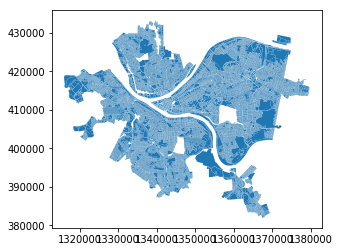

In [9]:
table_1999.plot()

In [65]:
apd_1999.loc['0162H00197000000']

AREA                                                                                                                                                                                                                                              7409.25
PERIMETER                                                                                                                                                                                                                                         385.094
CITYPROP_                                                                                                                                                                                                                                             226
CITYPROP_I                                                                                                                                                                                                                                              9


In [191]:
apd_1999b[apd_1999b.SALEDATE=='1970-21-01']

AREA  PERIMETER  CITYPROP_  CITYPROP_I  MAP BLOCK  \
PARID                                                                       
0232C00201000000  4936.50667  290.02102      66036        1235  232     C   

                  PARCEL PARSUF CITYPROP_L       ID WARD TRACT_ BLOCKLOT  \
PARID                                                                      
0232C00201000000     201   None    232C201  49777.0   13     06  232C201   

                 GISLOTBLOC REALGIS_LO     STREET STREETSUF STREETNUM  \
PARID                                                                   
0232C00201000000    232C201    232C201  SWISSVALE        AV      2000   

                  GISSTRTNUM STREETHALF REARCODE        ONAME1 ONAME2 ONAME3  \
PARID                                                                          
0232C00201000000      2000.0          A     None  SEACH CO INC   None   None   

                        OWNERADDR                 OWNERCITY DATABLOCK BG1960  \
PARID                                                                          
0232C00201000000  6255 LIBRARY RD  BETHEL PARK PA      1510      None   None   

                 TRACT1960 BG1970  TLANDASMT  TBLDGASMT  TAXAREA OLDLUSECDE  \
PARID                                                                         
0232C00201000000        00    127        0.0        0.0      0.0       None   

                 CORPCDENUM ZONING SLOPE PROBLEMCOD ASMTTYPECD PARCELCLAS  \
PARID                                                                       
0232C00201000000       None    RP/     L       None          T       None   

                 EXCORPREGC  EXLNDASSMT  EXBLDASMT  EXAREAASMT DATELASTSE  \
PARID                                                                       
0232C00201000000          C         0.0        0.0         0.0       2170   

                  PRICELASTS TYPELASTSE  \
PARID                                     
0232C00201000000         0.0          0   

                                                                                                                                                                                                                                                                                  geometry  \
PARID                                                                                                                                                                                                                                                                                        
0232C00201000000  POLYGON ((1377509.68309758 414335.9621089065, 1377587.484324807 414326.4896924347, 1377594.0639202 414276.603867323, 1377595.396720557 414266.4988609588, 1377500.173251163 414282.1671634205, 1377501.478342775 414290.5023517364, 1377509.68309758 414335.9621089065))   

                 PROPERTYOWNER                    owner_address_raw  \
PARID                                                                 
0232C00201000000  SEACH CO INC  6255 LIBRARY RD BETHEL PARK PA 1510   

                    SALEDATE  
PARID                         
0232C00201000000  1970-21-01

# MDB Support

In [9]:
# From https://stackoverflow.com/questions/17123550/extract-and-sort-data-from-mdb-file-using-mdbtools-in-python?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa
import sys, subprocess, os, numpy
from io import StringIO
import pandas as pd
import pandas
VERBOSE = True
def mdb_to_pandas(database_path,dtype_map):
    subprocess.call(["mdb-schema", database_path, "mysql"])
    # Get the list of table names with "mdb-tables"
    table_names = subprocess.Popen(["mdb-tables", "-1", database_path],
                                   stdout=subprocess.PIPE).communicate()[0]
    tables = table_names.splitlines()
    sys.stdout.flush()
    # Dump each table as a stringio using "mdb-export",
    out_tables = {}
    for rtable in tables:
        table = rtable.decode()
        if VERBOSE: print('running table:',table)
        if table != '':
            if VERBOSE: print("Dumping " + table)
            contents = subprocess.Popen(["mdb-export", database_path, table],
                                        stdout=subprocess.PIPE).communicate()[0]
            temp_io = StringIO(contents.decode('utf8'))
            print(table, temp_io)
            out_tables[table] = pd.read_csv(temp_io,dtype=dtype_map)
    return out_tables
pd.options.display.max_colwidth = 300
pd.set_option('display.max_columns', 500)


In [17]:
# ACCDB files are from Bob Gradeck
# 2009 is missing YEARBLT, CLASSDESC, and CLASS

# A number of files after 2009 seem to have a common set of column names
post_2009_colmap = {'mapblolot':'PARID',
                    'PropertyHouseNum'    :'PROPERTYHOUSENUM', 
                    'PropertyFraction'    :'PROPERTYFRACTION', 
                    'PropertyAddress'     :'PROPERTYADDRESS',  
                    'PropertyUnit'        :'PROPERTYUNIT',     
                    'PropertyCityState'   :'PROPERTYCITY',     
                    'PropertyLocation2'   :'PROPERTYSTATE',    
                    'PropertyZip'         :'PROPERTYZIP',       
                    'FairMarketTotal':'FAIRMARKETTOTAL',
                    'UseDesc':'USEDESC',
                    'PropertyZip':'PROPERTYZIP',
                    'PropertyOwner2':'PROPERTYOWNER',
                    'ChangeNoticeFullAddress1':'CHANGENOTICEADDRESS1',
                    'ChangeNoticeFullAddress2':'CHANGENOTICEADDRESS2',
                    'ChangeNoticeFullAddress3':'CHANGENOTICEADDRESS3',
                    'ChangeNoticeFullAddress4':'CHANGENOTICEADDRESS4',
                    'HomesteadFlag':'HOMESTEADFLAG',
                    'OwnerDesc':'OWNERDESC',
                    'SaleDate':'SALEDATE',
                    'SalePrice':'SALEPRICE',
                    'SaleCode': 'SALECODE',
                    'SaleDesc': 'SALEDESC'
                    }
post_2009_dtype = {'PropertyHouseNum':numpy.str,'PropertyFraction':numpy.str, 'PropertyZip':numpy.str,
                    'ChangeNoticeFullAddress1':numpy.str,'ChangeNoticeFullAddress2':numpy.str, 
                    'ChangeNoticeFullAddress3':numpy.str,'ChangeNoticeFullAddress4':numpy.str, 
                   }

accdb_info = {'2004':{'fname': 'assessments/kristin/ParcelData_RandySargent/2004/db1.mdb',
                      'tname': 'LandFileAug2001',
                      'col_remap': {'MapBloLot':'PARID',
                                    'CurOwnerName':'PROPERTYOWNER',
                        },
                      'dtype':{'MailStreetNumber':numpy.str,'MailZipCode':numpy.str}
                     },
              '2005':{'fname': 'assessments/kristin/ParcelData_RandySargent/2005/AC db 10.20.05.mdb',
                      'tname': 'DS09-21-05',
                      'col_remap': {'Field1':'PARID',
                                    'Field2':'PROPERTYOWNER'
                        },
                      'dtype':{'Field45':numpy.str}
                     },
              '2009':{'fname':'assessments/gradeck/AssessmentSep09.mdb',
                      'tname':'pncis',
                     'col_remap': {'PIN':'PARID',
                                    'PROPERTYHO':'PROPERTYHOUSENUM', 
                                    'PROPERTYAD':'PROPERTYFRACTION', 
                                    'PROPERTY_1':'PROPERTYADDRESS',  
                                    'PROPERTYUN':'PROPERTYUNIT',     
                                    'PROPERTYLO':'PROPERTYCITY',     
                                    'PROPERTYCI':'PROPERTYSTATE',    
                                    'PROPERTYZI':'PROPERTYZIP',       
                                    'FAIRMARK_2':'FAIRMARKETTOTAL',
                                    'USEDESC':'USEDESC',
                                    'PROPERTYZI':'PROPERTYZIP',
                                    'PROPERTYOW':'PROPERTYOWNER',
                                    'CHANGENOTI':'CHANGENOTICEADDRESS1',
                                    'CHANGENO_1':'CHANGENOTICEADDRESS2',
                                    'CHANGENO_2':'CHANGENOTICEADDRESS3',
                                    'CHANGENO_3':'CHANGENOTICEADDRESS4',
                                    'HOMESTEADF':'HOMESTEADFLAG',
                                    'OWNERDESC':'OWNERDESC',
                                    'SALEDATE':'SALEDATE',
                                    'SALEPRICE':'SALEPRICE'
                                  },
                      'dtype':{'PROPERTYHO':numpy.str,'PROPERTY_1':numpy.str,'PROPERTYUN':numpy.str,
                                'PROPERTYLO':numpy.str,'PROPERTYCI':numpy.str,'PROPERTYZI':numpy.str}
                     },
               '2010':{'fname':'assessments/gradeck/June2010AssessNew.accdb',
                       'tname':'RawDataAssessment',
                       'col_remap': post_2009_colmap,
                       'dtype': post_2009_dtype
                      },
               '2011':{'fname':'assessments/gradeck/AssessMarch2011Data3.mdb.accdb',
                       'tname':'AssessMarch2011',
                       'col_remap': {'PIN':'PARID',
                                    'PropertyOwnerNew':'PROPERTYOWNER',
                                    'CHANGENOTICEFULLADDRESS1':'CHANGENOTICEADDRESS1',
                                    'CHANGENOTICEFULLADDRESS2':'CHANGENOTICEADDRESS2',
                                    'CHANGENOTICEFULLADDRESS3':'CHANGENOTICEADDRESS3',
                                    'CHANGENOTICEFULLADDRESS4':'CHANGENOTICEADDRESS4',
                                    'PROPERTYHOUSENUM'    :'PROPERTYHOUSENUM',
                                    'PROPERTYADDNUMPREFIX':'PROPERTYFRACTION',
                                    'PROPERTYADDRESS'     :'PROPERTYADDRESS',
                                    'PROPERTYUNIT'        :'PROPERTYUNIT',
                                    'PROPERTYLOCATION2'   :'PROPERTYCITY',
                                    'PROPERTYCITYSTATE'   :'PROPERTYSTATE',
                                    'PROPERTYZIP'         :'PROPERTYZIP'       

                                  },
                        'dtype':{'PROPERTYHOUSENUM':numpy.str,'PROPERTYADDRESS':numpy.str,'PROPERTYUNIT':numpy.str,
                                'PROPERTYLOCATION2':numpy.str,'PROPERTYCITYSTATE':numpy.str,'PROPERTYZIP':numpy.str}
                      },
               '2012':{'fname':'assessments/gradeck/AssessNov2012.mdb',
                       'tname':'AssessmentOct2_2012',                       
                       'col_remap': {'SALEDATE':'SALEDATE_raw'},
                       'dtype':{'PROPERTYHOUSENUM':numpy.str,'PROPERTYADDRESS':numpy.str,'PROPERTYUNIT':numpy.str,
                                'PROPERTYLOCATION2':numpy.str,'PROPERTYCITYSTATE':numpy.str,'PROPERTYZIP':numpy.str,
                                'SALEDATE':numpy.str, 'CHANGENOTICEADDRESS1':numpy.str,
                                'CHANGENOTICEADDRESS2':numpy.str, 'CHANGENOTICEADDRESS3':numpy.str,
                                'CHANGENOTICEADDRESS4':numpy.str,}
                      },
               '2013':{'fname':'assessments/gradeck/Dec2013Assess.accdb',
                       'tname':'RawDataAssessment',
                       'col_remap': post_2009_colmap,
                       'dtype': post_2009_dtype
                      },
               '2014':{'fname':'assessments/gradeck/June2014Assess.accdb',
                       'tname':'RawDataAssessment',
                       'col_remap': post_2009_colmap,
                       'dtype': post_2009_dtype
                      },
               '2015':{'fname':'assessments/gradeck/May2015Assess.accdb',
                       'tname':'RawDataAssessment',
                       'col_remap': post_2009_colmap,
                       'dtype': post_2009_dtype
                      }
             }

In [13]:
# Uses accdb_info map to import a file for a given year and return a dataframe.  
# This doesn't remap the column names (we might not know them yet)
def import_accdb_file(year):
    # Import the accdb file for this year.  The returned value is a map of table names to tables
    accdb_table_map = mdb_to_pandas(accdb_info[year]['fname'], accdb_info[year]['dtype'])     
    apd_df = accdb_table_map[accdb_info[year]['tname']]
    return apd_df

# Takes a dataframe imported by import_accdb_file, renames columns, sets the index to PARID, 
# filters out rows that aren't dwellings, sets zipcode to be type string
skip_dwelling_col=False
def cleanup_accdb_import(df, year):
    r_df = df.rename(index=str, columns=accdb_info[year]['col_remap']).set_index('PARID')
    if(not skip_dwelling_col):
        r_df = pd.merge(r_df,dwelling_col.to_frame(),on='PARID', left_on=None, right_on=None,
                         left_index=False, right_index=False, sort=False,
                         suffixes=('_x', '_y'), copy=True, indicator=False,
                         validate=None)
        print "After merge, size = %d" % (len(r_df))

        r_df = r_df[r_df.is_dwelling]
        print "After filtering to only include dwellings, size = %d" % (len(r_df))

    # Change ',  -' in CHANGENOTICEADDRESS3 to nan (that's a common pattern in these accdb files)
    bad_changeaddr = r_df.CHANGENOTICEADDRESS3==',  -'
    r_df.loc[bad_changeaddr,'CHANGENOTICEADDRESS3']= numpy.nan

    # Filter out empty owner names
    empty_owner = r_df.PROPERTYOWNER.isna()

    # Filter out empty change addresses
    p1=pandas.isna(r_df.CHANGENOTICEADDRESS1) 
    p2=pandas.isna(r_df.CHANGENOTICEADDRESS2) 
    p3=pandas.isna(r_df.CHANGENOTICEADDRESS3)
    p4=pandas.isna(r_df.CHANGENOTICEADDRESS4)
    r_df = r_df[~((p1&p2&p3&p4)|empty_owner)]
    print "After filtering to remove empty owner names and change addresses, size = %d" % (len(r_df))

    # Fix up <BR> to be &
    r_df.PROPERTYOWNER = r_df.PROPERTYOWNER.str.replace('\s*<BR>\s*', ' & ', regex=True)
    return r_df

# More cleanup after merge
def cleanup_merged_accdb_import(df, year):
    # A common pattern of bad addresses is ' , -0000 ', get rid of ones like this
    bad_owner_addr = df.owner_address_raw.str.contains('^[\s,]*-\d\d\d\d\s*$',regex=True)
    r_df = df[~(bad_owner_addr)]
    print "After filtering to remove malformed owner_address_raw addresses, size = %d" % (len(r_df))
    return r_df

# Process 2004 data from Kristin

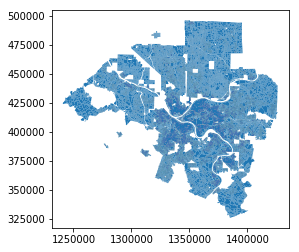

In [209]:
# Following example in https://stackoverflow.com/questions/41898561/pandas-transform-a-dbf-table-into-a-dataframe
# Unfortunately, this is only geometry
path_2004 = 'assessments/kristin/ParcelData_RandySargent/2004/parcels.shp'
table_2004=gpd.read_file(path_2004)

table_2004.plot()

In [228]:
# Try the mdb file instead
apd_2004_raw = import_accdb_file('2004') 
apd_2004_raw

('running table:', u'LandFileAug2001')
Dumping LandFileAug2001
(u'LandFileAug2001', <_io.StringIO object at 0x7f81458a5350>)


/home/rsargent/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2878: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


('running table:', u'Municipalities')
Dumping Municipalities
(u'Municipalities', <_io.StringIO object at 0x7f8145814450>)
('running table:', u'Projects')
Dumping Projects
(u'Projects', <_io.StringIO object at 0x7f81458a5350>)
('running table:', u'SMDA2002')
Dumping SMDA2002
(u'SMDA2002', <_io.StringIO object at 0x7f81458901d0>)
('running table:', u'AllOwners')
Dumping AllOwners
(u'AllOwners', <_io.StringIO object at 0x7f81458a5350>)


MapBloLot    OldBlockLot  TotalLandAssess  TotalBuildingAssess  \
0       0001A00100000000        1-A-100         11220800                    0   
1       0001A00100000000        1-A-100         11220800                    0   
2       0001B00010000000         1-B-10          4834400                    0   
3       0001B00010000000         1-B-10          4834400                    0   
4       0001B00024000000         1-B-24           455000                 7400   
5       0001B00024000000         1-B-24           455000                 7400   
6       0001B00026000000         1-B-26           139000                    0   
7       0001B00026000000         1-B-26           139000                    0   
8       0001B00050000000         1-B-50         27002700               119900   
9       0001B00050000000         1-B-50         27002700               119900   
10      0001C00037000000         1-C-37          1481100             16392200   
11      0001C00037000000         1-C-37          1481100             16392200   
12      0001C00058000000         1-C-58          4275500             29714700   
13      0001C00058000000         1-C-58          4275500             29714700   
14      0001C00110000000        1-C-110            75300                    0   
15      0001C00110000000        1-C-110            75300                    0   
16      0001C00111000000        1-C-111           113500                    0   
17      0001C00111000000        1-C-111           113500                    0   
18      0001C00167000001      1-C-167-1          8544800             39284700   
19      0001C00167000001      1-C-167-1          8544800             39284700   
20      0001C00167000002      1-C-167-2          2889900             16609500   
21      0001C00167000002      1-C-167-2          2889900             16609500   
22      0001C00170000000        1-C-170          1205300               872500   
23      0001C00170000000        1-C-170          1205300               872500   
24      0001C00190000000        1-C-190          9312600             40988100   
25      0001C00190000000        1-C-190          9312600             40988100   
26      0001C00200000000        1-C-200          2169000              4770300   
27      0001C00200000001      1-C-200-1           185100               231000   
28      0001C00200000001      1-C-200-1           185100               231000   
29      0001C00224000000        1-C-224           427600              1049600   
30      0001C00224000000        1-C-224           427600              1049600   
31      0001C00226000000        1-C-226           340000              1935700   
32      0001C00226000000        1-C-226           340000              1935700   
33      0001C00228000000        1-C-228          1493000              8415800   
34      0001C00228000000        1-C-228          1493000              8415800   
35      0001C01661000000       1-C-1661                0               217300   
36      0001C01661000100     1-C-1661-1                0                54400   
37      0001C01661001100    1-C-1661-11                0                46000   
38      0001C01661002300    1-C-1661-23                0               120100   
39      0001C01661003400    1-C-1661-34                0               149600   
40      0001C01661006700    1-C-1661-67                0                62100   
41      0001C01661009700    1-C-1661-97                0                56000   
42      0001C0166100W200    1-C-1661-W2                0                97800   
43      0001C01661011400   1-C-1661-114                0                34200   
44      0001C01661032200   1-C-1661-322                0                40800   
45      0001C016610W2100   1-C-1661-W21                0                32100   
46      0001C016610W2600   1-C-1661-W26                0                 5300   
47      0001C016610W2900   1-C-1661-W29                0                 3800   
48      0001C01661512600  1-C-1661-5126       

In [233]:
year='2004'
apd_2004 = apd_2004_raw.rename(index=str, columns=accdb_info[year]['col_remap'])
apd_2004 = apd_2004.set_index('PARID')
apd_2004

OldBlockLot  TotalLandAssess  TotalBuildingAssess  \
PARID                                                                   
0001A00100000000        1-A-100         11220800                    0   
0001A00100000000        1-A-100         11220800                    0   
0001B00010000000         1-B-10          4834400                    0   
0001B00010000000         1-B-10          4834400                    0   
0001B00024000000         1-B-24           455000                 7400   
0001B00024000000         1-B-24           455000                 7400   
0001B00026000000         1-B-26           139000                    0   
0001B00026000000         1-B-26           139000                    0   
0001B00050000000         1-B-50         27002700               119900   
0001B00050000000         1-B-50         27002700               119900   
0001C00037000000         1-C-37          1481100             16392200   
0001C00037000000         1-C-37          1481100             16392200   
0001C00058000000         1-C-58          4275500             29714700   
0001C00058000000         1-C-58          4275500             29714700   
0001C00110000000        1-C-110            75300                    0   
0001C00110000000        1-C-110            75300                    0   
0001C00111000000        1-C-111           113500                    0   
0001C00111000000        1-C-111           113500                    0   
0001C00167000001      1-C-167-1          8544800             39284700   
0001C00167000001      1-C-167-1          8544800             39284700   
0001C00167000002      1-C-167-2          2889900             16609500   
0001C00167000002      1-C-167-2          2889900             16609500   
0001C00170000000        1-C-170          1205300               872500   
0001C00170000000        1-C-170          1205300               872500   
0001C00190000000        1-C-190          9312600             40988100   
0001C00190000000        1-C-190          9312600             40988100   
0001C00200000000        1-C-200          2169000              4770300   
0001C00200000001      1-C-200-1           185100               231000   
0001C00200000001      1-C-200-1           185100               231000   
0001C00224000000        1-C-224           427600              1049600   
0001C00224000000        1-C-224           427600              1049600   
0001C00226000000        1-C-226           340000              1935700   
0001C00226000000        1-C-226           340000              1935700   
0001C00228000000        1-C-228          1493000              8415800   
0001C00228000000        1-C-228          1493000              8415800   
0001C01661000000       1-C-1661                0               217300   
0001C01661000100     1-C-1661-1                0                54400   
0001C01661001100    1-C-1661-11                0                46000   
0001C01661002300    1-C-1661-23                0               120100   
0001C01661003400    1-C-1661-34                0               149600   
0001C01661006700    1-C-1661-67                0                62100   
0001C01661009700    1-C-1661-97                0                56000   
0001C0166100W200    1-C-1661-W2                0                97800   
0001C01661011400   1-C-1661-114                0                34200   
0001C01661032200   1-C-1661-322                0                40800   
0001C016610W2100   1-C-1661-W21                0                32100   
0001C016610W2600   1-C-1661-W26                0                 5300   
0001C016610W2900   1-C-1661-W29                0                 3800   
0001C01661512600  1-C-1661-5126                0                18700   
0001C01661A03800  1-C-1661-A038                0                84000   
...                         ...              ...                  ...   
9946X87717000000   9946-X-87717            35500                    0   
9946X87718000000   9946-X-87718            92800                    0   
9946X

In [220]:
apd_2004[~pd.isna(apd_2004.MailStreetFraction)]

OldBlockLot  TotalLandAssess  TotalBuildingAssess  \
PARID                                                                     
0002A00025000000           2-A-25           159900               190300   
0002A00025000000           2-A-25           159900               190300   
0002D00314000000          2-D-314             5500                21100   
0002F00175002100       2-F-175-21                0                50900   
0002F00175002700       2-F-175-27                0                40700   
0002F00175002800       2-F-175-28                0                40500   
0002F00175004200       2-F-175-42                0                25600   
0002F00175006200       2-F-175-62                0                25600   
0002F00175006300       2-F-175-63                0                40400   
0002F00175006600       2-F-175-66                0                30400   
0002F00175007300       2-F-175-73                0                40400   
0002F00175009100       2-F-175-91                0                50900   
0002F00175015200      2-F-175-152                0                25600   
0002F00175019100      2-F-175-191                0               184800   
0002F00175020800      2-F-175-208                0                40500   
0002F00175091100      2-F-175-911                0                25900   
0002F00175091200      2-F-175-912                0                27900   
0002F00175101200     2-F-175-1012                0                27900   
0002H00324000A00        2-H-324-A              400                    0   
0003H00320000000          3-H-320            10900                28900   
0003L00038000000           3-L-38            12100                28400   
0003M00343000A00        3-M-343-A            11500                40800   
0003N00028000B00         3-N-28-B             3000                30200   
0003P00233000000          3-P-233              300                    0   
0003P00258000000          3-P-258             7100                18000   
0003P00262000000          3-P-262             7300                27900   
0003R00145000000          3-R-145             6200                24600   
0004A00218000000          4-A-218            14100                45500   
0004E00222000000          4-E-222              300                    0   
0004F00246000000          4-F-246             8700                29800   
0004G00131000000          4-G-131            16400                47200   
0004K00066000000           4-K-66              900                    0   
0004K00100000000          4-K-100             7300                44800   
0004R00067000000           4-R-67             7700                33100   
0004S00288000000          4-S-288             2800                38000   
0006A00125000000          6-A-125            12900               192900   
0006A00129000000          6-A-129            22300                    0   
0006A00143000000          6-A-143             4700                    0   
0006G00201000000          6-G-201            16100                92300   
0006M00312081500      6-M-312-815            51100               325400   
0006M00312101000     6-M-312-1010            34500               209600   
0006S00060000000           6-S-60            18000               100900   
0006S00160000000          6-S-160            15300                61100   
0007B00218000000          7-B-218             3400                16000   
0007B00303000000          7-B-303             3100                53900   
0009A00160000000          9-A-160             9700                    0   
0009M00125000000          9-M-125             8000                35100   
0009R00158000000          9-R-158             4600                60600   
0009S00230000A00        9-S-230-A             8000                42100   
0009S00414000100        9-S-414-1             9100                35100   
...                           ...              ...                  ...   
8000T03462000000      8000-T-3462              

In [234]:
len(apd_2004)

557695

In [253]:
# Filter out empty owner address
apd_2004 = apd_2004[~(pd.isna(apd_2004.MailCity) | (apd_2004.MailStreetName=='NO KNOWN ADDRESS'))].copy()
len(apd_2004)

549927

In [257]:
# Replace PGH with PITTSBURGH
apd_2004['MailCity']= apd_2004['MailCity'].str.replace('\s*PGH\s*', 'PITTSBURGH', regex=True)

In [258]:
# Truncate leading zeroes from MailStreetNumber
apd_2004['MailStreetNumber']= apd_2004['MailStreetNumber'].str.replace('^0+', '', regex=True)

In [259]:
# Truncate trailing zeroes from MailZipCode
apd_2004['MailZipCode']= apd_2004['MailZipCode'].str.replace('0000$', '', regex=True)

In [260]:
oa_arr_2004 = ['MailStreetNumber','MailStreetFraction','MailStreetName','MailCity','MailState','MailZipCode']
df=apd_2004

for  col_name in oa_arr_2004:
    df[col_name]=df[col_name].astype(basestring)
    df[col_name].fillna('', inplace=True)

df['owner_address_raw'] = df[oa_arr_2004].apply(' '.join, axis=1)
oa_arr_2004.append('owner_address_raw')

In [261]:
# Fix up to make sure there aren't differences in whitespace that could be avoided
df['owner_address_raw'] = df['owner_address_raw'].str.replace('\s\s+', ' ', regex=True)


In [275]:
df['owner_address_raw'] = df['owner_address_raw'].str.replace('^\s+', '', regex=True)
df['owner_address_raw'] = df['owner_address_raw'].str.replace('\s+$', '', regex=True)

In [262]:
df[oa_arr_2004]

MailStreetNumber MailStreetFraction        MailStreetName  \
PARID                                                                        
0001A00100000000              300                              LIBERTY AVE   
0001A00100000000              300                              LIBERTY AVE   
0001B00010000000              300                              LIBERTY AVE   
0001B00010000000              300                              LIBERTY AVE   
0001B00024000000                                        FT PITT BLOCKHOUSE   
0001B00024000000                                        FT PITT BLOCKHOUSE   
0001B00026000000              300                              LIBERTY AVE   
0001B00026000000              300                              LIBERTY AVE   
0001B00050000000              300                              LIBERTY AVE   
0001B00050000000              300                              LIBERTY AVE   
0001C00037000000                                              PO BOX A3879   
0001C00037000000                                              PO BOX A3879   
0001C00058000000                                      ONE OXFORD CTR #4500   
0001C00058000000                                      ONE OXFORD CTR #4500   
0001C00110000000              215                         CITY COUNTY BLDG   
0001C00110000000              215                         CITY COUNTY BLDG   
0001C00111000000              215                         CITY COUNTY BLDG   
0001C00111000000              215                         CITY COUNTY BLDG   
0001C00167000001                                        TWO GATEWAY CENTER   
0001C00167000001                                        TWO GATEWAY CENTER   
0001C00167000002                                        TWO GATEWAY CENTER   
0001C00167000002                                        TWO GATEWAY CENTER   
0001C00170000000              117                               S. 17TH ST   
0001C00170000000              117                               S. 17TH ST   
0001C00190000000                                        TWO GATEWAY CENTER   
0001C00190000000                                        TWO GATEWAY CENTER   
0001C00200000000                                        TWO GATEWAY CENTER   
0001C00200000001             2235                               BEAVER AVE   
0001C00200000001             2235                               BEAVER AVE   
0001C00224000000             1314                        SQUIRREL HILL AVE   
0001C00224000000             1314                        SQUIRREL HILL AVE   
0001C00226000000              875                     GREENTREE RD STE 300   
0001C00226000000              875                     GREENTREE RD STE 300   
0001C00228000000              875                     GREENTREE RD STE 300   
0001C00228000000              875                     GREENTREE RD STE 300   
0001C01661000000              117                            SOUTH 17TH ST   
0001C01661000100              994                             BROADHEAD RD   
0001C01661001100                                            GATEWAY TOWERS   
0001C01661002300              320                         FT DUQUESNE BLVD   
0001C01661003400              200                           GATEWAY TOWERS   
0001C01661006700              235                      GATEWAY TOWERS EXEC   
0001C01661009700                                            GATEWAY TOWERS   
0001C0166100W200             2689                              OAK HILL DR   
0001C01661011400              112                         WASHINGTON PLACE   
0001C01661032200              200                           GATEWAY TOWERS   
0001C016610W2100              320                         FT DUQUESEN BLVD   
0001C016610W2600                0                           GATEWAY TOWERS   
0001C016610W2900                0                           GATEWAY TOWERS   
0001C01661512600              320                         FT DUQUESNE BLVD   
0001C01661A03800                       

In [263]:
apd_2004=df

In [266]:
apd_2004[apd_2004.MailStreetFraction!=''][oa_arr_2004]

MailStreetNumber MailStreetFraction        MailStreetName  \
PARID                                                                        
0002A00025000000              818                  L            IBERTY AVE   
0002A00025000000              818                  L            IBERTY AVE   
0002D00314000000              657                  5              ROWAN ST   
0002F00175002100                2                  A         CHATHAM TOWER   
0002F00175002700               20                  A   CHATHAM TOWER CONDO   
0002F00175002800               20                  A   CHATHAM TOWER CONDO   
0002F00175004200               20                  A   CHATHAM TOWER CONDO   
0002F00175006200               20                  A   CHATHAM TOWER CONDO   
0002F00175006300                6                  C         CHATHAM TOWER   
0002F00175006600                6                  C         CHATHAM TOWER   
0002F00175007300              112                  C      WASHINGTON PLACE   
0002F00175009100               20                  A   CHATHAM TOWER CONDO   
0002F00175015200               15                  H     CHATHAM TOWER APT   
0002F00175019100               19                  A        CHATHAM TOWERS   
0002F00175020800               20                  A   CHATHAM TOWER CONDO   
0002F00175091100               20                  A   CHATHAM TOWER CONDO   
0002F00175091200               20                  A   CHATHAM TOWER CONDO   
0002F00175101200                7                  C   TOWER A CHATHAM CTR   
0002H00324000A00               10                  5          COVINGTON ST   
0003H00320000000               47                  5         S 15TH STREET   
0003L00038000000              128                  5             S 11TH ST   
0003M00343000A00              131                  5         SOUTH 12TH ST   
0003N00028000B00              450                  5           KATHLEEN ST   
0003P00233000000               20                  S           JACKSON AVE   
0003P00258000000              915                  E              UREKA ST   
0003P00262000000             2218                  5           BEDFORD AVE   
0003R00145000000             5092                  5          KEINERS LANE   
0004A00218000000              321                  5          VIRGINIA AVE   
0004E00222000000              400                  N            NATCHEZ ST   
0004F00246000000              118                  5            NATCHEZ ST   
0004G00131000000                6                  5           WYOMING ST.   
0004K00066000000                9                  5             NORTON ST   
0004K00100000000                9                  5             NORTON ST   
0004R00067000000               44                  5               RUTH ST   
0004S00288000000               79                  5          HABERMAN AVE   
0006A00125000000               36                  5         DENNY ESTATES   
0006A00129000000               36                  5         DENNY ESTATES   
0006A00143000000               36                  5         DENNY ESTATES   
0006G00201000000              219                  D         GRANDVIEW AVE   
0006M00312081500             1815                  1          TRIMONT LANE   
0006M00312101000             1000                  A         TRIMONT TOWER   
0006S00060000000              849                  A      SLEEPY HOLLOW RD   
0006S00160000000              233                  H             ALLOCK ST   
0007B00218000000             1420                  5               PAGE ST   
0007B00303000000               23                  A              DEWEY ST   
0009A00160000000              636                  5          BECKS RUN RD   
0009M00125000000             1807                  5              CLIFF ST   
0009R00158000000             2218                  5           BEDFORD AVE   
0009S00230000A00             1816                  5           WEBSTER AVE   
0009S00414000100              539      

In [276]:
print  apd_2004.loc['0002A00025000000']['owner_address_raw'].unique()
print  apd_2004.loc['0003P00258000000']['owner_address_raw']
print  apd_2004.loc['0006S00160000000']['owner_address_raw']
print  apd_2004.loc['9844X00063000000']['owner_address_raw']
print  apd_2004.loc['9910X00158000000']['owner_address_raw']
print  apd_2004.loc['9923X82055000000']['owner_address_raw']
print  apd_2004.loc['9929X00669000000']['owner_address_raw']
print  apd_2004.loc['9946X50144000000']['owner_address_raw']


['818 LIBERTY AVE PITTSBURGH PA 15222']
915 EUREKA ST PITTSBURGH PA 15210
233 HALLOCK ST PITTSBURGH PA 15211
301 MOREA RD FRACKVILLE PA 17932
9 G TON DR SUNNYVALE CA 94087
200 PARKWOOD DR RD3 MARS PA 16046
7 BOX 45 IMPERIAL PA 15126
MCVEY ST STURGEON PA 15082


In [274]:
apd_2004.set_value('0002A00025000000','owner_address_raw','818 LIBERTY AVE PITTSBURGH PA 15222')
apd_2004.set_value('0003P00258000000','owner_address_raw','915 EUREKA ST PITTSBURGH PA 15210')
apd_2004.set_value('0006S00160000000','owner_address_raw','233 HALLOCK ST PITTSBURGH PA 15211')
apd_2004.set_value('9844X00063000000','owner_address_raw','301 MOREA RD FRACKVILLE PA 17932')
apd_2004.set_value('9910X00158000000','owner_address_raw','9 G TON DR SUNNYVALE CA 94087')
apd_2004.set_value('9923X82055000000','owner_address_raw','200 PARKWOOD DR RD3 MARS PA 16046')
apd_2004.set_value('9929X00669000000','owner_address_raw','7 BOX 45 IMPERIAL PA 15126')
apd_2004.set_value('9946X50144000000','owner_address_raw',' MCVEY ST STURGEON PA 15082')


/home/rsargent/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """Entry point for launching an IPython kernel.
/home/rsargent/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
/home/rsargent/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  This is separate from the ipykernel package so we can avoid doing imports until
/home/rsargent/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  after removing the cwd from sys.path.
/home/rsargen

OldBlockLot  TotalLandAssess  TotalBuildingAssess  \
PARID                                                                   
0001A00100000000        1-A-100         11220800                    0   
0001A00100000000        1-A-100         11220800                    0   
0001B00010000000         1-B-10          4834400                    0   
0001B00010000000         1-B-10          4834400                    0   
0001B00024000000         1-B-24           455000                 7400   
0001B00024000000         1-B-24           455000                 7400   
0001B00026000000         1-B-26           139000                    0   
0001B00026000000         1-B-26           139000                    0   
0001B00050000000         1-B-50         27002700               119900   
0001B00050000000         1-B-50         27002700               119900   
0001C00037000000         1-C-37          1481100             16392200   
0001C00037000000         1-C-37          1481100             16392200   
0001C00058000000         1-C-58          4275500             29714700   
0001C00058000000         1-C-58          4275500             29714700   
0001C00110000000        1-C-110            75300                    0   
0001C00110000000        1-C-110            75300                    0   
0001C00111000000        1-C-111           113500                    0   
0001C00111000000        1-C-111           113500                    0   
0001C00167000001      1-C-167-1          8544800             39284700   
0001C00167000001      1-C-167-1          8544800             39284700   
0001C00167000002      1-C-167-2          2889900             16609500   
0001C00167000002      1-C-167-2          2889900             16609500   
0001C00170000000        1-C-170          1205300               872500   
0001C00170000000        1-C-170          1205300               872500   
0001C00190000000        1-C-190          9312600             40988100   
0001C00190000000        1-C-190          9312600             40988100   
0001C00200000000        1-C-200          2169000              4770300   
0001C00200000001      1-C-200-1           185100               231000   
0001C00200000001      1-C-200-1           185100               231000   
0001C00224000000        1-C-224           427600              1049600   
0001C00224000000        1-C-224           427600              1049600   
0001C00226000000        1-C-226           340000              1935700   
0001C00226000000        1-C-226           340000              1935700   
0001C00228000000        1-C-228          1493000              8415800   
0001C00228000000        1-C-228          1493000              8415800   
0001C01661000000       1-C-1661                0               217300   
0001C01661000100     1-C-1661-1                0                54400   
0001C01661001100    1-C-1661-11                0                46000   
0001C01661002300    1-C-1661-23                0               120100   
0001C01661003400    1-C-1661-34                0               149600   
0001C01661006700    1-C-1661-67                0                62100   
0001C01661009700    1-C-1661-97                0                56000   
0001C0166100W200    1-C-1661-W2                0                97800   
0001C01661011400   1-C-1661-114                0                34200   
0001C01661032200   1-C-1661-322                0                40800   
0001C016610W2100   1-C-1661-W21                0                32100   
0001C016610W2600   1-C-1661-W26                0                 5300   
0001C016610W2900   1-C-1661-W29                0                 3800   
0001C01661512600  1-C-1661-5126                0                18700   
0001C01661A03800  1-C-1661-A038                0                84000   
...                         ...              ...                  ...   
9946X87705000000   9946-X-87705            34600                    0   
9946X87706000000   9946-X-87706            36300                    0   
9946X

In [284]:
# Filter out duplicate indices
apd_2004 = apd_2004[~apd_2004.index.duplicated()].copy()

In [285]:
len(apd_2004)

544530

In [286]:
apd_2004[oa_arr_2004]

MailStreetNumber MailStreetFraction        MailStreetName  \
PARID                                                                        
0001A00100000000              300                              LIBERTY AVE   
0001B00010000000              300                              LIBERTY AVE   
0001B00024000000                                        FT PITT BLOCKHOUSE   
0001B00026000000              300                              LIBERTY AVE   
0001B00050000000              300                              LIBERTY AVE   
0001C00037000000                                              PO BOX A3879   
0001C00058000000                                      ONE OXFORD CTR #4500   
0001C00110000000              215                         CITY COUNTY BLDG   
0001C00111000000              215                         CITY COUNTY BLDG   
0001C00167000001                                        TWO GATEWAY CENTER   
0001C00167000002                                        TWO GATEWAY CENTER   
0001C00170000000              117                               S. 17TH ST   
0001C00190000000                                        TWO GATEWAY CENTER   
0001C00200000000                                        TWO GATEWAY CENTER   
0001C00200000001             2235                               BEAVER AVE   
0001C00224000000             1314                        SQUIRREL HILL AVE   
0001C00226000000              875                     GREENTREE RD STE 300   
0001C00228000000              875                     GREENTREE RD STE 300   
0001C01661000000              117                            SOUTH 17TH ST   
0001C01661000100              994                             BROADHEAD RD   
0001C01661001100                                            GATEWAY TOWERS   
0001C01661002300              320                         FT DUQUESNE BLVD   
0001C01661003400              200                           GATEWAY TOWERS   
0001C01661006700              235                      GATEWAY TOWERS EXEC   
0001C01661009700                                            GATEWAY TOWERS   
0001C0166100W200             2689                              OAK HILL DR   
0001C01661011400              112                         WASHINGTON PLACE   
0001C01661032200              200                           GATEWAY TOWERS   
0001C016610W2100              320                         FT DUQUESEN BLVD   
0001C016610W2600                0                           GATEWAY TOWERS   
0001C016610W2900                0                           GATEWAY TOWERS   
0001C01661512600              320                         FT DUQUESNE BLVD   
0001C01661A03800                                             P O BOX 22272   
0001C01661A04600              523                              DOGWOOD CT.   
0001C01661A05700             1482                             GREAT OAK DR   
0001C01661A33900                                            GATEWAY TOWERS   
0001C01661B02400              105                             ALLEGHENY DR   
0001C01661B03800                                             P O BOX 22272   
0001C01661B09600              320                       FORT DUQUESNE BLVD   
0001C01661C02600              120                             WOODSHIRE RD   
0001C01661E03100                                             P O BOX 22272   
0001C01661E11300              200                           GATEWAY TOWERS   
0001C01661E12500              200                           GATEWAY TOWERS   
0001C01661E27100                                            GATEWAY TOWERS   
0001C01661E32100              200                           GATEWAY TOWERS   
0001C01661W13700             1440                              ANDERSON RD   
0001C01661W17700              404                            MAXWELL DRIVE   
0001C01661W21000                0                           GATEWAY TOWERS   
0001C01661W21100                0                           GATEWAY TOWERS   
0001C01661W21200                0      

In [301]:
# Filter out empty sale dates
apd_2004 = apd_2004[~pd.isnull(apd_2004.SaleDate)].copy()

In [302]:
len(apd_2004)

430950

In [307]:
apd_2004['SaleDate']

PARID
0001B00024000000    1984-11-19 00:00:00
0001C00037000000    1997-11-25 00:00:00
0001C00058000000    1995-12-22 00:00:00
0001C00167000001    1995-10-02 00:00:00
0001C00167000002    1995-10-02 00:00:00
0001C00170000000    1982-02-04 00:00:00
0001C00190000000    1995-10-02 00:00:00
0001C00200000000    1995-10-02 00:00:00
0001C00200000001    1984-01-24 00:00:00
0001C00224000000    2000-09-22 00:00:00
0001C01661000000    1986-05-01 00:00:00
0001C01661000100    1983-05-27 00:00:00
0001C01661001100    1983-07-01 00:00:00
0001C01661002300    1997-12-04 00:00:00
0001C01661003400    1994-12-15 00:00:00
0001C01661006700    1983-07-01 00:00:00
0001C01661009700    1983-07-14 00:00:00
0001C0166100W200    1994-04-13 00:00:00
0001C01661011400    1996-04-03 00:00:00
0001C01661032200    1994-12-15 00:00:00
0001C016610W2100    1995-07-20 00:00:00
0001C016610W2600    1994-06-01 00:00:00
0001C016610W2900    1994-06-01 00:00:00
0001C01661512600    1986-06-30 00:00:00
0001C01661A03800    1993-08-30 00:

In [308]:
apd_2004['SALEDATE']=apd_2004.SaleDate.str.replace('\s+00:00:00$','', regex=True)

In [310]:
apd_2004['SALEDATE']

PARID
0001B00024000000    1984-11-19
0001C00037000000    1997-11-25
0001C00058000000    1995-12-22
0001C00167000001    1995-10-02
0001C00167000002    1995-10-02
0001C00170000000    1982-02-04
0001C00190000000    1995-10-02
0001C00200000000    1995-10-02
0001C00200000001    1984-01-24
0001C00224000000    2000-09-22
0001C01661000000    1986-05-01
0001C01661000100    1983-05-27
0001C01661001100    1983-07-01
0001C01661002300    1997-12-04
0001C01661003400    1994-12-15
0001C01661006700    1983-07-01
0001C01661009700    1983-07-14
0001C0166100W200    1994-04-13
0001C01661011400    1996-04-03
0001C01661032200    1994-12-15
0001C016610W2100    1995-07-20
0001C016610W2600    1994-06-01
0001C016610W2900    1994-06-01
0001C01661512600    1986-06-30
0001C01661A03800    1993-08-30
0001C01661A04600    1984-05-02
0001C01661A05700    1999-08-19
0001C01661A33900    1983-06-30
0001C01661B02400    1994-07-07
0001C01661B03800    1989-06-12
0001C01661B09600    1995-10-02
0001C01661C02600    1983-09-18
00

In [311]:
list(apd_2004)

['OldBlockLot',
 'TotalLandAssess',
 'TotalBuildingAssess',
 'MuniCode',
 'MunDesc',
 'PROPERTYOWNER',
 'TaxCode',
 'SaleDate',
 'SalePrice',
 'OwnerCode',
 'SaleCode',
 'ST_NUMBER',
 'ST_NAME',
 'CITYSTATE',
 'ZIPCODE',
 'SchoolCode',
 'NumOfImprovements',
 'NumOfParcels',
 'PrevMapBloLot',
 'DeedBook',
 'PageNumber',
 'LocalLandAssess',
 'LocalBuildingAssess',
 'MarketRatio',
 'Abatement',
 'AbatementDesc',
 'AbatementStatus',
 'YearAbateCleared',
 'MailStreetNumber',
 'MailStreetFraction',
 'MailStreetName',
 'MailCity',
 'MailState',
 'MailZipCode',
 'Homestead',
 'Farmstead',
 'STATECODE',
 'USECODE',
 'SQFT',
 'NUMACRES',
 'NEIGHCODE',
 'PROP_TYPE',
 'owner_address_raw',
 'SALEDATE']

In [383]:
apd_2004 = restore_adf('apd_2004')

Restoring from assessments/apdstore_apd_2004.h5, key=apd_2004


In [ ]:
canonicalize_cache_addr_col(apd_2004, 'owner_address_raw')

Processing owner_address_raw for rows 0-99, 45 unique addresses (p=0)
SimpleThreadPoolExecutor succeeded: all 45 jobs completed
   0:00:00.075967 time elapsed
SimpleThreadPoolExecutor succeeded: all 35 jobs completed
SimpleThreadPoolExecutor succeeded: all 52 jobs completed
SimpleThreadPoolExecutor succeeded: all 62 jobs completed
SimpleThreadPoolExecutor succeeded: all 67 jobs completed
SimpleThreadPoolExecutor succeeded: all 79 jobs completed
SimpleThreadPoolExecutor succeeded: all 78 jobs completed
SimpleThreadPoolExecutor succeeded: all 82 jobs completed
SimpleThreadPoolExecutor succeeded: all 73 jobs completed
SimpleThreadPoolExecutor succeeded: all 54 jobs completed
Processing owner_address_raw for rows 1000-1099, 70 unique addresses (p=10)
SimpleThreadPoolExecutor succeeded: all 70 jobs completed
   0:00:03.857821 time elapsed
SimpleThreadPoolExecutor succeeded: all 68 jobs completed
SimpleThreadPoolExecutor succeeded: all 71 jobs completed
SimpleThreadPoolExecutor succeeded: al

SimpleThreadPoolExecutor succeeded: all 80 jobs completed
SimpleThreadPoolExecutor succeeded: all 78 jobs completed
SimpleThreadPoolExecutor succeeded: all 81 jobs completed
SimpleThreadPoolExecutor succeeded: all 75 jobs completed
SimpleThreadPoolExecutor succeeded: all 73 jobs completed
SimpleThreadPoolExecutor succeeded: all 83 jobs completed
SimpleThreadPoolExecutor succeeded: all 80 jobs completed
Processing owner_address_raw for rows 13000-13099, 67 unique addresses (p=130)
SimpleThreadPoolExecutor succeeded: all 67 jobs completed
   0:00:08.398844 time elapsed
SimpleThreadPoolExecutor succeeded: all 84 jobs completed
SimpleThreadPoolExecutor succeeded: all 64 jobs completed
SimpleThreadPoolExecutor succeeded: all 61 jobs completed
SimpleThreadPoolExecutor succeeded: all 78 jobs completed
SimpleThreadPoolExecutor succeeded: all 64 jobs completed
SimpleThreadPoolExecutor succeeded: all 75 jobs completed
SimpleThreadPoolExecutor succeeded: all 77 jobs completed
SimpleThreadPoolExec

SimpleThreadPoolExecutor succeeded: all 65 jobs completed
SimpleThreadPoolExecutor succeeded: all 38 jobs completed
SimpleThreadPoolExecutor succeeded: all 43 jobs completed
SimpleThreadPoolExecutor succeeded: all 54 jobs completed
SimpleThreadPoolExecutor succeeded: all 41 jobs completed
SimpleThreadPoolExecutor succeeded: all 59 jobs completed
SimpleThreadPoolExecutor succeeded: all 30 jobs completed
SimpleThreadPoolExecutor succeeded: all 44 jobs completed
Processing owner_address_raw for rows 25000-25099, 38 unique addresses (p=250)
SimpleThreadPoolExecutor succeeded: all 38 jobs completed
   0:00:00.031650 time elapsed
SimpleThreadPoolExecutor succeeded: all 52 jobs completed
SimpleThreadPoolExecutor succeeded: all 50 jobs completed
SimpleThreadPoolExecutor succeeded: all 54 jobs completed
SimpleThreadPoolExecutor succeeded: all 61 jobs completed
SimpleThreadPoolExecutor succeeded: all 50 jobs completed
SimpleThreadPoolExecutor succeeded: all 64 jobs completed
SimpleThreadPoolExec

SimpleThreadPoolExecutor succeeded: all 69 jobs completed
SimpleThreadPoolExecutor succeeded: all 72 jobs completed
SimpleThreadPoolExecutor succeeded: all 73 jobs completed
SimpleThreadPoolExecutor succeeded: all 62 jobs completed
SimpleThreadPoolExecutor succeeded: all 70 jobs completed
SimpleThreadPoolExecutor succeeded: all 73 jobs completed
SimpleThreadPoolExecutor succeeded: all 75 jobs completed
SimpleThreadPoolExecutor succeeded: all 79 jobs completed
SimpleThreadPoolExecutor succeeded: all 73 jobs completed
Processing owner_address_raw for rows 37000-37099, 76 unique addresses (p=370)
SimpleThreadPoolExecutor succeeded: all 76 jobs completed
   0:00:00.024522 time elapsed
SimpleThreadPoolExecutor succeeded: all 81 jobs completed
SimpleThreadPoolExecutor succeeded: all 83 jobs completed
SimpleThreadPoolExecutor succeeded: all 77 jobs completed
SimpleThreadPoolExecutor succeeded: all 81 jobs completed
SimpleThreadPoolExecutor succeeded: all 80 jobs completed
SimpleThreadPoolExec

SimpleThreadPoolExecutor succeeded: all 83 jobs completed
SimpleThreadPoolExecutor succeeded: all 85 jobs completed
SimpleThreadPoolExecutor succeeded: all 80 jobs completed
SimpleThreadPoolExecutor succeeded: all 87 jobs completed
Processing owner_address_raw for rows 49000-49099, 82 unique addresses (p=490)
SimpleThreadPoolExecutor succeeded: all 82 jobs completed
   0:00:00.034979 time elapsed
SimpleThreadPoolExecutor succeeded: all 78 jobs completed
SimpleThreadPoolExecutor succeeded: all 87 jobs completed
SimpleThreadPoolExecutor succeeded: all 87 jobs completed
SimpleThreadPoolExecutor succeeded: all 69 jobs completed
SimpleThreadPoolExecutor succeeded: all 72 jobs completed
SimpleThreadPoolExecutor succeeded: all 80 jobs completed
SimpleThreadPoolExecutor succeeded: all 73 jobs completed
SimpleThreadPoolExecutor succeeded: all 81 jobs completed
SimpleThreadPoolExecutor succeeded: all 60 jobs completed
Processing owner_address_raw for rows 50000-50099, 84 unique addresses (p=500)

SimpleThreadPoolExecutor succeeded: all 61 jobs completed
SimpleThreadPoolExecutor succeeded: all 65 jobs completed
SimpleThreadPoolExecutor succeeded: all 71 jobs completed
SimpleThreadPoolExecutor succeeded: all 69 jobs completed
SimpleThreadPoolExecutor succeeded: all 72 jobs completed
Processing owner_address_raw for rows 61000-61099, 72 unique addresses (p=610)
SimpleThreadPoolExecutor succeeded: all 72 jobs completed
   0:00:00.029012 time elapsed
SimpleThreadPoolExecutor succeeded: all 76 jobs completed
SimpleThreadPoolExecutor succeeded: all 61 jobs completed
SimpleThreadPoolExecutor succeeded: all 59 jobs completed
SimpleThreadPoolExecutor succeeded: all 79 jobs completed
SimpleThreadPoolExecutor succeeded: all 87 jobs completed
SimpleThreadPoolExecutor succeeded: all 75 jobs completed
SimpleThreadPoolExecutor succeeded: all 62 jobs completed
SimpleThreadPoolExecutor succeeded: all 66 jobs completed
SimpleThreadPoolExecutor succeeded: all 64 jobs completed
Processing owner_add

SimpleThreadPoolExecutor succeeded: all 75 jobs completed
SimpleThreadPoolExecutor succeeded: all 69 jobs completed
SimpleThreadPoolExecutor succeeded: all 72 jobs completed
SimpleThreadPoolExecutor succeeded: all 69 jobs completed
SimpleThreadPoolExecutor succeeded: all 67 jobs completed
Processing owner_address_raw for rows 73000-73099, 82 unique addresses (p=730)
SimpleThreadPoolExecutor succeeded: all 82 jobs completed
   0:00:00.022711 time elapsed
SimpleThreadPoolExecutor succeeded: all 82 jobs completed
SimpleThreadPoolExecutor succeeded: all 67 jobs completed
SimpleThreadPoolExecutor succeeded: all 77 jobs completed
SimpleThreadPoolExecutor succeeded: all 75 jobs completed
SimpleThreadPoolExecutor succeeded: all 72 jobs completed
SimpleThreadPoolExecutor succeeded: all 81 jobs completed
SimpleThreadPoolExecutor succeeded: all 80 jobs completed
SimpleThreadPoolExecutor succeeded: all 71 jobs completed
SimpleThreadPoolExecutor succeeded: all 84 jobs completed
Processing owner_add

SimpleThreadPoolExecutor succeeded: all 69 jobs completed
Processing owner_address_raw for rows 85000-85099, 76 unique addresses (p=850)
SimpleThreadPoolExecutor succeeded: all 76 jobs completed
   0:00:00.031843 time elapsed
SimpleThreadPoolExecutor succeeded: all 67 jobs completed
SimpleThreadPoolExecutor succeeded: all 71 jobs completed
SimpleThreadPoolExecutor succeeded: all 77 jobs completed
SimpleThreadPoolExecutor succeeded: all 72 jobs completed
SimpleThreadPoolExecutor succeeded: all 82 jobs completed
SimpleThreadPoolExecutor succeeded: all 77 jobs completed
SimpleThreadPoolExecutor succeeded: all 79 jobs completed
SimpleThreadPoolExecutor succeeded: all 67 jobs completed
SimpleThreadPoolExecutor succeeded: all 83 jobs completed
Processing owner_address_raw for rows 86000-86099, 74 unique addresses (p=860)
SimpleThreadPoolExecutor succeeded: all 74 jobs completed
   0:00:01.467616 time elapsed
SimpleThreadPoolExecutor succeeded: all 77 jobs completed
SimpleThreadPoolExecutor s

SimpleThreadPoolExecutor succeeded: all 54 jobs completed
SimpleThreadPoolExecutor succeeded: all 73 jobs completed
Processing owner_address_raw for rows 97000-97099, 75 unique addresses (p=970)
SimpleThreadPoolExecutor succeeded: all 75 jobs completed
   0:00:00.024802 time elapsed
SimpleThreadPoolExecutor succeeded: all 64 jobs completed


In [324]:
for i in range (7800,7899):
    print "%d: %s" % (i, apd_2004.iloc[i].owner_address_raw)
    print "       %s" % (geocode_address_census(apd_2004.iloc[i].owner_address_raw))


7800: 1363 HERMAN ST PITTSBURGH PA 15212
       {u'result': {u'addressMatches': [{u'matchedAddress': u'1363 HERMAN ST, PITTSBURGH, PA, 15212', u'coordinates': {u'y': 40.4611, u'x': -79.985985}, u'tigerLine': {u'tigerLineId': u'51628225', u'side': u'R'}, u'addressComponents': {u'city': u'PITTSBURGH', u'zip': u'15212', u'toAddress': u'1399', u'suffixDirection': u'', u'preDirection': u'', u'suffixType': u'ST', u'preType': u'', u'state': u'PA', u'suffixQualifier': u'', u'fromAddress': u'1301', u'streetName': u'HERMAN', u'preQualifier': u''}}], u'input': {u'benchmark': {u'benchmarkName': u'Public_AR_Current', u'benchmarkDescription': u'Public Address Ranges - Current Benchmark', u'isDefault': False, u'id': u'4'}, u'address': {u'address': u'1363 HERMAN ST PITTSBURGH PA 15212'}}}}
7801: 130 BELLVUE RD PITTSBURGH PA 15229
       {u'result': {u'input': {u'benchmark': {u'benchmarkName': u'Public_AR_Current', u'id': u'4', u'isDefault': False, u'benchmarkDescription': u'Public Address Ranges - Cur

ProgrammingError: You must not use 8-bit bytestrings unless you use a text_factory that can interpret 8-bit bytestrings (like text_factory = str). It is highly recommended that you instead just switch your application to Unicode strings.

In [329]:
apd_2004.iloc[7854][oa_arr_2004]

MailStreetNumber                                           215
MailStreetFraction                                            
MailStreetName                                CITY COUNTY BLDG
MailCity                                           P›ITTSBURGH
MailState                                                   PA
MailZipCode                                              15219
owner_address_raw     215 CITY COUNTY BLDG PITTSBURGH PA 15219
Name: 0009B00230000000, dtype: object

In [442]:
apd_2004.set_value('0009B00230000000','owner_address_raw','215 CITY COUNTY BLDG PITTSBURGH PA 15219')
apd_2004.set_value('0048M00090000000','owner_address_raw','36TH ST PITTSBURGH PA 15201')
apd_2004.set_value('0476G00036000000','owner_address_raw','2718 BETHEL CREST DR BETHEL PARK PA 15102')
apd_2004.set_value('0702D00124000000','owner_address_raw','PO. BOX 145 CRESCENT TOWNSHIP PA 15046')
apd_2004.set_value('8000T00072000000','owner_address_raw','106 BERRY ST PITTSBURGH PA 15205')
apd_2004.set_value('9946X82327000000','owner_address_raw','401 MEETING HOUSE RD BRIDGEVILLE PA 15017')
apd_2004.set_value('0344C00055000000','owner_address_raw','1190 MERRIMAN RD SEWICKLEY PA 15143')
apd_2004.set_value('0373F00197000000','owner_address_raw','1717 PENN AVE PITTSBURGH PA 15221')
apd_2004.set_value('9923X82185000000','owner_address_raw','13 BLUEBERRY LANE WEXFORD PA 15090')
apd_2004.set_value('0086N00167000000','owner_address_raw','5436 BARTLETT ST PITTSBURGH PA 15217')
apd_2004.set_value('0662R00087000000','owner_address_raw','117 SNEE DR CLAIRTON PA 15025')
apd_2004.set_value('0298F00258000000','owner_address_raw','2311 MARBURY RD PITTSBURGH PA 15221')
apd_2004.set_value('0942D00188000000','owner_address_raw','1514 ASHBURY LN PITTSBURGH PA 15237')

/home/rsargent/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """Entry point for launching an IPython kernel.
/home/rsargent/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
/home/rsargent/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  This is separate from the ipykernel package so we can avoid doing imports until
/home/rsargent/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  after removing the cwd from sys.path.
/home/rsargen

OldBlockLot  TotalLandAssess  TotalBuildingAssess  \
PARID                                                                   
0001B00024000000         1-B-24           455000                 7400   
0001C00037000000         1-C-37          1481100             16392200   
0001C00058000000         1-C-58          4275500             29714700   
0001C00167000001      1-C-167-1          8544800             39284700   
0001C00167000002      1-C-167-2          2889900             16609500   
0001C00170000000        1-C-170          1205300               872500   
0001C00190000000        1-C-190          9312600             40988100   
0001C00200000000        1-C-200          2169000              4770300   
0001C00200000001      1-C-200-1           185100               231000   
0001C00224000000        1-C-224           427600              1049600   
0001C01661000000       1-C-1661                0               217300   
0001C01661000100     1-C-1661-1                0                54400   
0001C01661001100    1-C-1661-11                0                46000   
0001C01661002300    1-C-1661-23                0               120100   
0001C01661003400    1-C-1661-34                0               149600   
0001C01661006700    1-C-1661-67                0                62100   
0001C01661009700    1-C-1661-97                0                56000   
0001C0166100W200    1-C-1661-W2                0                97800   
0001C01661011400   1-C-1661-114                0                34200   
0001C01661032200   1-C-1661-322                0                40800   
0001C016610W2100   1-C-1661-W21                0                32100   
0001C016610W2600   1-C-1661-W26                0                 5300   
0001C016610W2900   1-C-1661-W29                0                 3800   
0001C01661512600  1-C-1661-5126                0                18700   
0001C01661A03800  1-C-1661-A038                0                84000   
0001C01661A04600  1-C-1661-A046                0                48500   
0001C01661A05700  1-C-1661-A057                0                51100   
0001C01661A33900  1-C-1661-A339                0                42000   
0001C01661B02400  1-C-1661-B024                0                16100   
0001C01661B03800  1-C-1661-B038                0                48800   
0001C01661B09600  1-C-1661-B096                0                40000   
0001C01661C02600  1-C-1661-C026                0               166700   
0001C01661E03100  1-C-1661-E031                0                48700   
0001C01661E11300  1-C-1661-E113                0               181800   
0001C01661E12500  1-C-1661-E125                0                 1000   
0001C01661E27100  1-C-1661-E271                0               228700   
0001C01661E32100  1-C-1661-E321                0               242600   
0001C01661W13700  1-C-1661-W137                0                82300   
0001C01661W17700  1-C-1661-W177                0                54200   
0001C01661W21000  1-C-1661-W210                0                 3100   
0001C01661W21100  1-C-1661-W211                0                 1100   
0001C01661W21200  1-C-1661-W212                0                 1000   
0001C01661W21300  1-C-1661-W213                0                  800   
0001C01661W21400  1-C-1661-W214                0                 1100   
0001C01661W21500  1-C-1661-W215                0                 1000   
0001C01661W21600  1-C-1661-W216                0                  700   
0001C01661W21700  1-C-1661-W217                0                 5200   
0001C01661W21800  1-C-1661-W218                0                 4900   
0001C01661W21900  1-C-1661-W219                0                 3900   
0001C01661W22000  1-C-1661-W220                0                  800   
...                         ...              ...                  ...   
9946X87662000000   9946-X-87662            37100               141000   
9946X87663000000   9946-X-87663            38500               150500   
9946X

In [385]:
apd_2004.owner_address_raw = apd_2004.owner_address_raw.str.replace('PITTSBURGHREQUIRED\s*\*\*','PITTSBURGH', regex=True)

In [386]:
apd_2004.owner_address_raw = apd_2004.owner_address_raw.str.replace('›GH','PITTSBURGH', regex=True)

In [387]:
apd_2004.owner_address_raw = apd_2004.owner_address_raw.str.replace('\*\* PITTSBURGHD \*\*\s*',' PITTSBURGH ', regex=True)

In [388]:
apd_2004.owner_address_raw = apd_2004.owner_address_raw.str.replace('PITTSBURGHD \*\*\s*',' PITTSBURGH ', regex=True)

In [389]:
apd_2004.owner_address_raw = apd_2004.owner_address_raw.str.replace('{ITTSBURGH','PITTSBURGH', regex=True)

In [390]:
apd_2004.owner_address_raw = apd_2004.owner_address_raw.str.replace('REQUIRED\s*\*\*','', regex=True)

In [391]:
apd_2004.owner_address_raw = apd_2004.owner_address_raw.str.replace('0000EQUIRED\s*\*\*','', regex=True)

In [392]:
apd_2004.owner_address_raw = apd_2004.owner_address_raw.str.replace('\(\w+\)\s+','', regex=True)

In [393]:
bad_oas= apd_2004.owner_address_raw.str.contains("[^\w\d\s#.\-&,/']",regex=True)

In [405]:
apd_2004.owner_address_raw = apd_2004.owner_address_raw.str.replace("[^\w\d\s#.\-&,/']",'',regex=True)

In [435]:
apd_2004.owner_address_raw = apd_2004.owner_address_raw.str.replace('-$','',regex=True)

In [410]:
# Replace PGH with PITTSBURGH
apd_2004['owner_address_raw']= apd_2004['owner_address_raw'].str.replace('\s*PGH\s*', ' PITTSBURGH ', regex=True)

# Fix up to make sure there aren't differences in whitespace that could be avoided
apd_2004['owner_address_raw'] = apd_2004['owner_address_raw'].str.replace('\s\s+', ' ', regex=True)
apd_2004['owner_address_raw'] = apd_2004['owner_address_raw'].str.replace('^\s+', '', regex=True)
apd_2004['owner_address_raw'] = apd_2004['owner_address_raw'].str.replace('\s+$', '', regex=True)

In [417]:
apd_2004[bad_oas][oa_arr_2004]

MailStreetNumber MailStreetFraction        MailStreetName  \
PARID                                                                        
0010L00305000000              112                              E 14TH AVE`   
0012K00265000000             1929                                  JANE ST   
0013C00300000000                3                  `               HOLT ST   
0013L00208000000             2500                            ARLINGTON AVE   
0014H00113000000             2610                               QUARRYŽ ST   
0014J00134000000             2549                            HOMEHURST AVE   
0023F00257000000              249                         CARRINGTON ST{DG   
0026H00051000100                                       BEAVER * ISLAND AVE   
0033C00030000000                                         KNOX @ MARLAND ST   
0044D00120000000                                        R R 3  BOX B-209K`   
0045A00249000000              909                          LA CLAIR STREET   
0046N00135000000             1819                               MORRELL ST   
0051H00225000000              348                                  S AIKEN   
0051K00216000000              102                           WILLOW RD   **   
0051K00309000000             1001                           CA;IFORNIA AVE   
0052E00011021500              128                              N CRAIG ST`   
0055J00180000000              215                         CITY COUNTY BLDG   
0056N00115000000             4612                                  BERT DR   
0074F00007000000             3155                       NOEL RD (12TH FLR)   
0086N00167000000             5436                           BAARTLETT ST**   
0096K00081000000              641                  `              LINDA DR   
0127P00048000000             6730                           FOREST GLEN RD   
0132D00189000000              116                           MARIETTA ST **   
0143H00372000001              120                           STRATFORD DR**   
0157A00306000000              209                      CORAOPOLIS RD APT#3   
0160C00019000000              541                               FOREST AVE   
0165G00146000000                ÿ                                ROSE LANE   
0167M00266000000             3109                             PONDEROSA DR   
0167M00270000000             3109                             PONDEROSA DR   
0174P00040000000             7243                  `         MONTICELLO ST   
0191P00156000000              224                             MAPLEWOOD DR   
0192F00238000000              214                  `      MAIN ENTRANCE DR   
0213C00002000000              225                              HILANDS AVE   
0235J00254000000             2436                           WOODSTOCK AVE*   
0280J00376000000              159                        PERRY HWY STE 2\0   
0307H00324000000             3520                         N.E.18TH TERRACE   
0310A00274000000             5055                     BUTTERMILK HOLLOW RD   
0310D00174000000             6833                              MADISON AVE   
0341D00287000000               44                               READ`S WAY   
0341P00205000000             1520                           BROADHOLLOW RD   
0344C00055000000             1190                              MERRIMAN RD   
0351S00044000000                                      PERRY HWY*CENTRE AVE   
0363R00353000000              715                           9TH ST      **   
0364G00050000000              452                         FIFTH STREET EXT   
0364G00303000000                                            *PO BOX 453 **   
0366C00090000000              229                          B MARLEE ACRES{   
0373F00197000000             1717                       PENN AVE, STE %))^   
0373N00059000000              201                               AVENUE "A"   
0373N00073000000              129                                  AVE "A"   
0374P00064000000                       

In [443]:
apd_2004[~apd_2004.owner_address_raw.str.contains('\s+\d\d\d\d\d$')][oa_arr_2004]

MailStreetNumber MailStreetFraction   MailStreetName  \
PARID                                                                   
0040F00226000000              194                      DAIRE 12 UCYOL   
0096S00115000000              194                      DAIRE 12 UCYOL   
0237G00203000000                                           NO ADDRESS   
0301K00112000000              909                              6TH ST   
0448E00376000000                                                        
0541P00130000000                                                        
0855E00039000000                0                     181-70 CASS AVE   
1911M00276000000                                         KELLY RUN RD   

                         MailCity MailState MailZipCode  \
PARID                                                     
0040F00226000000     IZMIR TURKEY        FA           0   
0096S00115000000     IZMIR TURKEY        FA           0   
0237G00203000000             NONE        PA               
0301K00112000000  N BRADDOCK PA 1        10           4   
0448E00376000000            UNITY        PA           0   
0541P00130000000       PITTSBURGH        PA           0   
0855E00039000000          ONTARIO        FA           0   
1911M00276000000      MONONGAHELA        PA           0   

                                     owner_address_raw  
PARID                                                   
0040F00226000000  194 DAIRE 12 UCYOL IZMIR TURKEY FA 0  
0096S00115000000  194 DAIRE 12 UCYOL IZMIR TURKEY FA 0  
0237G00203000000                    NO ADDRESS NONE PA  
0301K00112000000       909 6TH ST N BRADDOCK PA 1 10 4  
0448E00376000000                            UNITY PA 0  
0541P00130000000                       PITTSBURGH PA 0  
0855E00039000000        0 181-70 CASS AVE ONTARIO FA 0  
1911M00276000000         KELLY RUN RD MONONGAHELA PA 0

In [426]:
# Setup regular expression for parsing mmyy date
zip_p4_re = re.compile('(.*)\s(\d\d\d\d\d)(\d\d\d\d)$')

def zip_p4_to_zip(zipstr):
    # Parse the sections of the zipcode
    m = zip_p4_re.match(str(zipstr))
    if(m):
        # The zip will be in the second group, the +4 in the third
        return "%s %s"%(m.group(1), m.group(2))
    else:
        return(zipstr)


In [430]:
apd_2004['owner_address_raw'] = apd_2004['owner_address_raw'].map(zip_p4_to_zip)

In [365]:
get_canonical_address_google('PO. BOX 145 CRESCENTRED ** PA 15046')

u'Crescent Township, PA 15046, USA'

In [444]:
save_adf(apd_2004,'apd_2004')

Saving to assessments/apdstore_apd_2004.h5, key=apd_2004


# Process 2005 data from Kristin

In [18]:
apd_2005_raw = import_accdb_file('2005') 
apd_2005_raw    

('running table:', u'DS09-21-05')
Dumping DS09-21-05
(u'DS09-21-05', <_io.StringIO object at 0x7fb8ef50bc50>)
('running table:', u'DS09-21-05_ImportErrors')
Dumping DS09-21-05_ImportErrors
(u'DS09-21-05_ImportErrors', <_io.StringIO object at 0x7fb8ef5ac550>)


Field1                                        Field2 Field3  \
0       0008S0006800B100       PITTSBURGH TRUST FOR CULTURAL RESOURCES    NaN   
1       0008S0006800B200       PITTSBURGH TRUST FOR CULTURAL RESOURCES    NaN   
2       0009N00042000100                      BRUNO BUILDING INC (THE)    NaN   
3       0009N00042000200                      BRUNO BUILDING INC (THE)    NaN   
4       0009N00042000300                      BRUNO BUILDING INC (THE)    NaN   
5       0009N00042000400                      BRUNO BUILDING INC (THE)    NaN   
6       0025K00050000001                                        COMPRO    NaN   
7       0025N00218000E00                              SANSOTTA LARRY R    NaN   
8       0025P00050000000                               DWF DEVELOPMENT    NaN   
9       0002D00372000000                        SCHOOL DISTRICT OF PGH    NaN   
10      0002H00131000100    PITTSBURGH HOUSING DEVELOPMENT CORPORATION    NaN   
11      0002H00131000400    PITTSBURGH HOUSING DEVELOPMENT CORPORATION    NaN   
12      0002H00131000500    PITTSBURGH HOUSING DEVELOPMENT CORPORATION    NaN   
13      0002H00131000700    PITTSBURGH HOUSING DEVELOPMENT CORPORATION    NaN   
14      0002H00132000000    PITTSBURGH HOUSING DEVELOPMENT CORPORATION    NaN   
15      0009S00064000000    HOUSING AUTHORITY OF THE CITY OFPITTSBURGH    NaN   
16      0009S00196000000   HOUSING AUTHORITY OF THE CITY OF PITTSBURGH  (THE)   
17      0009S00197000000   HOUSING AUTHORITY OF THE CITY OF PITTSBURGH  (THE)   
18      0010J00222000000    HOUSING AUTHORITY OF THE CITY OFPITTSBURGH    NaN   
19      0010J00223000000    HOUSING AUTHORITY OF THE CITY OFPITTSBURGH    NaN   
20      0011H00125000000               HOUSING AUTHORITY OF PITTSBURGH    NaN   
21      0011H00175000000               HOUSING AUTHORITY OF PITTSBURGH    NaN   
22      0011H00180000000               HOUSING AUTHORITY OF PITTSBURGH    NaN   
23      0011H00225000000               HOUSING AUTHORITY OF PITTSBURGH    NaN   
24      0027H00047020300         MADIGAN MARIE S REVOCABLE TRUST (THE)    NaN   
25      0027H00047020400               FELDMAN BERNARD A & MILDRED (W)    NaN   
26      0027H00047040200  CASEY RUTH M QUALIFIED PERSONAL RESIDENCE TR    UST   
27      0027H00047050100                             HAMPERS DOUGLAS A    NaN   
28      0027H00047060400                           SILVERMAN MAJORIE K    NaN   
29      0027H00047120100                                    ZOFFER H J    NaN   
30      0027H00047120200                MCDONALD WILLIAM D & NANCY (W)    NaN   
31      0028C00075000501        AMERICAN LEGION DEPT SCHENLEY POST 663    NaN   
32      0028L00039000001                           PEOPLES OAKLAND INC    NaN   
33      0028N00105000000               BECKER GEOFFREY L & REIKO Y (W)    NaN   
34      0029C00219000000         OAKLAND PLANNING AND DEVELOPMENT CORP    NaN   
35      0010D00093001000                              DANGELO ALBERT W    NaN   
36      0010J00241000000    HOUSING AUTHORITY OF THE CITY OFPITTSBURGH    NaN   
37      0010J00246000000    HOUSING AUTHORITY OF THE CITY OFPITTSBURGH    NaN   
38      0010J00351000000    HOUSING AUTHORITY OF THE CITY OFPITTSBURGH    NaN   
39      0010J00354000000    HOUSING AUTHORITY OF THE CITY OFPITTSBURGH    NaN   
40      0026R00033000400                 CHARLES LAMONT  & LYDIA A (W)    NaN   
41      0048S00162000000                               3811 ASSOCIATES    NaN   
42      0049J00123000100                     BLACKBIRD DEVELOPMENT LLC    NaN   
43      0049J00123002A00                     BLACKBIRD DEVELOPMENT LLC    NaN   
44      0049J00123002B00                     BLACKBIRD DEVELOPMENT LLC    NaN   
45      0049J00123002C00                     BLACKBIRD DEVELOPMENT LLC    NaN   
46      0049J00123002D00                     BLACKBIRD DEVELOPMENT LLC    NaN   
47      0049J00123002E00                     BLACKBIRD DEVELOPMENT LLC    NaN   
48      0049J00123002F00                     BLAC

In [19]:
year='2005'
apd_2005 = apd_2005_raw.rename(index=str, columns=accdb_info[year]['col_remap'])
apd_2005 = apd_2005.set_index('PARID')
apd_2005

PROPERTYOWNER Field3  \
PARID                                                                   
0008S0006800B100       PITTSBURGH TRUST FOR CULTURAL RESOURCES    NaN   
0008S0006800B200       PITTSBURGH TRUST FOR CULTURAL RESOURCES    NaN   
0009N00042000100                      BRUNO BUILDING INC (THE)    NaN   
0009N00042000200                      BRUNO BUILDING INC (THE)    NaN   
0009N00042000300                      BRUNO BUILDING INC (THE)    NaN   
0009N00042000400                      BRUNO BUILDING INC (THE)    NaN   
0025K00050000001                                        COMPRO    NaN   
0025N00218000E00                              SANSOTTA LARRY R    NaN   
0025P00050000000                               DWF DEVELOPMENT    NaN   
0002D00372000000                        SCHOOL DISTRICT OF PGH    NaN   
0002H00131000100    PITTSBURGH HOUSING DEVELOPMENT CORPORATION    NaN   
0002H00131000400    PITTSBURGH HOUSING DEVELOPMENT CORPORATION    NaN   
0002H00131000500    PITTSBURGH HOUSING DEVELOPMENT CORPORATION    NaN   
0002H00131000700    PITTSBURGH HOUSING DEVELOPMENT CORPORATION    NaN   
0002H00132000000    PITTSBURGH HOUSING DEVELOPMENT CORPORATION    NaN   
0009S00064000000    HOUSING AUTHORITY OF THE CITY OFPITTSBURGH    NaN   
0009S00196000000   HOUSING AUTHORITY OF THE CITY OF PITTSBURGH  (THE)   
0009S00197000000   HOUSING AUTHORITY OF THE CITY OF PITTSBURGH  (THE)   
0010J00222000000    HOUSING AUTHORITY OF THE CITY OFPITTSBURGH    NaN   
0010J00223000000    HOUSING AUTHORITY OF THE CITY OFPITTSBURGH    NaN   
0011H00125000000               HOUSING AUTHORITY OF PITTSBURGH    NaN   
0011H00175000000               HOUSING AUTHORITY OF PITTSBURGH    NaN   
0011H00180000000               HOUSING AUTHORITY OF PITTSBURGH    NaN   
0011H00225000000               HOUSING AUTHORITY OF PITTSBURGH    NaN   
0027H00047020300         MADIGAN MARIE S REVOCABLE TRUST (THE)    NaN   
0027H00047020400               FELDMAN BERNARD A & MILDRED (W)    NaN   
0027H00047040200  CASEY RUTH M QUALIFIED PERSONAL RESIDENCE TR    UST   
0027H00047050100                             HAMPERS DOUGLAS A    NaN   
0027H00047060400                           SILVERMAN MAJORIE K    NaN   
0027H00047120100                                    ZOFFER H J    NaN   
0027H00047120200                MCDONALD WILLIAM D & NANCY (W)    NaN   
0028C00075000501        AMERICAN LEGION DEPT SCHENLEY POST 663    NaN   
0028L00039000001                           PEOPLES OAKLAND INC    NaN   
0028N00105000000               BECKER GEOFFREY L & REIKO Y (W)    NaN   
0029C00219000000         OAKLAND PLANNING AND DEVELOPMENT CORP    NaN   
0010D00093001000                              DANGELO ALBERT W    NaN   
0010J00241000000    HOUSING AUTHORITY OF THE CITY OFPITTSBURGH    NaN   
0010J00246000000    HOUSING AUTHORITY OF THE CITY OFPITTSBURGH    NaN   
0010J00351000000    HOUSING AUTHORITY OF THE CITY OFPITTSBURGH    NaN   
0010J00354000000    HOUSING AUTHORITY OF THE CITY OFPITTSBURGH    NaN   
0026R00033000400                 CHARLES LAMONT  & LYDIA A (W)    NaN   
0048S00162000000                               3811 ASSOCIATES    NaN   
0049J00123000100                     BLACKBIRD DEVELOPMENT LLC    NaN   
0049J00123002A00                     BLACKBIRD DEVELOPMENT LLC    NaN   
0049J00123002B00                     BLACKBIRD DEVELOPMENT LLC    NaN   
0049J00123002C00                     BLACKBIRD DEVELOPMENT LLC    NaN   
0049J00123002D00                     BLACKBIRD DEVELOPMENT LLC    NaN   
0049J00123002E00                     BLACKBIRD DEVELOPMENT LLC    NaN   
0049J00123002F00                     BLACKBIRD DEVELOPMENT LLC    NaN   
0049J00123002G00                     BLACKBIRD DEVELOPMENT LLC    NaN   
...                                                        ...    ...   
0081D00164000000               GOLDSMITH JOHN L & ELAINE M (W)    NaN   
0085G00058000000                              SCHMIDT THOMAS M    NaN   
0126B00039000000                  

In [116]:
oa_arr_2005 = ['Field47','Field49']
df=apd_2005

for  col_name in oa_arr_2005:
    df[col_name]=df[col_name].astype(basestring)
    df[col_name].fillna('', inplace=True)

df['owner_address_raw'] = df[oa_arr_2005].apply(' '.join, axis=1)
oa_arr_2005.append('owner_address_raw')

In [117]:
# Fix up to make sure there aren't differences in whitespace that could be avoided
df['owner_address_raw'] = df['owner_address_raw'].str.replace('\s\s+', ' ', regex=True)

df['owner_address_raw'] = df['owner_address_raw'].str.replace('^\s+', '', regex=True)
df['owner_address_raw'] = df['owner_address_raw'].str.replace('\s+$', '', regex=True)

In [144]:
# Filter out empty or single character owner addresses
bad_oa = pandas.isna(df.owner_address_raw) | df.owner_address_raw.str.contains('^\s*\w?\s*$') | df.owner_address_raw.str.contains('NO ADDRESS')
df = df[~bad_oa]
#df[bad_oa][oa_arr_2005]

In [118]:
df[oa_arr_2005]

Field47                     Field49  \
PARID                                                                      
0008S0006800B100           803   LIBERTY AVE  PITTSBURGH      PA   15222   
0008S0006800B200           803   LIBERTY AVE  PITTSBURGH      PA   15222   
0009N00042000100           5210   HARRIET ST       PITTSBURGH PA   15224   
0009N00042000200           5210   HARRIET ST       PITTSBURGH PA   15224   
0009N00042000300           5210   HARRIET ST       PITTSBURGH PA   15224   
0009N00042000400           5210   HARRIET ST       PITTSBURGH PA   15224   
0025K00050000001            711   BINGHAM ST  PITTSBURGH      PA   15203   
0025N00218000E00          2118  E  CARSON ST       PITTSBURGH PA   15203   
0025P00050000000          2525   LIBERTY AVE  PITTSBURGH      PA   15222   
0002D00372000000      215   CITY COUNTY BLDG  PITTSBURGH      PA   15219   
0002H00131000100               200   ROSS ST       PITTSBURGH PA   15219   
0002H00131000400               200   ROSS ST       PITTSBURGH PA   15219   
0002H00131000500               200   ROSS ST       PITTSBURGH PA   15219   
0002H00131000700               200   ROSS ST       PITTSBURGH PA   15219   
0002H00132000000               200   ROSS ST       PITTSBURGH PA   15219   
0009S00064000000               200   ROSS ST       PITTSBURGH PA   15219   
0009S00196000000               200   ROSS ST       PITTSBURGH PA   15219   
0009S00197000000               200   ROSS ST       PITTSBURGH PA   15219   
0010J00222000000               200   ROSS ST       PITTSBURGH PA   15219   
0010J00223000000               200   ROSS ST       PITTSBURGH PA   15219   
0011H00125000000               200   ROSS ST  PITTSBURGH      PA   15219   
0011H00175000000               200   ROSS ST  PITTSBURGH      PA   15219   
0011H00180000000               200   ROSS ST  PITTSBURGH      PA   15219   
0011H00225000000               200   ROSS ST  PITTSBURGH      PA   15219   
0027H00047020300      220   N. BEFFFIELD AVE  PITTSBURGH      PA   15213   
0027H00047020400     220   N BELLEFIELD #204  PITTSBURGH      PA   15213   
0027H00047040200      220   N BELLEFIELD AVE       PITTSBURGH PA   15213   
0027H00047050100             0   E. LALRE RD  DUBLIN          VA   03444   
0027H00047060400      220   N BELLEFIELD AVE  PITTSBURGH      PA   15232   
0027H00047120100      220   N BELLEFIELD AVE  PITTSBURGH      PA   15213   
0027H00047120200      220   N BELLEFIELD AVE  PITTSBURGH      PA   15213   
0028C00075000501            117   BOUQUET ST  PITTSBURGH      PA   15213   
0028L00039000001                                                           
0028N00105000000            200   OPHELIA ST  PITTSBURGH      PA   15213   
0029C00219000000             235   ATWOOD ST       PITTSBURGH PA   15213   
0010D00093001000          3934   BRIGHTON RD        PITSBURGH PA   15212   
0010J00241000000               200   ROSS ST       PITTSBURGH PA   15219   
0010J00246000000               200   ROSS ST       PITTSBURGH PA   15219   
0010J00351000000               200   ROSS ST       PITTSBURGH PA   15219   
0010J00354000000               200   ROSS ST       PITTSBURGH PA   15219   
0026R00033000400           905   ADELAIDE ST  PITTSBURGH      PA   15219   
0048S00162000000          5549   BARTLETT ST  PITTSBURGH      PA   15217   
0049J00123000100               100   43RD ST       PITTSBURGH PA   15201   
0049J00123002A00               100   43RD ST       PITTSBURGH PA   15201   
0049J00123002B00               100   43RD ST       PITTSBURGH PA   15201   
0049J00123002C00               100   43RD ST       PITTSBURGH PA   15201   
0049J00123002D00               100   43RD ST       PITTSBURGH PA   15201   
0049J00123002E00               100   43RD ST       PITTSBURGH PA   15201   
0049J00123002F00               100   43RD ST       PITTSBURGH PA   15201   
0049J00123002G00               100   43RD ST       PITTSBURGH PA   15201   
...                                      ...                         ...   
0081D0016

In [119]:
# Deal with broken up zip codes
broken_zip_vec = df.owner_address_raw.str.contains('\w\s+([\d\s])+\s([\d\s])+$', regex=True)

/home/rsargent/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


In [145]:
broken_zip_vec = ~df.owner_address_raw.str.contains('\s+\d\d\d\d\d$')

In [146]:
df[broken_zip_vec][oa_arr_2005]

Field47  \
PARID                                           
8000T00384000000        22   TRAILER DEPRETIS   
0011E00163000000               971   FELLSWAY   
0027D00272000000             429   FORBES AVE   
0028F00213000000                1   PALMER SQ   
0028F00215000000                1   PALMER SQ   
0010P00121000500               323   GILLS LN   
0025S00191000000           1900   FRONTAGE RD   
0027F00019000000                                
0052G00176000000           0   WESTMINSTER PL   
0084E00302020100                                
0051G00177A00300                      BOX 820   
0120C00010000000                    BUTLER ST   
0173L00112000000             0   P.O BOX 1504   
0174C00150000000             0   STRANAHAN ST   
0014L00025000000                                
0035C00216000000          192   CANTERBURY DR   
0035G00316000000         1242   TENNESSEE AVE   
0035P00152000000                                
0036K00198000000             0   CRESTVIEW RD   
0042M00144000000                                
0063C00233000000          2823   STRACHAN AVE   
0023A00288000000            13355  W 143RD ST   
0023F00115000000           525   ROSELAND AVE   
0060M00287000000              0   MEREDITH ST   
0095R00067000000         423   OVERBROOK BLVD   
0014P00199000000               0   BAUSMAN ST   
0305G00312000000           50   SANDY POND RD   
0307L00096000000                                
0307M00281000000                                
0381K00261000000          90   LOWER WYCHE RD   
0380R00320000000             0   PATTERSON ST   
0214G00042000000          6513   VIRGINIA AVE   
0255M00300000000                 0   UNION ST   
0065A00182000000                                
0065A00196000000                                
0065A00260000000                                
0066E00275000000           0   RR 22 BOX 1271   
0342J00309000000             1200   RIDGE AVE   
0105M00046000000        ISONNIITYNKATU  3 E21   
0098H00145000000            0   HILLSDALE AVE   
0601M00044000000                 0   MAPLE LN   
0602N00202000000               429   MAPLE LN   
0166R00033000000                    NAUMAN ST   
0558F00290000000                  PO BOX 5006   
0558L00213000000             146   COTTAGE ST   
0038D00120000000                 5   PINE GRV   
0040A00281000000                     65   BOX   
0118R00027000000                504   MARY ST   
0165L00088000000               0   TERRACE DR   
0180E00014000000           1054   SULLIVAN DR   
...                                       ...   
0368C00190000000                54   UNION ST   
0368C00190000000                54   UNION ST   
0368C00194000000                54   UNION ST   
0536D00085000000               0   LORETTA DR   
0633S00109000000        0   CYPRESS   HILL DR   
9935X50048000000              0   FRANKLIN RD   
9935X83038000000            644   BRUSH GROVE   
1504F00293000000       2   GRANDVIEW CRESCENT   
1505S00104000000                                
1507F00146000000              0   WOODHILL DR   
0205G00069000000          11   PARKWAY CENTER   
0208J00281000000               0   DIEBOLD RD   
0269K00017000000              0   STERLING DR   
0515P00262000000            0   BROOKMEADE DR   
0355L00080000000          96   KETTLEBROOK DR   
0321D00034000000               0   PARAGON PL   
0569D00030000000             16   MARSHALL ST   
1214E00281000000            0   HUNTERTOWN RD   
0382G00272000000                927   HIGH ST   
0052E00033005200  1469   LOCKHART MOUNTAIN RD   
0050G00051000000               414   GRANT ST   
0063A00008000000         2356   PERRICREST DR   
1343M00287000000           2350   FAIRHILL RD   
0611A00162000000           0   ROOSEVELT BLVD   
0127E00009000000        1625   BEECHWOOD BLVD   
0015G00224000000     4040   PRESIDENTIAL BLVD   
9809X00312000000             30   REYNOLDS ST   
0552R00164000000      2830   TURNER VALLEY RD   
0744D00159000000              207   CARUSO DR   
0195G00029000000    

In [138]:
df.set_value('8000T03755000000','owner_address_raw','LEXINGTON NC 27295')
df.set_value('0375L00077000000','owner_address_raw','4 MAPLE ST EAST PITTSBURGH PA 15112')
df.set_value('0301K00112000000','owner_address_raw','909 6TH ST N BRADDOCK PA 15104')
df.set_value('0031E00269000000','owner_address_raw','300 JOHN ST PITTSBURGH 15210')
df.set_value('0661D00124000000','owner_address_raw','117 LINCOLN RD CLAIRTON 15025')
df.set_value('0265C00050002700','owner_address_raw','1007 KENZIE PLACE PITTSBURGH 15205')
df.set_value('0462H00256000000','owner_address_raw','1500 MONONGAHELA BLVD WHITEOAK PA 15131')
df.set_value('0085M00216000000','owner_address_raw','CAPE MAY NJ 08204')
df.set_value('0125G00110000000','owner_address_raw','FRANKSTOWN AVE PITTSBURGH PA 15235')

/home/rsargent/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """Entry point for launching an IPython kernel.
/home/rsargent/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
/home/rsargent/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  This is separate from the ipykernel package so we can avoid doing imports until
/home/rsargent/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  after removing the cwd from sys.path.
/home/rsargen

PROPERTYOWNER Field3  \
PARID                                                                   
0008S0006800B100       PITTSBURGH TRUST FOR CULTURAL RESOURCES    NaN   
0008S0006800B200       PITTSBURGH TRUST FOR CULTURAL RESOURCES    NaN   
0009N00042000100                      BRUNO BUILDING INC (THE)    NaN   
0009N00042000200                      BRUNO BUILDING INC (THE)    NaN   
0009N00042000300                      BRUNO BUILDING INC (THE)    NaN   
0009N00042000400                      BRUNO BUILDING INC (THE)    NaN   
0025K00050000001                                        COMPRO    NaN   
0025N00218000E00                              SANSOTTA LARRY R    NaN   
0025P00050000000                               DWF DEVELOPMENT    NaN   
0002D00372000000                        SCHOOL DISTRICT OF PGH    NaN   
0002H00131000100    PITTSBURGH HOUSING DEVELOPMENT CORPORATION    NaN   
0002H00131000400    PITTSBURGH HOUSING DEVELOPMENT CORPORATION    NaN   
0002H00131000500    PITTSBURGH HOUSING DEVELOPMENT CORPORATION    NaN   
0002H00131000700    PITTSBURGH HOUSING DEVELOPMENT CORPORATION    NaN   
0002H00132000000    PITTSBURGH HOUSING DEVELOPMENT CORPORATION    NaN   
0009S00064000000    HOUSING AUTHORITY OF THE CITY OFPITTSBURGH    NaN   
0009S00196000000   HOUSING AUTHORITY OF THE CITY OF PITTSBURGH  (THE)   
0009S00197000000   HOUSING AUTHORITY OF THE CITY OF PITTSBURGH  (THE)   
0010J00222000000    HOUSING AUTHORITY OF THE CITY OFPITTSBURGH    NaN   
0010J00223000000    HOUSING AUTHORITY OF THE CITY OFPITTSBURGH    NaN   
0011H00125000000               HOUSING AUTHORITY OF PITTSBURGH    NaN   
0011H00175000000               HOUSING AUTHORITY OF PITTSBURGH    NaN   
0011H00180000000               HOUSING AUTHORITY OF PITTSBURGH    NaN   
0011H00225000000               HOUSING AUTHORITY OF PITTSBURGH    NaN   
0027H00047020300         MADIGAN MARIE S REVOCABLE TRUST (THE)    NaN   
0027H00047020400               FELDMAN BERNARD A & MILDRED (W)    NaN   
0027H00047040200  CASEY RUTH M QUALIFIED PERSONAL RESIDENCE TR    UST   
0027H00047050100                             HAMPERS DOUGLAS A    NaN   
0027H00047060400                           SILVERMAN MAJORIE K    NaN   
0027H00047120100                                    ZOFFER H J    NaN   
0027H00047120200                MCDONALD WILLIAM D & NANCY (W)    NaN   
0028C00075000501        AMERICAN LEGION DEPT SCHENLEY POST 663    NaN   
0028N00105000000               BECKER GEOFFREY L & REIKO Y (W)    NaN   
0029C00219000000         OAKLAND PLANNING AND DEVELOPMENT CORP    NaN   
0010D00093001000                              DANGELO ALBERT W    NaN   
0010J00241000000    HOUSING AUTHORITY OF THE CITY OFPITTSBURGH    NaN   
0010J00246000000    HOUSING AUTHORITY OF THE CITY OFPITTSBURGH    NaN   
0010J00351000000    HOUSING AUTHORITY OF THE CITY OFPITTSBURGH    NaN   
0010J00354000000    HOUSING AUTHORITY OF THE CITY OFPITTSBURGH    NaN   
0026R00033000400                 CHARLES LAMONT  & LYDIA A (W)    NaN   
0048S00162000000                               3811 ASSOCIATES    NaN   
0049J00123000100                     BLACKBIRD DEVELOPMENT LLC    NaN   
0049J00123002A00                     BLACKBIRD DEVELOPMENT LLC    NaN   
0049J00123002B00                     BLACKBIRD DEVELOPMENT LLC    NaN   
0049J00123002C00                     BLACKBIRD DEVELOPMENT LLC    NaN   
0049J00123002D00                     BLACKBIRD DEVELOPMENT LLC    NaN   
0049J00123002E00                     BLACKBIRD DEVELOPMENT LLC    NaN   
0049J00123002F00                     BLACKBIRD DEVELOPMENT LLC    NaN   
0049J00123002G00                     BLACKBIRD DEVELOPMENT LLC    NaN   
0049J00123003B00                     BLACKBIRD DEVELOPMENT LLC    NaN   
...                                                        ...    ...   
0081C00254000000                RODGERS MELVIN O & BETTY J (W)    NaN   
0081D00164000000               GOLDSMITH JOHN L & ELAINE M (W)    NaN   
0085G00058000000                  

In [129]:
get_canonical_address('1500 MONONGAHELA BLVD WHITEOAK PA 15131')

u'1500 MONONGAHELA BLVD, WHITE OAK, PA, 15131'

In [176]:
bad_oas= df.owner_address_raw.str.contains("[^\w\d\s#.\-&,/@']",regex=True)

In [192]:
df[bad_oas][oa_arr_2005]

Field47                     Field49  \
PARID                                                                        
0029M00226000000        215   CITY COUNTY BLDG  ┐PITTSBURGH     PA   15219   
0010G00309000000        215   CITY COUNTY BLDG  P┐ITTSBURGH     PA   15219   
0010P00231000000        215   CITY COUNTY BLDG  ┐ITTSBURGH      PA   15219   
0050B00219000000        215   CITY COUNTY BLDG  ┐ITTSBURGH      PA   15219   
0081R00124000000        215   CITY COUNTY BLDG  ┐ITTSBURGH      PA   15219   
0081S00004000000       215   CITY COUNTY BL;DG  PITTSBURGH      PA   15219   
0124R00041000000           333   LADSON ST+335       PITTSBURGH PA   15206   
0124R00041000000           333   LADSON ST+335       PITTSBURGH PA   15206   
0173K00117000000        215   CITY COUNTY BLDG  P┐ITTSBURGH     PA   15219   
0174A00175000000        215   CITY COUNTY BLDG  P┐ITTSBURGH     PA   15219   
0175B00037000000           1029   MC CANTNEY +  PGH             PA   15220   
0232B00043000000        215   CITY COUNTY BLDG  ┐PITTSBURGH     PA   15219   
0087B00054000000            2136   WIGHTMAN ST  P┐GH            PA   15217   
0127P00048000000         6730   FOREST GLEN RD  PITTSBURGH  **  PA   15217   
0029S00180000000        215   CITY COUNTY BLDG  P┐ITTSBURGH     PA   15219   
0055J00180000000        215   CITY COUNTY BLDG  ┐PITTSBURGH     PA   15219   
0012L00339000000            1625 ~  GALETON DR           VERONA PA   15147   
0013L00208000000          2500   ARLINGTON AVE  PITTSBURGH  **  PA   15210   
0014J00134000000          2549   HOMEHURST AVE  PITTSBURGH  **  PA   15234   
0034M00090000000          215   CITYCOUNTYBLDG  ┐ITTSBURGH      PA   15219   
0006B00042000000        215   CITY COUNTY B;DG  PITTSBURGH      PA   15219   
0061K00001000000        215   CITY COUNTY BLDG  ┐ITTSBURGH      PA   15219   
0062D00322000000       1900   CITY COUNTY BLDG  P┐ITTSBURGH     PA   15219   
0062F00102000000       437   JOHNSTON       RD  BETHEL PARK     PA   15102   
0019G00227000000        215   CITY COUNTY BLDG  P┐ITTSBURGH     PA   15219   
0022P00099000000  1436   PENNSYLVANIA E+38 AVE       PITTSBURGH PA   15233   
0022P00100000000  1436   PENNSYLVANIA E+38 AVE       PITTSBURGH PA   15233   
0009B00230000000        215   CITY COUNTY BLDG  P┐ITTSBURGH     PA   15219   
0047N00200000000        215   CITY COUNTY BLDG  ┐PITTSBURGH     PA   15219   
0047N00301000000        215   CITY COUNTY BLDG  P┐ITTSBURGH     PA   15219   
0047R00135000000        215   CITY COUNTY BLDG  ┐PITTSBURGH     PA   15219   
0047S00096000000        215   CITY COUNTY BLDG  P┐ITTSBURGH     PA   15219   
0023F00257000000        249   CARRINGTON ST{DG  PGH             PA   15212   
0023H00346000000        215   CITY COUNTY BLDG  ┐ITTSBURGH      PA   15219   
0045S00172000000        215   CITY COUNTY BLDG  ;PITTSBURGH     PA   15219   
0045S00224000000        215   CITY COUNTY BLDG  ;PITTSBURGH     PA   15219   
0091B00018000000        215   CITY COUNTY BLDG  ;ITTSBURGH      PA   15219   
0091J00359000000        215   CITY COUNTY BLDG  P┐ITTSBURGH     PA   15219   
0092S00210000000        215   CITY COUNTY BLDG  ┐ITTSBURGH      PA   15219   
0096M00012000000       215   CITY COUNTY BLDGG  ┐ITTSBURGH      PA   15219   
0307H00324000000          3520   N.E.18TH TERR  OCALA           F┐   34479   
0381R00006000000              3023   RIVERVIEW  MCKEESP;ORT     PA   15132   
0159D00045000000   2523   BROWNSVILLE (REAR RD  PITTSBURGH      PA   15210   
0215R00122000000          5501   WELLES;EY AVE       PITTSBURGH PA   15206   
0213C00002000000             225   HILANDS AVE  ┐ITTSBURGH      PA   15202   
0321A00148000000      1357   PENNS;YLVANIA AVE      BRIDGEVILLE PA   15017   
0191P00156000000            224   MAPLEWOOD DR  MCMURRAY        ┐A   15318   
0627J00084000000        8766   GIDGEPMVO;;E RD           GORARD ┐A   16417   
0373N00059000000              201   AVENUE "A"  PITTSBURGH      PA   15221   
0465R00354000000                 2807   "E" ST      MC KEESPO

In [153]:
# Get rid of parenthetical phrases
df['owner_address_raw'] = df.owner_address_raw.str.replace('\([\w\d\s]+\)\s+','', regex=True)

In [156]:
df.owner_address_raw = df.owner_address_raw.str.replace('\s*(\*\*)?\s*PGHREQUIRED\s*(\*\*)?\s*',' PITTSBURGH ', regex=True)

In [160]:
df.owner_address_raw = df.owner_address_raw.str.replace('\s+\(RE\s+',' ', regex=True)

In [164]:
df.owner_address_raw = df.owner_address_raw.str.replace('\s+\(UPP\s+',' ', regex=True)

In [162]:
df.owner_address_raw = df.owner_address_raw.str.replace('`',' ', regex=True)

In [171]:
df.owner_address_raw = df.owner_address_raw.str.replace('%',' ', regex=True)

In [168]:
df.owner_address_raw = df.owner_address_raw.str.replace('\s+ATTN:TAX\s+',' ', regex=True)

In [184]:
df.owner_address_raw = df.owner_address_raw.str.replace("[^\w\d\s#.\-&,/@']",'',regex=True)

In [187]:
# Replace PGH with PITTSBURGH
df['owner_address_raw']= df['owner_address_raw'].str.replace('\s*PGH\s*', ' PITTSBURGH ', regex=True)

# Fix up to make sure there aren't differences in whitespace that could be avoided
df['owner_address_raw'] = df['owner_address_raw'].str.replace('\s\s+', ' ', regex=True)
df['owner_address_raw'] = df['owner_address_raw'].str.replace('^\s+', '', regex=True)
df['owner_address_raw'] = df['owner_address_raw'].str.replace('\s+$', '', regex=True)

In [189]:
df.owner_address_raw = df.owner_address_raw.str.replace('\s+ITTSBURGH\s+',' PITTSBURGH ', regex=True)

In [198]:
df.owner_address_raw = df.owner_address_raw.str.replace('\s+A\s+1',' PA 1', regex=True)

In [ ]:
bad_pa = df.owner_address_raw.str.contains('\s+A\s+1',regex=True)

In [199]:
df[bad_pa]

PROPERTYOWNER Field3 Field4 Field5  \
PARID                                                                      
0191P00156000000  GOLDEN WILLIAM A & PATRICIA A (W)    NaN    911    NaN   
0627J00084000000                    TREUSCH DAVID E    NaN    212    NaN   
0560R00100000000      PETERSEN JAMES C & GERTRUDE D    NaN      0    NaN   
1134R00050000000                      KAMPERT DANNY    NaN   6612    NaN   
1071M00216000000  BENTON ROBERT J JR & AUDREY E (W)    NaN    300    NaN   
1519E00244000000    BERTIERI DAVID L JR & JANIE (W)    NaN   1621    NaN   

                               Field6           Field7 Field8 Field9 Field10  \
PARID                                                                          
0191P00156000000  CASTLE SHANNON BLVD       PITTSBURGH     PA    NaN     NaN   
0627J00084000000       N HIGHLAND AVE         CHESWICK     PA    NaN     NaN   
0560R00100000000              REED DR  JEFFERSON HILLS     PA    NaN     NaN   
1134R00050000000               6TH ST              NaN     PA    NaN     NaN   
1071M00216000000             BLUM AVE              NaN     PA    NaN     NaN   
1519E00244000000               3RD ST              NaN     PA    NaN     NaN   

                 Field11  Field12         Field13           Field14  Field15  \
PARID                                                                          
0191P00156000000   15234    813.0  Castle Shannon  0191P00156000000     22.0   
0627J00084000000   15024    815.0        Cheswick  0627J00084000000      1.0   
0560R00100000000   15025    878.0       Jefferson  0560R00100000000     44.0   
1134R00050000000   00000    878.0       Jefferson  1134R00050000000     44.0   
1071M00216000000       0    927.0      McCandless  1071M00216000000     27.0   
1519E00244000000   00000    916.0        Harrison  1519E00244000000     21.0   

                           Field16 Field17                Field18 Field19  \
PARID                                                                       
0191P00156000000     Keystone Oaks   813C9  COMM-RESIDENTIAL AREA     NaN   
0627J00084000000  Allegheny Valley   81502                  81502     NaN   
0560R00100000000    West Jefferson   87807                  87807     NaN   
1134R00050000000    West Jefferson   87803                  87803     NaN   
1071M00216000000   North Allegheny   92702                  92702     NaN   
1519E00244000000         Highlands   91604                  91604     NaN   

                 Field20       Field21  Field22                 Field23  \
PARID                                                                     
0191P00156000000       T  20 - Taxable     12.0  REGULAR-ETUX OR ET VIR   
0627J00084000000       T  20 - Taxable     10.0                 REGULAR   
0560R00100000000       T  20 - Taxable     10.0                 REGULAR   
1134R00050000000       T  20 - Taxable     10.0                 REGULAR   
1071M00216000000       T  20 - Taxable     10.0                 REGULAR   
1519E00244000000       T  20 - Taxable     12.0  REGULAR-ETUX OR ET VIR   

                 Field24      Field25  Field26        Field27   Field28  \
PARID                                                                     
0191P00156000000       C   COMMERCIAL    350.0      WAREHOUSE   16324.0   
0627J00084000000       R  RESIDENTIAL     40.0    FOUR FAMILY   10000.0   
0560R00100000000       R  RESIDENTIAL    100.0    VACANT LAND   27047.0   
1134R00050000000       R  RESIDENTIAL     10.0  SINGLE FAMILY   15780.0   
1071M00216000000       R  RESIDENTIAL     10.0  SINGLE FAMILY  103891.0   
1519E00244000000       R  RESIDENTIAL     10.0  SINGLE FAMILY   19261.0   

                 Field29 Field30      Field31   Field32 Field33 Field34  \
PARID                                                                     
0191P00156000000     NaN     NaN      9141994       1.0    9304     136   
0627J00084000000     NaN     NaN      4071993  128900.0    8939     461   
0560R00100000000     NaN    

In [195]:
df.set_value('0086N00167000000','owner_address_raw','5436 BARTLETT ST PITTSBURGH PA 15217')
df.set_value('9946X87655000000','owner_address_raw','100 WEST MALL CARNEGIE PA 15106')
df.set_value('9935X87979000000','owner_address_raw','132 TANGLEWOOD DR WEXFORD PA 15090')
df.set_value('1239E00386000000','owner_address_raw','100 SANDUNE DR PITTSBURGH PA 15239')
df.set_value('9923X82185000000','owner_address_raw','13 BLUEBERRY LN WEXFORD PA 15090')
df.set_value('0235P00006000001','owner_address_raw','5 FARKAS PL PITTSBURGH PA 15218')
df.set_value('0318C00080130100','owner_address_raw','490 E NORTH AVE PITTSBURGH PA 15212')
df.set_value('0024J00026000000','owner_address_raw','1826 RIALTO ST PITTSBURGH PA 15212')
df.set_value('0350E00056000000','owner_address_raw','148 5 GASS RD PITTSBURGH PA 15237')
df.set_value('0307H00324000000','owner_address_raw','3520 N.E.18TH TERR OCALA FL 34479')
df.set_value('0976P00195000000','owner_address_raw','3707 N HWY A1A FORT PIERCE FL 34949')

/home/rsargent/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """Entry point for launching an IPython kernel.
/home/rsargent/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
/home/rsargent/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  This is separate from the ipykernel package so we can avoid doing imports until
/home/rsargent/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  after removing the cwd from sys.path.
/home/rsargen

PROPERTYOWNER Field3  \
PARID                                                                   
0008S0006800B100       PITTSBURGH TRUST FOR CULTURAL RESOURCES    NaN   
0008S0006800B200       PITTSBURGH TRUST FOR CULTURAL RESOURCES    NaN   
0009N00042000100                      BRUNO BUILDING INC (THE)    NaN   
0009N00042000200                      BRUNO BUILDING INC (THE)    NaN   
0009N00042000300                      BRUNO BUILDING INC (THE)    NaN   
0009N00042000400                      BRUNO BUILDING INC (THE)    NaN   
0025K00050000001                                        COMPRO    NaN   
0025N00218000E00                              SANSOTTA LARRY R    NaN   
0025P00050000000                               DWF DEVELOPMENT    NaN   
0002D00372000000                        SCHOOL DISTRICT OF PGH    NaN   
0002H00131000100    PITTSBURGH HOUSING DEVELOPMENT CORPORATION    NaN   
0002H00131000400    PITTSBURGH HOUSING DEVELOPMENT CORPORATION    NaN   
0002H00131000500    PITTSBURGH HOUSING DEVELOPMENT CORPORATION    NaN   
0002H00131000700    PITTSBURGH HOUSING DEVELOPMENT CORPORATION    NaN   
0002H00132000000    PITTSBURGH HOUSING DEVELOPMENT CORPORATION    NaN   
0009S00064000000    HOUSING AUTHORITY OF THE CITY OFPITTSBURGH    NaN   
0009S00196000000   HOUSING AUTHORITY OF THE CITY OF PITTSBURGH  (THE)   
0009S00197000000   HOUSING AUTHORITY OF THE CITY OF PITTSBURGH  (THE)   
0010J00222000000    HOUSING AUTHORITY OF THE CITY OFPITTSBURGH    NaN   
0010J00223000000    HOUSING AUTHORITY OF THE CITY OFPITTSBURGH    NaN   
0011H00125000000               HOUSING AUTHORITY OF PITTSBURGH    NaN   
0011H00175000000               HOUSING AUTHORITY OF PITTSBURGH    NaN   
0011H00180000000               HOUSING AUTHORITY OF PITTSBURGH    NaN   
0011H00225000000               HOUSING AUTHORITY OF PITTSBURGH    NaN   
0027H00047020300         MADIGAN MARIE S REVOCABLE TRUST (THE)    NaN   
0027H00047020400               FELDMAN BERNARD A & MILDRED (W)    NaN   
0027H00047040200  CASEY RUTH M QUALIFIED PERSONAL RESIDENCE TR    UST   
0027H00047050100                             HAMPERS DOUGLAS A    NaN   
0027H00047060400                           SILVERMAN MAJORIE K    NaN   
0027H00047120100                                    ZOFFER H J    NaN   
0027H00047120200                MCDONALD WILLIAM D & NANCY (W)    NaN   
0028C00075000501        AMERICAN LEGION DEPT SCHENLEY POST 663    NaN   
0028N00105000000               BECKER GEOFFREY L & REIKO Y (W)    NaN   
0029C00219000000         OAKLAND PLANNING AND DEVELOPMENT CORP    NaN   
0010D00093001000                              DANGELO ALBERT W    NaN   
0010J00241000000    HOUSING AUTHORITY OF THE CITY OFPITTSBURGH    NaN   
0010J00246000000    HOUSING AUTHORITY OF THE CITY OFPITTSBURGH    NaN   
0010J00351000000    HOUSING AUTHORITY OF THE CITY OFPITTSBURGH    NaN   
0010J00354000000    HOUSING AUTHORITY OF THE CITY OFPITTSBURGH    NaN   
0026R00033000400                 CHARLES LAMONT  & LYDIA A (W)    NaN   
0048S00162000000                               3811 ASSOCIATES    NaN   
0049J00123000100                     BLACKBIRD DEVELOPMENT LLC    NaN   
0049J00123002A00                     BLACKBIRD DEVELOPMENT LLC    NaN   
0049J00123002B00                     BLACKBIRD DEVELOPMENT LLC    NaN   
0049J00123002C00                     BLACKBIRD DEVELOPMENT LLC    NaN   
0049J00123002D00                     BLACKBIRD DEVELOPMENT LLC    NaN   
0049J00123002E00                     BLACKBIRD DEVELOPMENT LLC    NaN   
0049J00123002F00                     BLACKBIRD DEVELOPMENT LLC    NaN   
0049J00123002G00                     BLACKBIRD DEVELOPMENT LLC    NaN   
0049J00123003B00                     BLACKBIRD DEVELOPMENT LLC    NaN   
...                                                        ...    ...   
0081C00254000000                RODGERS MELVIN O & BETTY J (W)    NaN   
0081D00164000000               GOLDSMITH JOHN L & ELAINE M (W)    NaN   
0085G00058000000                  

In [200]:
apd_2005 = df

In [ ]:
# TODO: Deal with SALEDATE (Field31)

In [201]:
# Save out apd_2005 to mdf
save_adf(apd_2005, 'apd_2005')

Saving to assessments/apdstore_apd_2005.h5, key=apd_2005


/home/rsargent/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2878: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block2_values] [items->['PROPERTYOWNER', 'Field3', 'Field4', 'Field5', 'Field6', 'Field7', 'Field8', 'Field9', 'Field10', 'Field11', 'Field13', 'Field14', 'Field16', 'Field17', 'Field18', 'Field19', 'Field20', 'Field21', 'Field23', 'Field24', 'Field25', 'Field27', 'Field29', 'Field30', 'Field31', 'Field33', 'Field34', 'Field35', 'Field39', 'Field40', 'Field41', 'Field42', 'Field43', 'Field44', 'Field45', 'Field46', 'Field47', 'Field48', 'Field49', 'Field50', 'Field51', 'Field57', 'Field58', 'Field59', 'Field60', 'Field61', 'Field62', 'Field63', 'Field64', 'Field65', 'Field66', 'Field67', 'Field68', 'Field69', 'Field70', 'Field71', 'Field72', 'Field73', 'Field74', 'Field75', 'Field76', 'Field77', 'Field78', 'Field79', 'Field80', 'Field81',

In [202]:
canonicalize_cache_addr_col(apd_2005, 'owner_address_raw')

Processing owner_address_raw for rows 0-99, 48 unique addresses (p=0)
SimpleThreadPoolExecutor succeeded: all 48 jobs completed
   0:00:10.947479 time elapsed
SimpleThreadPoolExecutor succeeded: all 52 jobs completed
SimpleThreadPoolExecutor succeeded: all 60 jobs completed
SimpleThreadPoolExecutor succeeded: all 17 jobs completed
SimpleThreadPoolExecutor succeeded: all 59 jobs completed
SimpleThreadPoolExecutor succeeded: all 79 jobs completed
SimpleThreadPoolExecutor succeeded: all 79 jobs completed
SimpleThreadPoolExecutor succeeded: all 71 jobs completed
SimpleThreadPoolExecutor succeeded: all 69 jobs completed
SimpleThreadPoolExecutor succeeded: all 55 jobs completed
Processing owner_address_raw for rows 1000-1099, 33 unique addresses (p=10)
SimpleThreadPoolExecutor succeeded: all 87 jobs completed
Processing owner_address_raw for rows 3000-3099, 99 unique addresses (p=30)
SimpleThreadPoolExecutor succeeded: all 99 jobs completed
   0:00:10.087509 time elapsed
SimpleThreadPoolExec

Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/urllib2.py", line 154, in urlopen
    return opener.open(url, data, timeout)
  File "/home/rsargent/anaconda2/lib/python2.7/urllib2.py", line 429, in open
    response = self._open(req, data)
  File "/home/rsargent/anaconda2/lib/python2.7/urllib2.py", 

Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/urllib2.py", line 154, in urlopen
    return opener.open(url, data, timeout)
  File "/home/rsargent/anaconda2/lib/python2.7/urllib2.py", line 429, in open
    response = self._open(req, data)
  File "/home/rsargent/anaconda2/lib/python2.7/urllib2.py", 

Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/urllib2.py", line 154, in urlopen
    return opener.open(url, data, timeout)
  File "/home/rsargent/anaconda2/lib/python2.7/urllib2.py", line 429, in open
    response = self._open(req, data)
  File "/home/rsargent/anaconda2/lib/python2.7/urllib2.py", 

Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/urllib2.py", line 154, in urlopen
    return opener.open(url, data, timeout)
  File "/home/rsargent/anaconda2/lib/python2.7/urllib2.py", line 429, in open
    response = self._open(req, data)
  File "/home/rsargent/anaconda2/lib/python2.7/urllib2.py", 

Error while processing owner_address_raw for rows 6500-6599, 64 unique addresses (p=65), retry 0: <type 'exceptions.Exception'>


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Error while processing owner_address_raw for rows 6500-6599, 64 unique addresses (p=65), retry 1: <type 'exceptions.Exception'>


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Error while processing owner_address_raw for rows 6500-6599, 64 unique addresses (p=65), retry 2: <type 'exceptions.Exception'>


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Error while processing owner_address_raw for rows 6500-6599, 64 unique addresses (p=65), retry 3: <type 'exceptions.Exception'>


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Error while processing owner_address_raw for rows 6500-6599, 64 unique addresses (p=65), retry 4: <type 'exceptions.Exception'>


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Error while processing owner_address_raw for rows 6500-6599, 64 unique addresses (p=65), retry 5: <type 'exceptions.Exception'>
   Giving up on that block


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Error while processing owner_address_raw for rows 6600-6699, 48 unique addresses (p=66), retry 5: <type 'exceptions.Exception'>
   Giving up on that block


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Error while processing owner_address_raw for rows 6700-6799, 44 unique addresses (p=67), retry 5: <type 'exceptions.Exception'>
   Giving up on that block


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Error while processing owner_address_raw for rows 6800-6899, 38 unique addresses (p=68), retry 5: <type 'exceptions.Exception'>
   Giving up on that block


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Error while processing owner_address_raw for rows 6900-6999, 67 unique addresses (p=69), retry 5: <type 'exceptions.Exception'>
   Giving up on that block
Processing owner_address_raw for rows 7000-7099, 23 unique addresses (p=70)


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Error while processing owner_address_raw for rows 7000-7099, 23 unique addresses (p=70), retry 5: <type 'exceptions.Exception'>
   Giving up on that block


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Error while processing owner_address_raw for rows 7100-7199, 37 unique addresses (p=71), retry 5: <type 'exceptions.Exception'>
   Giving up on that block


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Error while processing owner_address_raw for rows 7200-7299, 55 unique addresses (p=72), retry 5: <type 'exceptions.Exception'>
   Giving up on that block


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Error while processing owner_address_raw for rows 7300-7399, 69 unique addresses (p=73), retry 5: <type 'exceptions.Exception'>
   Giving up on that block


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Error while processing owner_address_raw for rows 7400-7499, 59 unique addresses (p=74), retry 5: <type 'exceptions.Exception'>
   Giving up on that block


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Error while processing owner_address_raw for rows 7500-7599, 81 unique addresses (p=75), retry 5: <type 'exceptions.Exception'>
   Giving up on that block


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Error while processing owner_address_raw for rows 7600-7699, 53 unique addresses (p=76), retry 5: <type 'exceptions.Exception'>
   Giving up on that block


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Error while processing owner_address_raw for rows 7700-7799, 58 unique addresses (p=77), retry 5: <type 'exceptions.Exception'>
   Giving up on that block


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Error while processing owner_address_raw for rows 7800-7899, 55 unique addresses (p=78), retry 5: <type 'exceptions.Exception'>
   Giving up on that block


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Error while processing owner_address_raw for rows 7900-7999, 65 unique addresses (p=79), retry 5: <type 'exceptions.Exception'>
   Giving up on that block
Processing owner_address_raw for rows 8000-8099, 69 unique addresses (p=80)


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Error while processing owner_address_raw for rows 8000-8099, 69 unique addresses (p=80), retry 5: <type 'exceptions.Exception'>
   Giving up on that block


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Error while processing owner_address_raw for rows 8100-8199, 57 unique addresses (p=81), retry 5: <type 'exceptions.Exception'>
   Giving up on that block


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Error while processing owner_address_raw for rows 8200-8299, 39 unique addresses (p=82), retry 5: <type 'exceptions.Exception'>
   Giving up on that block


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Error while processing owner_address_raw for rows 8300-8399, 59 unique addresses (p=83), retry 5: <type 'exceptions.Exception'>
   Giving up on that block


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Error while processing owner_address_raw for rows 8400-8499, 71 unique addresses (p=84), retry 5: <type 'exceptions.Exception'>
   Giving up on that block


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Error while processing owner_address_raw for rows 8500-8599, 43 unique addresses (p=85), retry 5: <type 'exceptions.Exception'>
   Giving up on that block


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Error while processing owner_address_raw for rows 8600-8699, 41 unique addresses (p=86), retry 5: <type 'exceptions.Exception'>
   Giving up on that block


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Error while processing owner_address_raw for rows 8700-8799, 71 unique addresses (p=87), retry 5: <type 'exceptions.Exception'>
   Giving up on that block


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Error while processing owner_address_raw for rows 8800-8899, 79 unique addresses (p=88), retry 5: <type 'exceptions.Exception'>
   Giving up on that block


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Error while processing owner_address_raw for rows 8900-8999, 66 unique addresses (p=89), retry 5: <type 'exceptions.Exception'>
   Giving up on that block
Processing owner_address_raw for rows 9000-9099, 62 unique addresses (p=90)


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Error while processing owner_address_raw for rows 9000-9099, 62 unique addresses (p=90), retry 5: <type 'exceptions.Exception'>
   Giving up on that block


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Error while processing owner_address_raw for rows 9100-9199, 78 unique addresses (p=91), retry 5: <type 'exceptions.Exception'>
   Giving up on that block


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Error while processing owner_address_raw for rows 9200-9299, 72 unique addresses (p=92), retry 5: <type 'exceptions.Exception'>
   Giving up on that block


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Error while processing owner_address_raw for rows 9300-9399, 84 unique addresses (p=93), retry 5: <type 'exceptions.Exception'>
   Giving up on that block


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Error while processing owner_address_raw for rows 9400-9499, 64 unique addresses (p=94), retry 5: <type 'exceptions.Exception'>
   Giving up on that block


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Error while processing owner_address_raw for rows 9500-9599, 79 unique addresses (p=95), retry 5: <type 'exceptions.Exception'>
   Giving up on that block


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Error while processing owner_address_raw for rows 9600-9699, 68 unique addresses (p=96), retry 5: <type 'exceptions.Exception'>
   Giving up on that block


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Error while processing owner_address_raw for rows 9700-9799, 82 unique addresses (p=97), retry 5: <type 'exceptions.Exception'>
   Giving up on that block


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Error while processing owner_address_raw for rows 9800-9899, 89 unique addresses (p=98), retry 5: <type 'exceptions.Exception'>
   Giving up on that block


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Error while processing owner_address_raw for rows 9900-9999, 57 unique addresses (p=99), retry 5: <type 'exceptions.Exception'>
   Giving up on that block
Processing owner_address_raw for rows 10000-10099, 86 unique addresses (p=100)


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Error while processing owner_address_raw for rows 10000-10099, 86 unique addresses (p=100), retry 5: <type 'exceptions.Exception'>
   Giving up on that block


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Error while processing owner_address_raw for rows 10100-10199, 92 unique addresses (p=101), retry 5: <type 'exceptions.Exception'>
   Giving up on that block


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Error while processing owner_address_raw for rows 10200-10299, 88 unique addresses (p=102), retry 5: <type 'exceptions.Exception'>
   Giving up on that block


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Error while processing owner_address_raw for rows 10300-10399, 84 unique addresses (p=103), retry 5: <type 'exceptions.Exception'>
   Giving up on that block
SimpleThreadPoolExecutor succeeded: all 58 jobs completed


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/urllib2.py", line 154, in urlopen
    return opener.open(url, data, timeout)
  File "/home/rsargent/anaconda2/lib/python2.7/urllib2.py", line 429, in open
    response = self._open(req, data)
  File "/home/rsargent/anaconda2/lib/python2.7/urllib2.py", 

Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/urllib2.py", line 154, in urlopen
    return opener.open(url, data, timeout)
  File "/home/rsargent/anaconda2/lib/python2.7/urllib2.py", line 429, in open
    response = self._open(req, data)
  File "/home/rsargent/anaconda2/lib/python2.7/urllib2.py", 

Error while processing owner_address_raw for rows 10500-10599, 82 unique addresses (p=105), retry 0: <type 'exceptions.Exception'>


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Error while processing owner_address_raw for rows 10500-10599, 82 unique addresses (p=105), retry 1: <type 'exceptions.Exception'>


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Error while processing owner_address_raw for rows 10500-10599, 82 unique addresses (p=105), retry 2: <type 'exceptions.Exception'>


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Error while processing owner_address_raw for rows 10500-10599, 82 unique addresses (p=105), retry 3: <type 'exceptions.Exception'>


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Error while processing owner_address_raw for rows 10500-10599, 82 unique addresses (p=105), retry 4: <type 'exceptions.Exception'>
SimpleThreadPoolExecutor succeeded: all 82 jobs completed
SimpleThreadPoolExecutor succeeded: all 77 jobs completed


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/urllib2.py", line 154, in urlopen
    return opener.open(url, data, timeout)
  File "/home/rsargent/anaconda2/lib/python2.7/urllib2.py", line 429, in open
    response = self._open(req, data)
  File "/home/rsargent/anaconda2/lib/python2.7/urllib2.py", 

Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/urllib2.py", line 154, in urlopen
    return opener.open(url, data, timeout)
  File "/home/rsargent/anaconda2/lib/python2.7/urllib2.py", line 429, in open
    response = self._open(req, data)
  File "/home/rsargent/anaconda2/lib/python2.7/urllib2.py", 

Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/urllib2.py", line 154, in urlopen
    return opener.open(url, data, timeout)
  File "/home/rsargent/anaconda2/lib/python2.7/urllib2.py", line 429, in open
    response = self._open(req, data)
  File "/home/rsargent/anaconda2/lib/python2.7/urllib2.py", 

Error while processing owner_address_raw for rows 10700-10799, 86 unique addresses (p=107), retry 0: <type 'exceptions.Exception'>


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Error while processing owner_address_raw for rows 10700-10799, 86 unique addresses (p=107), retry 1: <type 'exceptions.Exception'>


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Error while processing owner_address_raw for rows 10700-10799, 86 unique addresses (p=107), retry 2: <type 'exceptions.Exception'>


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Error while processing owner_address_raw for rows 10700-10799, 86 unique addresses (p=107), retry 3: <type 'exceptions.Exception'>


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Error while processing owner_address_raw for rows 10700-10799, 86 unique addresses (p=107), retry 4: <type 'exceptions.Exception'>


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Error while processing owner_address_raw for rows 10700-10799, 86 unique addresses (p=107), retry 5: <type 'exceptions.Exception'>
   Giving up on that block


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Error while processing owner_address_raw for rows 10800-10899, 66 unique addresses (p=108), retry 5: <type 'exceptions.Exception'>
   Giving up on that block


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Error while processing owner_address_raw for rows 10900-10999, 72 unique addresses (p=109), retry 5: <type 'exceptions.Exception'>
   Giving up on that block
Processing owner_address_raw for rows 11000-11099, 51 unique addresses (p=110)


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Error while processing owner_address_raw for rows 11000-11099, 51 unique addresses (p=110), retry 5: <type 'exceptions.Exception'>
   Giving up on that block


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Error while processing owner_address_raw for rows 11100-11199, 48 unique addresses (p=111), retry 5: <type 'exceptions.Exception'>
   Giving up on that block


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Error while processing owner_address_raw for rows 11200-11299, 64 unique addresses (p=112), retry 5: <type 'exceptions.Exception'>
   Giving up on that block


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Error while processing owner_address_raw for rows 11300-11399, 86 unique addresses (p=113), retry 5: <type 'exceptions.Exception'>
   Giving up on that block


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Error while processing owner_address_raw for rows 11400-11499, 76 unique addresses (p=114), retry 5: <type 'exceptions.Exception'>
   Giving up on that block


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Error while processing owner_address_raw for rows 11500-11599, 78 unique addresses (p=115), retry 5: <type 'exceptions.Exception'>
   Giving up on that block


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Error while processing owner_address_raw for rows 11600-11699, 61 unique addresses (p=116), retry 5: <type 'exceptions.Exception'>
   Giving up on that block


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Error while processing owner_address_raw for rows 11700-11799, 67 unique addresses (p=117), retry 5: <type 'exceptions.Exception'>
   Giving up on that block


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Error while processing owner_address_raw for rows 11800-11899, 65 unique addresses (p=118), retry 5: <type 'exceptions.Exception'>
   Giving up on that block


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Error while processing owner_address_raw for rows 11900-11999, 43 unique addresses (p=119), retry 5: <type 'exceptions.Exception'>
   Giving up on that block
Processing owner_address_raw for rows 12000-12099, 31 unique addresses (p=120)


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Error while processing owner_address_raw for rows 12000-12099, 31 unique addresses (p=120), retry 5: <type 'exceptions.Exception'>
   Giving up on that block


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Error while processing owner_address_raw for rows 12100-12199, 54 unique addresses (p=121), retry 5: <type 'exceptions.Exception'>
   Giving up on that block


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Error while processing owner_address_raw for rows 12200-12299, 66 unique addresses (p=122), retry 5: <type 'exceptions.Exception'>
   Giving up on that block


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Error while processing owner_address_raw for rows 12300-12399, 47 unique addresses (p=123), retry 5: <type 'exceptions.Exception'>
   Giving up on that block


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Error while processing owner_address_raw for rows 12400-12499, 79 unique addresses (p=124), retry 5: <type 'exceptions.Exception'>
   Giving up on that block


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Error while processing owner_address_raw for rows 12500-12599, 48 unique addresses (p=125), retry 5: <type 'exceptions.Exception'>
   Giving up on that block


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Error while processing owner_address_raw for rows 12600-12699, 43 unique addresses (p=126), retry 5: <type 'exceptions.Exception'>
   Giving up on that block


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Error while processing owner_address_raw for rows 12700-12799, 65 unique addresses (p=127), retry 5: <type 'exceptions.Exception'>
   Giving up on that block


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Error while processing owner_address_raw for rows 12800-12899, 62 unique addresses (p=128), retry 5: <type 'exceptions.Exception'>
   Giving up on that block
SimpleThreadPoolExecutor succeeded: all 58 jobs completed
Processing owner_address_raw for rows 13000-13099, 70 unique addresses (p=130)


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/urllib2.py", line 154, in urlopen
    return opener.open(url, data, timeout)
  File "/home/rsargent/anaconda2/lib/python2.7/urllib2.py", line 429, in open
    response = self._open(req, data)
  File "/home/rsargent/anaconda2/lib/python2.7/urllib2.py", 

Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/urllib2.py", line 154, in urlopen
    return opener.open(url, data, timeout)
  File "/home/rsargent/anaconda2/lib/python2.7/urllib2.py", line 429, in open
    response = self._open(req, data)
  File "/home/rsargent/anaconda2/lib/python2.7/urllib2.py", 

Error while processing owner_address_raw for rows 13000-13099, 70 unique addresses (p=130), retry 0: <type 'exceptions.Exception'>
Processing owner_address_raw for rows 13000-13099, 70 unique addresses (p=130)


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Error while processing owner_address_raw for rows 13000-13099, 70 unique addresses (p=130), retry 1: <type 'exceptions.Exception'>
Processing owner_address_raw for rows 13000-13099, 70 unique addresses (p=130)


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Error while processing owner_address_raw for rows 13000-13099, 70 unique addresses (p=130), retry 2: <type 'exceptions.Exception'>
Processing owner_address_raw for rows 13000-13099, 70 unique addresses (p=130)


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Error while processing owner_address_raw for rows 13000-13099, 70 unique addresses (p=130), retry 3: <type 'exceptions.Exception'>
Processing owner_address_raw for rows 13000-13099, 70 unique addresses (p=130)


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Error while processing owner_address_raw for rows 13000-13099, 70 unique addresses (p=130), retry 4: <type 'exceptions.Exception'>
Processing owner_address_raw for rows 13000-13099, 70 unique addresses (p=130)


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Error while processing owner_address_raw for rows 13000-13099, 70 unique addresses (p=130), retry 5: <type 'exceptions.Exception'>
   Giving up on that block


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Error while processing owner_address_raw for rows 13100-13199, 78 unique addresses (p=131), retry 5: <type 'exceptions.Exception'>
   Giving up on that block


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Error while processing owner_address_raw for rows 13200-13299, 78 unique addresses (p=132), retry 5: <type 'exceptions.Exception'>
   Giving up on that block


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 291, in load
    **kw)
  File "/home/rsargent/anaconda2/lib/python2.7/json/__init__.py", line 339, in loads
    return _default_decoder.decode(s)
  File "/home/rsargent/anaconda2/lib/python2.7/json/decoder.py", line 364, in deco

Error while processing owner_address_raw for rows 13300-13399, 79 unique addresses (p=133), retry 5: <type 'exceptions.Exception'>
   Giving up on that block
SimpleThreadPoolExecutor succeeded: all 87 jobs completed
SimpleThreadPoolExecutor succeeded: all 73 jobs completed
SimpleThreadPoolExecutor succeeded: all 55 jobs completed
SimpleThreadPoolExecutor succeeded: all 89 jobs completed
SimpleThreadPoolExecutor succeeded: all 91 jobs completed
SimpleThreadPoolExecutor succeeded: all 93 jobs completed
Processing owner_address_raw for rows 14000-14099, 84 unique addresses (p=140)
SimpleThreadPoolExecutor succeeded: all 84 jobs completed
   0:00:11.200569 time elapsed
SimpleThreadPoolExecutor succeeded: all 60 jobs completed
SimpleThreadPoolExecutor succeeded: all 78 jobs completed
SimpleThreadPoolExecutor succeeded: all 62 jobs completed
SimpleThreadPoolExecutor succeeded: all 74 jobs completed
SimpleThreadPoolExecutor succeeded: all 74 jobs completed
SimpleThreadPoolExecutor succeeded: 

SimpleThreadPoolExecutor succeeded: all 92 jobs completed
SimpleThreadPoolExecutor succeeded: all 93 jobs completed
SimpleThreadPoolExecutor succeeded: all 82 jobs completed
SimpleThreadPoolExecutor succeeded: all 94 jobs completed
SimpleThreadPoolExecutor succeeded: all 95 jobs completed
SimpleThreadPoolExecutor succeeded: all 98 jobs completed
SimpleThreadPoolExecutor succeeded: all 93 jobs completed
SimpleThreadPoolExecutor succeeded: all 97 jobs completed
SimpleThreadPoolExecutor succeeded: all 99 jobs completed
Processing owner_address_raw for rows 26000-26099, 99 unique addresses (p=260)
SimpleThreadPoolExecutor succeeded: all 99 jobs completed
   0:00:00.721963 time elapsed
SimpleThreadPoolExecutor succeeded: all 99 jobs completed
SimpleThreadPoolExecutor succeeded: all 67 jobs completed
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
SimpleThreadPoolExecutor succeeded: all 94 jobs completed
SimpleThreadPoolExecutor succeeded: all 93 jobs completed
SimpleThreadPoolExe

SimpleThreadPoolExecutor succeeded: all 79 jobs completed
SimpleThreadPoolExecutor succeeded: all 82 jobs completed
SimpleThreadPoolExecutor succeeded: all 75 jobs completed
SimpleThreadPoolExecutor succeeded: all 84 jobs completed
SimpleThreadPoolExecutor succeeded: all 83 jobs completed
SimpleThreadPoolExecutor succeeded: all 76 jobs completed
SimpleThreadPoolExecutor succeeded: all 76 jobs completed
SimpleThreadPoolExecutor succeeded: all 75 jobs completed
SimpleThreadPoolExecutor succeeded: all 79 jobs completed
Processing owner_address_raw for rows 38000-38099, 88 unique addresses (p=380)
SimpleThreadPoolExecutor succeeded: all 88 jobs completed
   0:00:10.918134 time elapsed
SimpleThreadPoolExecutor succeeded: all 83 jobs completed
SimpleThreadPoolExecutor succeeded: all 90 jobs completed
SimpleThreadPoolExecutor succeeded: all 79 jobs completed
SimpleThreadPoolExecutor succeeded: all 87 jobs completed
SimpleThreadPoolExecutor succeeded: all 83 jobs completed
SimpleThreadPoolExec

SimpleThreadPoolExecutor succeeded: all 76 jobs completed
   0:00:10.818824 time elapsed
SimpleThreadPoolExecutor succeeded: all 94 jobs completed
SimpleThreadPoolExecutor succeeded: all 94 jobs completed
SimpleThreadPoolExecutor succeeded: all 90 jobs completed
SimpleThreadPoolExecutor succeeded: all 88 jobs completed
SimpleThreadPoolExecutor succeeded: all 32 jobs completed
SimpleThreadPoolExecutor succeeded: all 71 jobs completed
SimpleThreadPoolExecutor succeeded: all 87 jobs completed
SimpleThreadPoolExecutor succeeded: all 62 jobs completed
SimpleThreadPoolExecutor succeeded: all 77 jobs completed
Processing owner_address_raw for rows 50000-50099, 78 unique addresses (p=500)
SimpleThreadPoolExecutor succeeded: all 78 jobs completed
   0:00:11.220989 time elapsed
SimpleThreadPoolExecutor succeeded: all 76 jobs completed
SimpleThreadPoolExecutor succeeded: all 64 jobs completed
SimpleThreadPoolExecutor succeeded: all 53 jobs completed
SimpleThreadPoolExecutor succeeded: all 89 jobs

SimpleThreadPoolExecutor succeeded: all 89 jobs completed
   0:00:10.960432 time elapsed
SimpleThreadPoolExecutor succeeded: all 90 jobs completed
SimpleThreadPoolExecutor succeeded: all 80 jobs completed
SimpleThreadPoolExecutor succeeded: all 87 jobs completed
SimpleThreadPoolExecutor succeeded: all 93 jobs completed
SimpleThreadPoolExecutor succeeded: all 94 jobs completed
SimpleThreadPoolExecutor succeeded: all 82 jobs completed
SimpleThreadPoolExecutor succeeded: all 96 jobs completed
SimpleThreadPoolExecutor succeeded: all 69 jobs completed
SimpleThreadPoolExecutor succeeded: all 85 jobs completed
Processing owner_address_raw for rows 62000-62099, 83 unique addresses (p=620)
SimpleThreadPoolExecutor succeeded: all 83 jobs completed
   0:00:08.726165 time elapsed
SimpleThreadPoolExecutor succeeded: all 88 jobs completed
SimpleThreadPoolExecutor succeeded: all 89 jobs completed
SimpleThreadPoolExecutor succeeded: all 74 jobs completed
SimpleThreadPoolExecutor succeeded: all 77 jobs

SimpleThreadPoolExecutor succeeded: all 66 jobs completed
   0:00:11.617791 time elapsed
SimpleThreadPoolExecutor succeeded: all 80 jobs completed
SimpleThreadPoolExecutor succeeded: all 78 jobs completed
SimpleThreadPoolExecutor succeeded: all 75 jobs completed
SimpleThreadPoolExecutor succeeded: all 80 jobs completed
SimpleThreadPoolExecutor succeeded: all 67 jobs completed
SimpleThreadPoolExecutor succeeded: all 52 jobs completed
SimpleThreadPoolExecutor succeeded: all 58 jobs completed
SimpleThreadPoolExecutor succeeded: all 85 jobs completed
SimpleThreadPoolExecutor succeeded: all 94 jobs completed
Processing owner_address_raw for rows 74000-74099, 88 unique addresses (p=740)
SimpleThreadPoolExecutor succeeded: all 88 jobs completed
   0:00:10.121264 time elapsed
SimpleThreadPoolExecutor succeeded: all 90 jobs completed
SimpleThreadPoolExecutor succeeded: all 91 jobs completed
SimpleThreadPoolExecutor succeeded: all 61 jobs completed
SimpleThreadPoolExecutor succeeded: all 72 jobs

SimpleThreadPoolExecutor succeeded: all 63 jobs completed
   0:00:04.756144 time elapsed
SimpleThreadPoolExecutor succeeded: all 88 jobs completed
SimpleThreadPoolExecutor succeeded: all 84 jobs completed
SimpleThreadPoolExecutor succeeded: all 80 jobs completed
SimpleThreadPoolExecutor succeeded: all 59 jobs completed
SimpleThreadPoolExecutor succeeded: all 67 jobs completed
SimpleThreadPoolExecutor succeeded: all 69 jobs completed
SimpleThreadPoolExecutor succeeded: all 68 jobs completed
SimpleThreadPoolExecutor succeeded: all 86 jobs completed
SimpleThreadPoolExecutor succeeded: all 78 jobs completed
Processing owner_address_raw for rows 86000-86099, 75 unique addresses (p=860)
SimpleThreadPoolExecutor succeeded: all 75 jobs completed
   0:00:05.149680 time elapsed
SimpleThreadPoolExecutor succeeded: all 97 jobs completed
SimpleThreadPoolExecutor succeeded: all 84 jobs completed
SimpleThreadPoolExecutor succeeded: all 61 jobs completed
SimpleThreadPoolExecutor succeeded: all 90 jobs

SimpleThreadPoolExecutor succeeded: all 86 jobs completed
   0:00:04.991848 time elapsed
SimpleThreadPoolExecutor succeeded: all 70 jobs completed
SimpleThreadPoolExecutor succeeded: all 74 jobs completed
SimpleThreadPoolExecutor succeeded: all 94 jobs completed
SimpleThreadPoolExecutor succeeded: all 88 jobs completed
SimpleThreadPoolExecutor succeeded: all 85 jobs completed
SimpleThreadPoolExecutor succeeded: all 80 jobs completed
SimpleThreadPoolExecutor succeeded: all 93 jobs completed
SimpleThreadPoolExecutor succeeded: all 87 jobs completed
SimpleThreadPoolExecutor succeeded: all 72 jobs completed
Processing owner_address_raw for rows 98000-98099, 84 unique addresses (p=980)
SimpleThreadPoolExecutor succeeded: all 84 jobs completed
   0:00:01.729233 time elapsed
SimpleThreadPoolExecutor succeeded: all 77 jobs completed
SimpleThreadPoolExecutor succeeded: all 96 jobs completed
SimpleThreadPoolExecutor succeeded: all 93 jobs completed
SimpleThreadPoolExecutor succeeded: all 83 jobs

SimpleThreadPoolExecutor succeeded: all 83 jobs completed
   0:00:04.711059 time elapsed
SimpleThreadPoolExecutor succeeded: all 85 jobs completed
SimpleThreadPoolExecutor succeeded: all 91 jobs completed
SimpleThreadPoolExecutor succeeded: all 85 jobs completed
SimpleThreadPoolExecutor succeeded: all 92 jobs completed
SimpleThreadPoolExecutor succeeded: all 87 jobs completed
SimpleThreadPoolExecutor succeeded: all 93 jobs completed
SimpleThreadPoolExecutor succeeded: all 90 jobs completed
SimpleThreadPoolExecutor succeeded: all 87 jobs completed
SimpleThreadPoolExecutor succeeded: all 97 jobs completed
Processing owner_address_raw for rows 110000-110099, 92 unique addresses (p=1100)
SimpleThreadPoolExecutor succeeded: all 92 jobs completed
   0:00:10.782621 time elapsed
SimpleThreadPoolExecutor succeeded: all 85 jobs completed
SimpleThreadPoolExecutor succeeded: all 70 jobs completed
SimpleThreadPoolExecutor succeeded: all 98 jobs completed
SimpleThreadPoolExecutor succeeded: all 96 j

Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/urllib2.py", line 154, in urlopen
    return opener.open(url, data, timeout)
  File "/home/rsargent/anaconda2/lib/python2.7/urllib2.py", line 435, in open
    response = meth(req, response)
  File "/home/rsargent/anaconda2/lib/python2.7/urllib2.py", li

Error while processing owner_address_raw for rows 113700-113799, 81 unique addresses (p=1137), retry 0: <type 'exceptions.Exception'>
SimpleThreadPoolExecutor succeeded: all 81 jobs completed
SimpleThreadPoolExecutor succeeded: all 84 jobs completed
SimpleThreadPoolExecutor succeeded: all 90 jobs completed
Processing owner_address_raw for rows 114000-114099, 88 unique addresses (p=1140)
SimpleThreadPoolExecutor succeeded: all 88 jobs completed
   0:00:11.354115 time elapsed


Exception caught in SimpleThreadPoolExecutor.shutdown.  Continuing until all are finished.
Exception follows:
Traceback (most recent call last):
  File "<string>", line 183, in shutdown
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/_base.py", line 455, in result
    return self.__get_result()
  File "/home/rsargent/anaconda2/lib/python2.7/site-packages/concurrent/futures/thread.py", line 63, in run
    result = self.fn(*self.args, **self.kwargs)
  File "<ipython-input-5-5cb9cdb25221>", line 41, in geocode_address_census
    result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
  File "/home/rsargent/anaconda2/lib/python2.7/urllib2.py", line 154, in urlopen
    return opener.open(url, data, timeout)
  File "/home/rsargent/anaconda2/lib/python2.7/urllib2.py", line 435, in open
    response = meth(req, response)
  File "/home/rsargent/anaconda2/lib/python2.7/urllib2.py", li

Error while processing owner_address_raw for rows 114100-114199, 95 unique addresses (p=1141), retry 0: <type 'exceptions.Exception'>
SimpleThreadPoolExecutor succeeded: all 95 jobs completed
SimpleThreadPoolExecutor succeeded: all 84 jobs completed
SimpleThreadPoolExecutor succeeded: all 96 jobs completed
SimpleThreadPoolExecutor succeeded: all 83 jobs completed
SimpleThreadPoolExecutor succeeded: all 88 jobs completed
SimpleThreadPoolExecutor succeeded: all 94 jobs completed
SimpleThreadPoolExecutor succeeded: all 91 jobs completed
SimpleThreadPoolExecutor succeeded: all 90 jobs completed
SimpleThreadPoolExecutor succeeded: all 97 jobs completed
Processing owner_address_raw for rows 115000-115099, 97 unique addresses (p=1150)
SimpleThreadPoolExecutor succeeded: all 97 jobs completed
   0:00:10.769900 time elapsed
SimpleThreadPoolExecutor succeeded: all 88 jobs completed
SimpleThreadPoolExecutor succeeded: all 97 jobs completed
SimpleThreadPoolExecutor succeeded: all 94 jobs completed

SimpleThreadPoolExecutor succeeded: all 93 jobs completed
Processing owner_address_raw for rows 126000-126099, 89 unique addresses (p=1260)
SimpleThreadPoolExecutor succeeded: all 89 jobs completed
   0:00:02.648418 time elapsed
SimpleThreadPoolExecutor succeeded: all 90 jobs completed
SimpleThreadPoolExecutor succeeded: all 96 jobs completed
SimpleThreadPoolExecutor succeeded: all 90 jobs completed
SimpleThreadPoolExecutor succeeded: all 95 jobs completed
SimpleThreadPoolExecutor succeeded: all 93 jobs completed
SimpleThreadPoolExecutor succeeded: all 91 jobs completed
SimpleThreadPoolExecutor succeeded: all 84 jobs completed
SimpleThreadPoolExecutor succeeded: all 86 jobs completed
SimpleThreadPoolExecutor succeeded: all 97 jobs completed
Processing owner_address_raw for rows 127000-127099, 92 unique addresses (p=1270)
SimpleThreadPoolExecutor succeeded: all 92 jobs completed
   0:00:11.044109 time elapsed
SimpleThreadPoolExecutor succeeded: all 88 jobs completed
SimpleThreadPoolExec

SimpleThreadPoolExecutor succeeded: all 87 jobs completed
SimpleThreadPoolExecutor succeeded: all 96 jobs completed
SimpleThreadPoolExecutor succeeded: all 93 jobs completed
Processing owner_address_raw for rows 138000-138099, 94 unique addresses (p=1380)
SimpleThreadPoolExecutor succeeded: all 94 jobs completed
   0:00:04.326438 time elapsed
SimpleThreadPoolExecutor succeeded: all 98 jobs completed
SimpleThreadPoolExecutor succeeded: all 97 jobs completed
SimpleThreadPoolExecutor succeeded: all 68 jobs completed
SimpleThreadPoolExecutor succeeded: all 95 jobs completed
SimpleThreadPoolExecutor succeeded: all 93 jobs completed
SimpleThreadPoolExecutor succeeded: all 89 jobs completed
SimpleThreadPoolExecutor succeeded: all 69 jobs completed
SimpleThreadPoolExecutor succeeded: all 96 jobs completed
SimpleThreadPoolExecutor succeeded: all 98 jobs completed
Processing owner_address_raw for rows 139000-139099, 97 unique addresses (p=1390)
SimpleThreadPoolExecutor succeeded: all 97 jobs com

SimpleThreadPoolExecutor succeeded: all 68 jobs completed
SimpleThreadPoolExecutor succeeded: all 85 jobs completed
SimpleThreadPoolExecutor succeeded: all 87 jobs completed
SimpleThreadPoolExecutor succeeded: all 91 jobs completed
SimpleThreadPoolExecutor succeeded: all 86 jobs completed
Processing owner_address_raw for rows 150000-150099, 94 unique addresses (p=1500)
SimpleThreadPoolExecutor succeeded: all 94 jobs completed
   0:00:11.917169 time elapsed
SimpleThreadPoolExecutor succeeded: all 96 jobs completed
SimpleThreadPoolExecutor succeeded: all 87 jobs completed
SimpleThreadPoolExecutor succeeded: all 96 jobs completed
SimpleThreadPoolExecutor succeeded: all 95 jobs completed
SimpleThreadPoolExecutor succeeded: all 96 jobs completed
SimpleThreadPoolExecutor succeeded: all 91 jobs completed
SimpleThreadPoolExecutor succeeded: all 88 jobs completed
SimpleThreadPoolExecutor succeeded: all 83 jobs completed
SimpleThreadPoolExecutor succeeded: all 98 jobs completed
Processing owner_

SimpleThreadPoolExecutor succeeded: all 75 jobs completed
SimpleThreadPoolExecutor succeeded: all 69 jobs completed
SimpleThreadPoolExecutor succeeded: all 91 jobs completed
SimpleThreadPoolExecutor succeeded: all 89 jobs completed
SimpleThreadPoolExecutor succeeded: all 93 jobs completed
SimpleThreadPoolExecutor succeeded: all 89 jobs completed
SimpleThreadPoolExecutor succeeded: all 86 jobs completed
Processing owner_address_raw for rows 162000-162099, 60 unique addresses (p=1620)
SimpleThreadPoolExecutor succeeded: all 60 jobs completed
   0:00:10.998118 time elapsed
SimpleThreadPoolExecutor succeeded: all 89 jobs completed
SimpleThreadPoolExecutor succeeded: all 75 jobs completed
SimpleThreadPoolExecutor succeeded: all 81 jobs completed
SimpleThreadPoolExecutor succeeded: all 75 jobs completed
SimpleThreadPoolExecutor succeeded: all 85 jobs completed
SimpleThreadPoolExecutor succeeded: all 86 jobs completed
SimpleThreadPoolExecutor succeeded: all 94 jobs completed
SimpleThreadPoolE

SimpleThreadPoolExecutor succeeded: all 82 jobs completed
SimpleThreadPoolExecutor succeeded: all 94 jobs completed
SimpleThreadPoolExecutor succeeded: all 92 jobs completed
SimpleThreadPoolExecutor succeeded: all 84 jobs completed
SimpleThreadPoolExecutor succeeded: all 82 jobs completed
SimpleThreadPoolExecutor succeeded: all 89 jobs completed
SimpleThreadPoolExecutor succeeded: all 92 jobs completed
SimpleThreadPoolExecutor succeeded: all 85 jobs completed
SimpleThreadPoolExecutor succeeded: all 96 jobs completed
Processing owner_address_raw for rows 174000-174099, 90 unique addresses (p=1740)
SimpleThreadPoolExecutor succeeded: all 90 jobs completed
   0:00:09.383015 time elapsed
SimpleThreadPoolExecutor succeeded: all 90 jobs completed
SimpleThreadPoolExecutor succeeded: all 86 jobs completed
SimpleThreadPoolExecutor succeeded: all 82 jobs completed
SimpleThreadPoolExecutor succeeded: all 81 jobs completed
SimpleThreadPoolExecutor succeeded: all 79 jobs completed
SimpleThreadPoolE

SimpleThreadPoolExecutor succeeded: all 89 jobs completed
   0:00:07.161539 time elapsed
SimpleThreadPoolExecutor succeeded: all 72 jobs completed
SimpleThreadPoolExecutor succeeded: all 97 jobs completed
SimpleThreadPoolExecutor succeeded: all 94 jobs completed
SimpleThreadPoolExecutor succeeded: all 86 jobs completed
SimpleThreadPoolExecutor succeeded: all 90 jobs completed
SimpleThreadPoolExecutor succeeded: all 93 jobs completed
SimpleThreadPoolExecutor succeeded: all 88 jobs completed
SimpleThreadPoolExecutor succeeded: all 92 jobs completed
SimpleThreadPoolExecutor succeeded: all 90 jobs completed
Processing owner_address_raw for rows 186000-186099, 96 unique addresses (p=1860)
SimpleThreadPoolExecutor succeeded: all 96 jobs completed
   0:00:07.605571 time elapsed
SimpleThreadPoolExecutor succeeded: all 99 jobs completed
SimpleThreadPoolExecutor succeeded: all 96 jobs completed
SimpleThreadPoolExecutor succeeded: all 87 jobs completed
SimpleThreadPoolExecutor succeeded: all 92 j

SimpleThreadPoolExecutor succeeded: all 89 jobs completed
   0:00:08.358177 time elapsed
SimpleThreadPoolExecutor succeeded: all 93 jobs completed
SimpleThreadPoolExecutor succeeded: all 83 jobs completed
SimpleThreadPoolExecutor succeeded: all 93 jobs completed
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
SimpleThreadPoolExecutor succeeded: all 75 jobs completed
SimpleThreadPoolExecutor succeeded: all 86 jobs completed
SimpleThreadPoolExecutor succeeded: all 77 jobs completed
SimpleThreadPoolExecutor succeeded: all 92 jobs completed
SimpleThreadPoolExecutor succeeded: all 92 jobs completed
Processing owner_address_raw for rows 198000-198099, 90 unique addresses (p=1980)
SimpleThreadPoolExecutor succeeded: all 90 jobs completed
   0:00:03.149536 time elapsed
SimpleThreadPoolExecutor succeeded: all 88 jobs completed
SimpleThreadPoolExecutor succeeded: all 84 jobs completed
SimpleThreadPoolExecutor succeeded: all 89 jobs completed
SimpleThreadPoolExecutor succeeded: all 89 

SimpleThreadPoolExecutor succeeded: all 100 jobs completed
   0:00:02.257114 time elapsed
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
SimpleThreadPoolExecutor succeeded: all 98 jobs completed
SimpleThreadPoolExecutor succeeded: all 94 jobs completed
SimpleThreadPoolExecutor succeeded: all 97 jobs completed
SimpleThreadPoolExecutor succeeded: all 93 jobs completed
SimpleThreadPoolExecutor succeeded: all 93 jobs completed
SimpleThreadPoolExecutor succeeded: all 94 jobs completed
SimpleThreadPoolExecutor succeeded: all 96 jobs completed
SimpleThreadPoolExecutor succeeded: all 91 jobs completed
Processing owner_address_raw for rows 210000-210099, 97 unique addresses (p=2100)
SimpleThreadPoolExecutor succeeded: all 97 jobs completed
   0:00:07.747628 time elapsed
SimpleThreadPoolExecutor succeeded: all 88 jobs completed
SimpleThreadPoolExecutor succeeded: all 93 jobs completed
SimpleThreadPoolExecutor succeeded: all 98 jobs completed
SimpleThreadPoolExecutor succeeded: all 95

SimpleThreadPoolExecutor succeeded: all 100 jobs completed
Processing owner_address_raw for rows 221000-221099, 99 unique addresses (p=2210)
SimpleThreadPoolExecutor succeeded: all 99 jobs completed
   0:00:00.764057 time elapsed
SimpleThreadPoolExecutor succeeded: all 98 jobs completed
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
SimpleThreadPoolExecutor succeeded: all 98 jobs completed
SimpleThreadPoolExecutor succeeded: all 98 jobs completed
SimpleThreadPoolExecutor succeeded: all 95 jobs completed
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
Processing owner_address_raw for rows 222000-222099, 99 unique addresses (p=2220)
SimpleThreadPoolExecutor succeeded: all 99 jobs completed
   0:00:01.151609 time elapsed
SimpleThreadPoolExecutor succeeded: all 98 jobs completed
SimpleThreadPo

SimpleThreadPoolExecutor succeeded: all 100 jobs completed
Processing owner_address_raw for rows 233000-233099, 98 unique addresses (p=2330)
SimpleThreadPoolExecutor succeeded: all 98 jobs completed
   0:00:05.260422 time elapsed
SimpleThreadPoolExecutor succeeded: all 97 jobs completed
SimpleThreadPoolExecutor succeeded: all 98 jobs completed
SimpleThreadPoolExecutor succeeded: all 99 jobs completed
SimpleThreadPoolExecutor succeeded: all 98 jobs completed
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
SimpleThreadPoolExecutor succeeded: all 98 jobs completed
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
SimpleThreadPoolExecutor succeeded: all 88 jobs completed
SimpleThreadPoolExecutor succeeded: all 98 jobs completed
Processing owner_address_raw for rows 234000-234099, 97 unique addresses (p=2340)
SimpleThreadPoolExecutor succeeded: all 97 jobs completed
   0:00:10.558268 time elapsed
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
SimpleThreadPool

SimpleThreadPoolExecutor succeeded: all 89 jobs completed
SimpleThreadPoolExecutor succeeded: all 86 jobs completed
SimpleThreadPoolExecutor succeeded: all 89 jobs completed
Processing owner_address_raw for rows 245000-245099, 91 unique addresses (p=2450)
SimpleThreadPoolExecutor succeeded: all 91 jobs completed
   0:00:02.471803 time elapsed
SimpleThreadPoolExecutor succeeded: all 93 jobs completed
SimpleThreadPoolExecutor succeeded: all 93 jobs completed
SimpleThreadPoolExecutor succeeded: all 92 jobs completed
SimpleThreadPoolExecutor succeeded: all 97 jobs completed
SimpleThreadPoolExecutor succeeded: all 97 jobs completed
SimpleThreadPoolExecutor succeeded: all 88 jobs completed
SimpleThreadPoolExecutor succeeded: all 89 jobs completed
SimpleThreadPoolExecutor succeeded: all 96 jobs completed
SimpleThreadPoolExecutor succeeded: all 99 jobs completed
Processing owner_address_raw for rows 246000-246099, 100 unique addresses (p=2460)
SimpleThreadPoolExecutor succeeded: all 100 jobs c

SimpleThreadPoolExecutor succeeded: all 90 jobs completed
SimpleThreadPoolExecutor succeeded: all 94 jobs completed
SimpleThreadPoolExecutor succeeded: all 92 jobs completed
SimpleThreadPoolExecutor succeeded: all 94 jobs completed
SimpleThreadPoolExecutor succeeded: all 84 jobs completed
Processing owner_address_raw for rows 257000-257099, 86 unique addresses (p=2570)
SimpleThreadPoolExecutor succeeded: all 86 jobs completed
   0:00:03.166585 time elapsed
SimpleThreadPoolExecutor succeeded: all 93 jobs completed
SimpleThreadPoolExecutor succeeded: all 93 jobs completed
SimpleThreadPoolExecutor succeeded: all 77 jobs completed
SimpleThreadPoolExecutor succeeded: all 91 jobs completed
SimpleThreadPoolExecutor succeeded: all 95 jobs completed
SimpleThreadPoolExecutor succeeded: all 90 jobs completed
SimpleThreadPoolExecutor succeeded: all 88 jobs completed
SimpleThreadPoolExecutor succeeded: all 93 jobs completed
SimpleThreadPoolExecutor succeeded: all 92 jobs completed
Processing owner_

SimpleThreadPoolExecutor succeeded: all 89 jobs completed
SimpleThreadPoolExecutor succeeded: all 93 jobs completed
SimpleThreadPoolExecutor succeeded: all 92 jobs completed
SimpleThreadPoolExecutor succeeded: all 93 jobs completed
SimpleThreadPoolExecutor succeeded: all 93 jobs completed
SimpleThreadPoolExecutor succeeded: all 91 jobs completed
SimpleThreadPoolExecutor succeeded: all 89 jobs completed
Processing owner_address_raw for rows 269000-269099, 85 unique addresses (p=2690)
SimpleThreadPoolExecutor succeeded: all 85 jobs completed
   0:00:05.446521 time elapsed
SimpleThreadPoolExecutor succeeded: all 85 jobs completed
SimpleThreadPoolExecutor succeeded: all 78 jobs completed
SimpleThreadPoolExecutor succeeded: all 89 jobs completed
SimpleThreadPoolExecutor succeeded: all 94 jobs completed
SimpleThreadPoolExecutor succeeded: all 99 jobs completed
SimpleThreadPoolExecutor succeeded: all 99 jobs completed
SimpleThreadPoolExecutor succeeded: all 87 jobs completed
SimpleThreadPoolE

SimpleThreadPoolExecutor succeeded: all 94 jobs completed
SimpleThreadPoolExecutor succeeded: all 88 jobs completed
SimpleThreadPoolExecutor succeeded: all 78 jobs completed
SimpleThreadPoolExecutor succeeded: all 90 jobs completed
SimpleThreadPoolExecutor succeeded: all 88 jobs completed
SimpleThreadPoolExecutor succeeded: all 87 jobs completed
SimpleThreadPoolExecutor succeeded: all 84 jobs completed
SimpleThreadPoolExecutor succeeded: all 82 jobs completed
SimpleThreadPoolExecutor succeeded: all 83 jobs completed
Processing owner_address_raw for rows 281000-281099, 82 unique addresses (p=2810)
SimpleThreadPoolExecutor succeeded: all 82 jobs completed
   0:00:01.056647 time elapsed
SimpleThreadPoolExecutor succeeded: all 82 jobs completed
SimpleThreadPoolExecutor succeeded: all 81 jobs completed
SimpleThreadPoolExecutor succeeded: all 83 jobs completed
SimpleThreadPoolExecutor succeeded: all 79 jobs completed
SimpleThreadPoolExecutor succeeded: all 81 jobs completed
SimpleThreadPoolE

SimpleThreadPoolExecutor succeeded: all 82 jobs completed
   0:00:01.927945 time elapsed
SimpleThreadPoolExecutor succeeded: all 93 jobs completed
SimpleThreadPoolExecutor succeeded: all 92 jobs completed
SimpleThreadPoolExecutor succeeded: all 89 jobs completed
SimpleThreadPoolExecutor succeeded: all 91 jobs completed
SimpleThreadPoolExecutor succeeded: all 99 jobs completed
SimpleThreadPoolExecutor succeeded: all 97 jobs completed
SimpleThreadPoolExecutor succeeded: all 96 jobs completed
SimpleThreadPoolExecutor succeeded: all 89 jobs completed
SimpleThreadPoolExecutor succeeded: all 93 jobs completed
Processing owner_address_raw for rows 293000-293099, 95 unique addresses (p=2930)
SimpleThreadPoolExecutor succeeded: all 95 jobs completed
   0:00:11.348843 time elapsed
SimpleThreadPoolExecutor succeeded: all 94 jobs completed
SimpleThreadPoolExecutor succeeded: all 88 jobs completed
SimpleThreadPoolExecutor succeeded: all 89 jobs completed
SimpleThreadPoolExecutor succeeded: all 90 j

SimpleThreadPoolExecutor succeeded: all 98 jobs completed
   0:00:08.377734 time elapsed
SimpleThreadPoolExecutor succeeded: all 63 jobs completed
SimpleThreadPoolExecutor succeeded: all 48 jobs completed
SimpleThreadPoolExecutor succeeded: all 60 jobs completed
SimpleThreadPoolExecutor succeeded: all 92 jobs completed
SimpleThreadPoolExecutor succeeded: all 90 jobs completed
SimpleThreadPoolExecutor succeeded: all 83 jobs completed
SimpleThreadPoolExecutor succeeded: all 89 jobs completed
SimpleThreadPoolExecutor succeeded: all 95 jobs completed
SimpleThreadPoolExecutor succeeded: all 99 jobs completed
Processing owner_address_raw for rows 305000-305099, 87 unique addresses (p=3050)
SimpleThreadPoolExecutor succeeded: all 87 jobs completed
   0:00:04.065324 time elapsed
SimpleThreadPoolExecutor succeeded: all 99 jobs completed
SimpleThreadPoolExecutor succeeded: all 90 jobs completed
SimpleThreadPoolExecutor succeeded: all 99 jobs completed
SimpleThreadPoolExecutor succeeded: all 100 

SimpleThreadPoolExecutor succeeded: all 96 jobs completed
   0:00:03.532878 time elapsed
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
SimpleThreadPoolExecutor succeeded: all 97 jobs completed
SimpleThreadPoolExecutor succeeded: all 96 jobs completed
SimpleThreadPoolExecutor succeeded: all 94 jobs completed
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
SimpleThreadPoolExecutor succeeded: all 99 jobs completed
SimpleThreadPoolExecutor succeeded: all 95 jobs completed
SimpleThreadPoolExecutor succeeded: all 93 jobs completed
SimpleThreadPoolExecutor succeeded: all 95 jobs completed
Processing owner_address_raw for rows 317000-317099, 95 unique addresses (p=3170)
SimpleThreadPoolExecutor succeeded: all 95 jobs completed
   0:00:10.675665 time elapsed
SimpleThreadPoolExecutor succeeded: all 95 jobs completed
SimpleThreadPoolExecutor succeeded: all 95 jobs completed
SimpleThreadPoolExecutor succeeded: all 83 jobs completed
SimpleThreadPoolExecutor succeeded: all 97

SimpleThreadPoolExecutor succeeded: all 95 jobs completed
   0:00:02.956258 time elapsed
SimpleThreadPoolExecutor succeeded: all 96 jobs completed
SimpleThreadPoolExecutor succeeded: all 99 jobs completed
SimpleThreadPoolExecutor succeeded: all 95 jobs completed
SimpleThreadPoolExecutor succeeded: all 99 jobs completed
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
SimpleThreadPoolExecutor succeeded: all 97 jobs completed
SimpleThreadPoolExecutor succeeded: all 97 jobs completed
SimpleThreadPoolExecutor succeeded: all 99 jobs completed
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
Processing owner_address_raw for rows 329000-329099, 100 unique addresses (p=3290)
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
   0:00:01.827295 time elapsed
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
SimpleThreadPoolExecutor succeeded: all 94 jobs completed
SimpleThreadPoolExecutor succeeded: al

SimpleThreadPoolExecutor succeeded: all 97 jobs completed
   0:00:02.147338 time elapsed
SimpleThreadPoolExecutor succeeded: all 99 jobs completed
SimpleThreadPoolExecutor succeeded: all 91 jobs completed
SimpleThreadPoolExecutor succeeded: all 95 jobs completed
SimpleThreadPoolExecutor succeeded: all 94 jobs completed
SimpleThreadPoolExecutor succeeded: all 95 jobs completed
SimpleThreadPoolExecutor succeeded: all 90 jobs completed
SimpleThreadPoolExecutor succeeded: all 98 jobs completed
SimpleThreadPoolExecutor succeeded: all 93 jobs completed
SimpleThreadPoolExecutor succeeded: all 97 jobs completed
Processing owner_address_raw for rows 341000-341099, 95 unique addresses (p=3410)
SimpleThreadPoolExecutor succeeded: all 95 jobs completed
   0:00:03.076202 time elapsed
SimpleThreadPoolExecutor succeeded: all 95 jobs completed
SimpleThreadPoolExecutor succeeded: all 93 jobs completed
SimpleThreadPoolExecutor succeeded: all 92 jobs completed
SimpleThreadPoolExecutor succeeded: all 84 j

SimpleThreadPoolExecutor succeeded: all 90 jobs completed
   0:00:05.081252 time elapsed
SimpleThreadPoolExecutor succeeded: all 96 jobs completed
SimpleThreadPoolExecutor succeeded: all 91 jobs completed
SimpleThreadPoolExecutor succeeded: all 91 jobs completed
SimpleThreadPoolExecutor succeeded: all 95 jobs completed
SimpleThreadPoolExecutor succeeded: all 97 jobs completed
SimpleThreadPoolExecutor succeeded: all 99 jobs completed
SimpleThreadPoolExecutor succeeded: all 96 jobs completed
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
SimpleThreadPoolExecutor succeeded: all 93 jobs completed
Processing owner_address_raw for rows 353000-353099, 96 unique addresses (p=3530)
SimpleThreadPoolExecutor succeeded: all 96 jobs completed
   0:00:04.381464 time elapsed
SimpleThreadPoolExecutor succeeded: all 97 jobs completed
SimpleThreadPoolExecutor succeeded: all 99 jobs completed
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
SimpleThreadPoolExecutor succeeded: all 93

SimpleThreadPoolExecutor succeeded: all 91 jobs completed
   0:00:03.410339 time elapsed
SimpleThreadPoolExecutor succeeded: all 85 jobs completed
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
SimpleThreadPoolExecutor succeeded: all 89 jobs completed
SimpleThreadPoolExecutor succeeded: all 94 jobs completed
SimpleThreadPoolExecutor succeeded: all 90 jobs completed
SimpleThreadPoolExecutor succeeded: all 98 jobs completed
SimpleThreadPoolExecutor succeeded: all 89 jobs completed
SimpleThreadPoolExecutor succeeded: all 97 jobs completed
SimpleThreadPoolExecutor succeeded: all 98 jobs completed
Processing owner_address_raw for rows 365000-365099, 90 unique addresses (p=3650)
SimpleThreadPoolExecutor succeeded: all 90 jobs completed
   0:00:11.886572 time elapsed
SimpleThreadPoolExecutor succeeded: all 99 jobs completed
SimpleThreadPoolExecutor succeeded: all 97 jobs completed
SimpleThreadPoolExecutor succeeded: all 98 jobs completed
SimpleThreadPoolExecutor succeeded: all 95 

SimpleThreadPoolExecutor succeeded: all 83 jobs completed
   0:00:10.914404 time elapsed
SimpleThreadPoolExecutor succeeded: all 71 jobs completed
SimpleThreadPoolExecutor succeeded: all 78 jobs completed
SimpleThreadPoolExecutor succeeded: all 88 jobs completed
SimpleThreadPoolExecutor succeeded: all 99 jobs completed
SimpleThreadPoolExecutor succeeded: all 99 jobs completed
SimpleThreadPoolExecutor succeeded: all 98 jobs completed
SimpleThreadPoolExecutor succeeded: all 99 jobs completed
SimpleThreadPoolExecutor succeeded: all 94 jobs completed
SimpleThreadPoolExecutor succeeded: all 95 jobs completed
Processing owner_address_raw for rows 377000-377099, 99 unique addresses (p=3770)
SimpleThreadPoolExecutor succeeded: all 99 jobs completed
   0:00:06.595141 time elapsed
SimpleThreadPoolExecutor succeeded: all 97 jobs completed
SimpleThreadPoolExecutor succeeded: all 95 jobs completed
SimpleThreadPoolExecutor succeeded: all 97 jobs completed
SimpleThreadPoolExecutor succeeded: all 90 j

SimpleThreadPoolExecutor succeeded: all 100 jobs completed
   0:00:04.370749 time elapsed
SimpleThreadPoolExecutor succeeded: all 99 jobs completed
SimpleThreadPoolExecutor succeeded: all 96 jobs completed
SimpleThreadPoolExecutor succeeded: all 95 jobs completed
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
SimpleThreadPoolExecutor succeeded: all 92 jobs completed
SimpleThreadPoolExecutor succeeded: all 94 jobs completed
SimpleThreadPoolExecutor succeeded: all 98 jobs completed
SimpleThreadPoolExecutor succeeded: all 93 jobs completed
Processing owner_address_raw for rows 389000-389099, 99 unique addresses (p=3890)
SimpleThreadPoolExecutor succeeded: all 99 jobs completed
   0:00:05.634920 time elapsed
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
SimpleThreadPoolExecutor succeeded: all 99 jobs completed
SimpleThreadPoolExecutor succeeded: all 98 jobs completed
SimpleThreadPoolExecutor succeeded: all 

SimpleThreadPoolExecutor succeeded: all 98 jobs completed
   0:00:11.302259 time elapsed
SimpleThreadPoolExecutor succeeded: all 99 jobs completed
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
SimpleThreadPoolExecutor succeeded: all 86 jobs completed
SimpleThreadPoolExecutor succeeded: all 77 jobs completed
SimpleThreadPoolExecutor succeeded: all 95 jobs completed
SimpleThreadPoolExecutor succeeded: all 82 jobs completed
SimpleThreadPoolExecutor succeeded: all 63 jobs completed
SimpleThreadPoolExecutor succeeded: all 83 jobs completed
SimpleThreadPoolExecutor succeeded: all 79 jobs completed
Processing owner_address_raw for rows 401000-401099, 93 unique addresses (p=4010)
SimpleThreadPoolExecutor succeeded: all 93 jobs completed
   0:00:11.003590 time elapsed
SimpleThreadPoolExecutor succeeded: all 91 jobs completed
SimpleThreadPoolExecutor succeeded: all 94 jobs completed
SimpleThreadPoolExecutor succeeded: all 90 jobs completed
SimpleThreadPoolExecutor succeeded: all 93 

SimpleThreadPoolExecutor succeeded: all 91 jobs completed
   0:00:09.234920 time elapsed
SimpleThreadPoolExecutor succeeded: all 98 jobs completed
SimpleThreadPoolExecutor succeeded: all 91 jobs completed
SimpleThreadPoolExecutor succeeded: all 80 jobs completed
SimpleThreadPoolExecutor succeeded: all 86 jobs completed
SimpleThreadPoolExecutor succeeded: all 98 jobs completed
SimpleThreadPoolExecutor succeeded: all 90 jobs completed
SimpleThreadPoolExecutor succeeded: all 98 jobs completed
SimpleThreadPoolExecutor succeeded: all 97 jobs completed
SimpleThreadPoolExecutor succeeded: all 92 jobs completed
Processing owner_address_raw for rows 413000-413099, 89 unique addresses (p=4130)
SimpleThreadPoolExecutor succeeded: all 89 jobs completed
   0:00:09.469348 time elapsed
SimpleThreadPoolExecutor succeeded: all 87 jobs completed
SimpleThreadPoolExecutor succeeded: all 95 jobs completed
SimpleThreadPoolExecutor succeeded: all 87 jobs completed
SimpleThreadPoolExecutor succeeded: all 76 j

SimpleThreadPoolExecutor succeeded: all 89 jobs completed
Processing owner_address_raw for rows 424000-424099, 84 unique addresses (p=4240)
SimpleThreadPoolExecutor succeeded: all 84 jobs completed
   0:00:02.816667 time elapsed
SimpleThreadPoolExecutor succeeded: all 92 jobs completed
SimpleThreadPoolExecutor succeeded: all 90 jobs completed
SimpleThreadPoolExecutor succeeded: all 87 jobs completed
SimpleThreadPoolExecutor succeeded: all 59 jobs completed
SimpleThreadPoolExecutor succeeded: all 87 jobs completed
SimpleThreadPoolExecutor succeeded: all 69 jobs completed
SimpleThreadPoolExecutor succeeded: all 86 jobs completed
SimpleThreadPoolExecutor succeeded: all 93 jobs completed
SimpleThreadPoolExecutor succeeded: all 84 jobs completed
Processing owner_address_raw for rows 425000-425099, 94 unique addresses (p=4250)
SimpleThreadPoolExecutor succeeded: all 94 jobs completed
   0:00:03.611449 time elapsed
SimpleThreadPoolExecutor succeeded: all 93 jobs completed
SimpleThreadPoolExec

SimpleThreadPoolExecutor succeeded: all 99 jobs completed
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
SimpleThreadPoolExecutor succeeded: all 99 jobs completed
Processing owner_address_raw for rows 436000-436099, 96 unique addresses (p=4360)
SimpleThreadPoolExecutor succeeded: all 96 jobs completed
   0:00:07.062636 time elapsed
SimpleThreadPoolExecutor succeeded: all 91 jobs completed
SimpleThreadPoolExecutor succeeded: all 82 jobs completed
SimpleThreadPoolExecutor succeeded: all 77 jobs completed
SimpleThreadPoolExecutor succeeded: all 86 jobs completed
SimpleThreadPoolExecutor succeeded: all 77 jobs completed
SimpleThreadPoolExecutor succeeded: all 96 jobs completed
SimpleThreadPoolExecutor succeeded: all 98 jobs completed
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
SimpleThreadPoolExecutor succeeded: all 88 jobs completed
Processing owner_address_raw for rows 437000-437099, 92 unique addresses (p=4370)
SimpleThreadPoolExecutor succeeded: all 92 jobs c

SimpleThreadPoolExecutor succeeded: all 99 jobs completed
SimpleThreadPoolExecutor succeeded: all 99 jobs completed
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
SimpleThreadPoolExecutor succeeded: all 99 jobs completed
SimpleThreadPoolExecutor succeeded: all 96 jobs completed
Processing owner_address_raw for rows 448000-448099, 100 unique addresses (p=4480)
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
   0:00:10.946804 time elapsed
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
SimpleThreadPoolExecutor succeeded: all 89 jobs completed
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
SimpleThreadPoolExecutor succeeded: all 96 jobs completed
SimpleThreadPoolExecutor succeeded: all 99 jobs completed
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
SimpleThreadPoolExecutor succeeded: all 99 jobs completed
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
SimpleThreadPoolExecutor succeeded: all 99 jobs completed
Processing

SimpleThreadPoolExecutor succeeded: all 99 jobs completed
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
SimpleThreadPoolExecutor succeeded: all 99 jobs completed
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
SimpleThreadPoolExecutor succeeded: all 98 jobs completed
Processing owner_address_raw for rows 460000-460099, 97 unique addresses (p=4600)
SimpleThreadPoolExecutor succeeded: all 97 jobs completed
   0:00:13.950473 time elapsed
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
SimpleThreadPoolExecutor succeeded: all 98 jobs completed
SimpleThreadPoolExecutor succeeded: all 99 jobs completed
SimpleThreadPoolExecutor succeeded: all 91 jobs completed
SimpleThreadPoolExecutor succeeded: all 96 jobs completed
SimpleThreadPoolExecutor succeeded: all 98 jobs completed
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
SimpleThrea

SimpleThreadPoolExecutor succeeded: all 99 jobs completed
SimpleThreadPoolExecutor succeeded: all 96 jobs completed
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
SimpleThreadPoolExecutor succeeded: all 99 jobs completed
SimpleThreadPoolExecutor succeeded: all 99 jobs completed
SimpleThreadPoolExecutor succeeded: all 99 jobs completed
SimpleThreadPoolExecutor succeeded: all 97 jobs completed
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
SimpleThreadPoolExecutor succeeded: all 99 jobs completed
Processing owner_address_raw for rows 472000-472099, 95 unique addresses (p=4720)
SimpleThreadPoolExecutor succeeded: all 95 jobs completed
   0:00:07.063067 time elapsed
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
SimpleThreadPoolExecutor succeeded: all 96 jobs completed
SimpleThreadPoolExecutor succeeded: all 99 jobs completed
SimpleThreadPoolExecutor succeeded: all 94 jobs completed
SimpleThreadPoolExecutor succeeded: all 95 jobs completed
SimpleThreadPo

SimpleThreadPoolExecutor succeeded: all 94 jobs completed
   0:00:03.740879 time elapsed
SimpleThreadPoolExecutor succeeded: all 98 jobs completed
SimpleThreadPoolExecutor succeeded: all 86 jobs completed
SimpleThreadPoolExecutor succeeded: all 90 jobs completed
SimpleThreadPoolExecutor succeeded: all 83 jobs completed
SimpleThreadPoolExecutor succeeded: all 85 jobs completed
SimpleThreadPoolExecutor succeeded: all 83 jobs completed
SimpleThreadPoolExecutor succeeded: all 85 jobs completed
SimpleThreadPoolExecutor succeeded: all 94 jobs completed
SimpleThreadPoolExecutor succeeded: all 96 jobs completed
Processing owner_address_raw for rows 484000-484099, 96 unique addresses (p=4840)
SimpleThreadPoolExecutor succeeded: all 96 jobs completed
   0:00:04.372498 time elapsed
SimpleThreadPoolExecutor succeeded: all 93 jobs completed
SimpleThreadPoolExecutor succeeded: all 94 jobs completed
SimpleThreadPoolExecutor succeeded: all 99 jobs completed
SimpleThreadPoolExecutor succeeded: all 94 j

SimpleThreadPoolExecutor succeeded: all 100 jobs completed
Processing owner_address_raw for rows 495000-495099, 100 unique addresses (p=4950)
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
   0:00:01.307164 time elapsed
SimpleThreadPoolExecutor succeeded: all 99 jobs completed
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
SimpleThreadPoolExecutor succeeded: all 99 jobs completed
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
SimpleThreadPoolExecutor succeeded: all 98 jobs completed
Processing owner_address_raw for rows 496000-496099, 100 unique addresses (p=4960)
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
   0:00:02.000905 time elapsed
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
SimpleTh

SimpleThreadPoolExecutor succeeded: all 100 jobs completed
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
Processing owner_address_raw for rows 507000-507099, 100 unique addresses (p=5070)
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
   0:00:01.523151 time elapsed
SimpleThreadPoolExecutor succeeded: all 99 jobs completed
SimpleThreadPoolExecutor succeeded: all 99 jobs completed
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
Pro

SimpleThreadPoolExecutor succeeded: all 100 jobs completed
SimpleThreadPoolExecutor succeeded: all 99 jobs completed
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
Processing owner_address_raw for rows 519000-519099, 100 unique addresses (p=5190)
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
   0:00:10.050712 time elapsed
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
Si

SimpleThreadPoolExecutor succeeded: all 100 jobs completed
   0:00:02.630889 time elapsed
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
SimpleThreadPoolExecutor succeeded: all 98 jobs completed
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
SimpleThreadPoolExecutor succeeded: all 98 jobs completed
Processing owner_address_raw for rows 531000-531099, 100 unique addresses (p=5310)
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
   0:00:00.818757 time elapsed
SimpleThreadPoolExecutor succeeded: all 98 jobs completed
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
SimpleThreadPoolExecutor succeeded: all 100 jobs completed
SimpleThreadPoolExecutor succeed

In [105]:
df.loc['MAPBLOLOT']

PROPERTYOWNER                                          PROPERTYOWNER
Field3                                                           NaN
Field4                                              PROPERTYHOUSENUM
Field5                                              PROPERTYFRACTION
Field6                                               PROPERTYADDRESS
Field7                                                  PROPERTYCITY
Field8                                                 PROPERTYSTATE
Field9                                                  PROPERTYUNIT
Field10                                            PROPERTYLOCATION2
Field11                                                  PROPERTYZIP
Field12                                                          NaN
Field13                                                     MUNIDESC
Field14                                                PREVMAPBLOLOT
Field15                                                          NaN
Field16                           

In [ ]:
# Below here are pieces that were used before figuring out that the original
# attempt at owner addresses was using TAXFULLADDRESS1 TAXFULLADDRESS2 TAXFULLADDRESS3

In [35]:
broken_zip_re = re.compile('(.*\w\s+)([\d\s]+)\s([\d\s]+)$')

def fix_broken_zip(zipstr):
    # Parse the sections of the zipcode
    m = broken_zip_re.match(str(zipstr))
    if(m):
        # The zip will be in the second and third groups
        return "%s%s%s"%(m.group(1), m.group(2), m.group(3))
    else:
        return(zipstr)

In [47]:
df['owner_address_raw'] = df['owner_address_raw'].map(fix_broken_zip)

In [52]:
ld_arr = df[df.owner_address_raw.str.contains('1756 LYNN DR')].index

for parid in ld_arr:
    df.set_value(parid,'owner_address_raw','1756 LYNN DR AMBRIDGE PA 15003')

/home/rsargent/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


In [61]:
df['owner_address_raw'] = df['owner_address_raw'].str.replace('GIBSONIA PA 1544', 'GIBSONIA PA 15044', regex=True)

In [65]:
df['owner_address_raw'] = df['owner_address_raw'].str.replace('CHESWICK PA 1524', 'CHESWICK PA 15024', regex=True)

In [70]:
df['owner_address_raw'] = df['owner_address_raw'].str.replace('TARENTUM PA 1584', 'TARENTUM PA 15084', regex=True)

In [93]:
df['owner_address_raw'] = df['owner_address_raw'].str.replace('CLAIRTON PA 1525', 'CLAIRTON PA 15025', regex=True)

In [97]:
df['owner_address_raw'] = df['owner_address_raw'].str.replace('TRAFFORD PA 1585', 'TRAFFORD PA 15085', regex=True)

In [101]:
df['owner_address_raw'] = df['owner_address_raw'].str.replace('RALEIGH NC 2767', 'RALEIGH NC 27607', regex=True)

In [77]:
df['owner_address_raw'] = df['owner_address_raw'].str.replace('NATRONA HEIGHTS$', 'NATRONA HEIGHTS 15065', regex=True)

In [87]:
df['owner_address_raw'] = df['owner_address_raw'].str.replace('NEW KENSINGTON P$', 'NEW KENSINGTON PA 15068', regex=True)

In [91]:
df['owner_address_raw'] = df['owner_address_raw'].str.replace('JEFFERSON HILLS$', 'JEFFERSON HILLS PA 15025', regex=True)

In [56]:
df.set_value('0138E00040000000','owner_address_raw','608 HIDDEN OAK DR CLAIRTON PA 15025')
df.set_value('0733E00062000800','owner_address_raw','507 POTOMAC CT GIBSONIA PA 15044')

/home/rsargent/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """Entry point for launching an IPython kernel.
/home/rsargent/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


PROPERTYOWNER Field3  \
PARID                                                                   
0008S0006800B100       PITTSBURGH TRUST FOR CULTURAL RESOURCES    NaN   
0008S0006800B200       PITTSBURGH TRUST FOR CULTURAL RESOURCES    NaN   
0009N00042000100                      BRUNO BUILDING INC (THE)    NaN   
0009N00042000200                      BRUNO BUILDING INC (THE)    NaN   
0009N00042000300                      BRUNO BUILDING INC (THE)    NaN   
0009N00042000400                      BRUNO BUILDING INC (THE)    NaN   
0025K00050000001                                        COMPRO    NaN   
0025N00218000E00                              SANSOTTA LARRY R    NaN   
0025P00050000000                               DWF DEVELOPMENT    NaN   
0002D00372000000                        SCHOOL DISTRICT OF PGH    NaN   
0002H00131000100    PITTSBURGH HOUSING DEVELOPMENT CORPORATION    NaN   
0002H00131000400    PITTSBURGH HOUSING DEVELOPMENT CORPORATION    NaN   
0002H00131000500    PITTSBURGH HOUSING DEVELOPMENT CORPORATION    NaN   
0002H00131000700    PITTSBURGH HOUSING DEVELOPMENT CORPORATION    NaN   
0002H00132000000    PITTSBURGH HOUSING DEVELOPMENT CORPORATION    NaN   
0009S00064000000    HOUSING AUTHORITY OF THE CITY OFPITTSBURGH    NaN   
0009S00196000000   HOUSING AUTHORITY OF THE CITY OF PITTSBURGH  (THE)   
0009S00197000000   HOUSING AUTHORITY OF THE CITY OF PITTSBURGH  (THE)   
0010J00222000000    HOUSING AUTHORITY OF THE CITY OFPITTSBURGH    NaN   
0010J00223000000    HOUSING AUTHORITY OF THE CITY OFPITTSBURGH    NaN   
0011H00125000000               HOUSING AUTHORITY OF PITTSBURGH    NaN   
0011H00175000000               HOUSING AUTHORITY OF PITTSBURGH    NaN   
0011H00180000000               HOUSING AUTHORITY OF PITTSBURGH    NaN   
0011H00225000000               HOUSING AUTHORITY OF PITTSBURGH    NaN   
0027H00047020300         MADIGAN MARIE S REVOCABLE TRUST (THE)    NaN   
0027H00047020400               FELDMAN BERNARD A & MILDRED (W)    NaN   
0027H00047040200  CASEY RUTH M QUALIFIED PERSONAL RESIDENCE TR    UST   
0027H00047050100                             HAMPERS DOUGLAS A    NaN   
0027H00047060400                           SILVERMAN MAJORIE K    NaN   
0027H00047120100                                    ZOFFER H J    NaN   
0027H00047120200                MCDONALD WILLIAM D & NANCY (W)    NaN   
0028C00075000501        AMERICAN LEGION DEPT SCHENLEY POST 663    NaN   
0028L00039000001                           PEOPLES OAKLAND INC    NaN   
0028N00105000000               BECKER GEOFFREY L & REIKO Y (W)    NaN   
0029C00219000000         OAKLAND PLANNING AND DEVELOPMENT CORP    NaN   
0010D00093001000                              DANGELO ALBERT W    NaN   
0010J00241000000    HOUSING AUTHORITY OF THE CITY OFPITTSBURGH    NaN   
0010J00246000000    HOUSING AUTHORITY OF THE CITY OFPITTSBURGH    NaN   
0010J00351000000    HOUSING AUTHORITY OF THE CITY OFPITTSBURGH    NaN   
0010J00354000000    HOUSING AUTHORITY OF THE CITY OFPITTSBURGH    NaN   
0026R00033000400                 CHARLES LAMONT  & LYDIA A (W)    NaN   
0048S00162000000                               3811 ASSOCIATES    NaN   
0049J00123000100                     BLACKBIRD DEVELOPMENT LLC    NaN   
0049J00123002A00                     BLACKBIRD DEVELOPMENT LLC    NaN   
0049J00123002B00                     BLACKBIRD DEVELOPMENT LLC    NaN   
0049J00123002C00                     BLACKBIRD DEVELOPMENT LLC    NaN   
0049J00123002D00                     BLACKBIRD DEVELOPMENT LLC    NaN   
0049J00123002E00                     BLACKBIRD DEVELOPMENT LLC    NaN   
0049J00123002F00                     BLACKBIRD DEVELOPMENT LLC    NaN   
0049J00123002G00                     BLACKBIRD DEVELOPMENT LLC    NaN   
...                                                        ...    ...   
0081D00164000000               GOLDSMITH JOHN L & ELAINE M (W)    NaN   
0085G00058000000                              SCHMIDT THOMAS M    NaN   
0126B00039000000                  

In [79]:
df[df.owner_address_raw.str.contains('NATRONA')]

PROPERTYOWNER Field3 Field4  \
PARID                                                                          
8000T01391000000                                STILLER THOMAS    NaN   2432   
8000T01402000000                                 URBANEK FRANK    NaN    203   
1367S00181000000                      GAMER NICHOLAS T & AGNES    NaN   1225   
1678L00344000000                                  TRETTEL GARY    NaN      0   
1679N00350000000              MARSHALL HOWARD E & MARTHA E (W)    NaN    101   
1846M00026000000        LANG DONALD LEE JR & MELANIE LEANN (W)    NaN    113   
2020S00060000000                    CLARK KENNETH R & MARTHA E    NaN      0   
0029C00337000000                                  JONES LESLIE    NaN     14   
0052E00011090500                              REILLY ELEANOR M    NaN    128   
0051F00009000000                                 SOKOL MARIE J    NaN    523   
0080P00005000000                                   FTM HOLDING    NaN    140   
0080P00013000100                              FTM HOLDINGS INC    NaN    151   
0080D00119000000     SCHNURR RONALD J SR & RONALD J SCHNURR JR    NaN   5233   
0080D00174000000            CHMIELEWSKI BRONISLAW M & SOPHIE C    NaN   5240   
0080D00174000000            CHMIELEWSKI BRONISLAW M & SOPHIE C    NaN   5240   
0080D00192000000                                WATKINS MONICA    NaN   5262   
0080D00193000000                                WATKINS MONICA    NaN   5264   
0080D00194000000                           YODER MARY MARGARET    NaN   5266   
0080D00209000600                            KULIKOWSKI MARISSA    NaN   5310   
0080D00214000D00                                  PERRI VICTOR    NaN   5318   
0080G00243000A00                  BINKOWSKI HENRY  & JOSEPHINE    NaN   5131   
0080G00266000A00               BURKARDT ROBERT W & JANET A (W)    NaN   5114   
0080G00274000000                           TORCASO ANGELA JEAN    NaN   5126   
0080G00283000000                          HANEY JAMES M & LENA    NaN   5140   
0080G00283000B00                     FINK ELMER R & BONNIE (W)    NaN   5144   
0080G00283000C00                   FINK ELMER R & BONNIE S (W)    NaN   5146   
0080H00016000000                                 ADLEFF TODD W    NaN   5156   
0080H00019000A00                   BOBERG ROBERT  & AUDREY (W)    NaN   5150   
0081B00350000000                                 HEIM RONALD E    NaN   1145   
0082A00202000000                  MALTA BRUNO  & ANTHONY MALTA    NaN   1401   
0119S00023000000                             NASS EMIL  & ANNA    NaN   5420   
0119S00033000000                         DICKEY CLAUDIA TAYLOR    NaN   5401   
0120N00031000A00                               JOHNSON RICHARD    NaN   5432   
0035B00253000000               DUGAN WILLIAM J & MAUREEN A (W)    NaN   1532   
0035B00255000000               DUGAN WILLIAM J & MAUREEN A (W)    NaN   1534   
0042R00320000000               KILLIAN JEFFREY C & AIMEE J (W)    NaN   2950   
0878F00255000000        HENSCHEL JOSEPHINE BARRANCO & PAUL (H)    NaN      0   
0304B00268000000                                KOWOLA BARBARA    NaN    NaN   
0305C00208000000                               PECLET ANDREW R    NaN    104   
1224A00019000000                           FENNELL THOMAS B JR    NaN    804   
1224A00127000000                                  CURRY EVELYN    NaN    730   
1224A00189000000                   VIRAG CHARLES  & NELLIE (W)    NaN    801   
1224A00192000000                 VIRAG CHARLES  & NELLIE I (W)    NaN    807   
1224B00083000000                GUSTAFSON WILLIAM  & TRACY (W)    NaN    852   
1224B00125000000                  STARK RONALD J & PAULA L (W)    NaN    861   
1224B00312000000                 NOLEN BUFFARD  & DARA LEE (W)    NaN    963   
1224B00348000000               MATISKO MICHAEL W & ELIZABETH E    NaN    953   
1224B00354000000               STANKOSKI DAVID E & EMILY L (W)    NaN    941   
1224C00150000000                            REYNO

In [122]:
get_canonical_address_google('LEXINGTON NC 27295')

u'Lexington, NC, USA'

In [319]:
list_hdfstore('apd_2009')

Listing assessments/apdstore_apd_2009.h5
<class 'pandas.io.pytables.HDFStore'>
File path: assessments/apdstore_apd_2009.h5
Empty


In [322]:
# Restore apd_2009 from mdf if we don't want to change saved version
apd_2009 = restore_adf('apd_2009')

Restoring from assessments/apdstore_apd_2009.h5, key=apd_2009


In [323]:
len(apd_2009)

495437

In [315]:
# Restore apd_2017 from mdf if we don't want to change saved version
apd_2017 = restore_adf('apd_2017')

Restoring from assessments/apdstore_apd_2017.h5, key=apd_2017


In [316]:
len(apd_2017)

519728

In [147]:
# Restore apd_2017 from mdf if we don't want to change saved version
apd_2015 = restore_adf('apd_2015')
len(apd_2015)

Restoring from assessments/apdstore_apd_2015.h5, key=apd_2015


506872